# **Homework 1: COVID-19 Cases Prediction (Regression)**

Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Familiarize yourself with PyTorch.

If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to mlta-2022-spring@googlegroups.com

# Download data
If the Google Drive links below do not work, you can download data from [Kaggle](https://www.kaggle.com/c/ml2022spring-hw1/data), and upload data manually to the workspace.

!gdown --id '1kLSW_-cW2Huj7bh84YTdimGBOJaODiOS' --output covid.train.csv
!gdown --id '1iiI5qROrAhZn-o4FPqsE97bMzDEFvIdg' --output covid.test.csv

# Import packages

In [1]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# Some Utility Functions

You do not need to modify this part.

In [2]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size],
                                        generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

# Dataset

In [3]:
class COVID19Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)


    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

# Neural Network Model
Try out different model architectures by modifying the class below.

In [4]:
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        # TODO: modify model's structure, be aware of dimensions. 
        #input_dim is the num of features we selected
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, 16),
            nn.LeakyReLU(0.2),
            #nn.BatchNorm1d(10),
            nn.Dropout(0.1),
            
            nn.Linear(16, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

# Feature Selection
Choose features you deem useful by modifying the function below.

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

features = pd.read_csv('./covid.train.csv')
x_data, y_data = features.iloc[:, 0:117], features.iloc[:, 117]

#try choose your k best features
k = 24
selector = SelectKBest(score_func=f_regression, k=k)
result = selector.fit(x_data, y_data)

#result.scores_ inclues scores for each features
#np.argsort sort scores in ascending order by index, we reverse it to make it descending.
idx = np.argsort(result.scores_)[::-1]
print(f'Top {k} Best feature score ')
print(result.scores_[idx[:k]])

print(f'\nTop {k} Best feature index ')
print(idx[:k])

print(f'\nTop {k} Best feature name')
print(x_data.columns[idx[:k]])

selected_idx = list(np.sort(idx[:k]))
print(selected_idx)
print(x_data.columns[selected_idx])

Top 24 Best feature score 
[90072.43401367 42336.37370139 26889.70377033 18870.55811361
 11290.79919656 10849.62638725 10420.334481   10365.26105926
 10055.85024148  9859.62690961  9636.4254885   9330.74236337
  9180.16305651  8703.90128488  7857.10815311  7840.26399997
  7669.80626316  7634.02832221  7471.14168359  7427.81602428
  7379.57519499  7350.43226583  7200.10012107  7189.72334257]

Top 24 Best feature index 
[101  85  69  53 104  88 105  72  89  56  73  40  57  41 103 102  87  86
  71  70  55  54  39  38]

Top 24 Best feature name
Index(['tested_positive.3', 'tested_positive.2', 'tested_positive.1',
       'tested_positive', 'hh_cmnty_cli.4', 'hh_cmnty_cli.3',
       'nohh_cmnty_cli.4', 'hh_cmnty_cli.2', 'nohh_cmnty_cli.3',
       'hh_cmnty_cli.1', 'nohh_cmnty_cli.2', 'hh_cmnty_cli',
       'nohh_cmnty_cli.1', 'nohh_cmnty_cli', 'ili.4', 'cli.4', 'ili.3',
       'cli.3', 'ili.2', 'cli.2', 'ili.1', 'cli.1', 'ili', 'cli'],
      dtype='object')
[38, 39, 40, 41, 53, 54, 55, 56, 5

In [7]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        feat_idx = selected_idx
        # TODO: Select suitable feature columns.
        
    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid

# Training Loop

In [8]:
def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss(reduction='mean') # Define your loss function, do not modify this.

    # Define your optimization algorithm. 
    # TODO: Please check https://pytorch.org/docs/stable/optim.html to get more available algorithms.
    # TODO: L2 regularization (optimizer(weight decay...) or implement by your self).
    #optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9) 
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate']*50,
                                 weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                        T_0=2, T_mult=2, eta_min=config['learning_rate'])

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0
    
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)             
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})
            
        scheduler.step() 

        mean_train_loss = sum(loss_record)/len(loss_record)
        train_losses.append(mean_train_loss)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        val_losses.append(mean_valid_loss)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            break
    return train_losses, val_losses

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 5201314,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 5000,     # Number of epochs.            
    'batch_size': 256, 
    'learning_rate': 1e-5,              
    'early_stop': 500,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

# Dataloader
Read data from files and set up training, validation, and testing sets. You do not need to modify this part.

In [10]:
# Set seed for reproducibility
same_seed(config['seed'])


# train_data size: 2699 x 118 (id + 37 states + 16 features x 5 days) 
# test_data size: 1078 x 117 (without last day's positive rate)
train_data, test_data = pd.read_csv('./covid.train.csv').values, pd.read_csv('./covid.test.csv').values
train_data, valid_data = train_valid_split(train_data, config['valid_ratio'], config['seed'])

# Print out the data size.
print(f"""train_data size: {train_data.shape} 
valid_data size: {valid_data.shape} 
test_data size: {test_data.shape}""")

# Select features
x_train, x_valid, x_test, y_train, y_valid = select_feat(train_data, valid_data, test_data, False)


#normalization
x_min, x_max = x_train.min(axis=0), x_train.max(axis=0)
x_train = (x_train - x_min) / (x_max - x_min)
x_valid = (x_valid - x_min) / (x_max - x_min)
x_test = (x_test - x_min) / (x_max - x_min)

print(f"""train_data size: {x_train.shape} 
valid_data size: {x_valid.shape} 
test_data size: {x_test.shape}""")
# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

train_dataset, valid_dataset, test_dataset = COVID19Dataset(x_train, y_train), \
                                            COVID19Dataset(x_valid, y_valid), \
                                            COVID19Dataset(x_test)

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

train_data size: (2160, 118) 
valid_data size: (539, 118) 
test_data size: (1078, 117)
train_data size: (2160, 24) 
valid_data size: (539, 24) 
test_data size: (1078, 24)
number of features: 24


# Start training!

In [11]:
model = My_Model(input_dim=x_train.shape[1]).to(device) 
#put your model and data on the same computation device.
train_losses, val_losses = trainer(train_loader, valid_loader, model, config, device)

Epoch [1/5000]: 100%|██████████| 9/9 [00:00<00:00, 18.52it/s, loss=135]


Epoch [1/5000]: Train loss: 132.7794, Valid loss: 137.9565
Saving model with loss 137.956...


Epoch [2/5000]: 100%|██████████| 9/9 [00:00<00:00, 35.52it/s, loss=121]


Epoch [2/5000]: Train loss: 127.6153, Valid loss: 158.6411


Epoch [3/5000]: 100%|██████████| 9/9 [00:00<00:00, 39.91it/s, loss=124]


Epoch [3/5000]: Train loss: 124.7711, Valid loss: 145.2899


Epoch [4/5000]: 100%|██████████| 9/9 [00:00<00:00, 42.90it/s, loss=144]


Epoch [4/5000]: Train loss: 122.5533, Valid loss: 139.7529


Epoch [5/5000]: 100%|██████████| 9/9 [00:00<00:00, 46.61it/s, loss=129]


Epoch [5/5000]: Train loss: 118.7962, Valid loss: 118.4478
Saving model with loss 118.448...


Epoch [6/5000]: 100%|██████████| 9/9 [00:00<00:00, 35.73it/s, loss=157]


Epoch [6/5000]: Train loss: 119.1472, Valid loss: 130.4736


Epoch [7/5000]: 100%|██████████| 9/9 [00:00<00:00, 44.98it/s, loss=115]


Epoch [7/5000]: Train loss: 114.5344, Valid loss: 123.4781


Epoch [8/5000]: 100%|██████████| 9/9 [00:00<00:00, 35.09it/s, loss=105] 


Epoch [8/5000]: Train loss: 109.9899, Valid loss: 116.3924
Saving model with loss 116.392...


Epoch [9/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.89it/s, loss=110] 


Epoch [9/5000]: Train loss: 106.1983, Valid loss: 103.8324
Saving model with loss 103.832...


Epoch [10/5000]: 100%|██████████| 9/9 [00:00<00:00, 44.20it/s, loss=110]


Epoch [10/5000]: Train loss: 102.4512, Valid loss: 102.8200
Saving model with loss 102.820...


Epoch [11/5000]: 100%|██████████| 9/9 [00:00<00:00, 15.68it/s, loss=121] 


Epoch [11/5000]: Train loss: 100.8876, Valid loss: 103.9620


Epoch [12/5000]: 100%|██████████| 9/9 [00:00<00:00, 50.15it/s, loss=109] 


Epoch [12/5000]: Train loss: 97.3361, Valid loss: 114.8875


Epoch [13/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.89it/s, loss=126] 


Epoch [13/5000]: Train loss: 97.5500, Valid loss: 99.5348
Saving model with loss 99.535...


Epoch [14/5000]: 100%|██████████| 9/9 [00:00<00:00, 96.33it/s, loss=97]


Epoch [14/5000]: Train loss: 95.3160, Valid loss: 99.5948


Epoch [15/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.85it/s, loss=106] 


Epoch [15/5000]: Train loss: 93.6409, Valid loss: 87.2732
Saving model with loss 87.273...


Epoch [16/5000]: 100%|██████████| 9/9 [00:00<00:00, 52.99it/s, loss=85.5]


Epoch [16/5000]: Train loss: 87.9239, Valid loss: 92.4804


Epoch [17/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.92it/s, loss=96.2]


Epoch [17/5000]: Train loss: 83.4749, Valid loss: 83.2567
Saving model with loss 83.257...


Epoch [18/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.86it/s, loss=78.8]


Epoch [18/5000]: Train loss: 78.4933, Valid loss: 81.2195
Saving model with loss 81.220...


Epoch [19/5000]: 100%|██████████| 9/9 [00:00<00:00, 90.28it/s, loss=76.4]


Epoch [19/5000]: Train loss: 74.5337, Valid loss: 80.6969
Saving model with loss 80.697...


Epoch [20/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.55it/s, loss=55.1]


Epoch [20/5000]: Train loss: 69.2044, Valid loss: 71.1268
Saving model with loss 71.127...


Epoch [21/5000]: 100%|██████████| 9/9 [00:00<00:00, 84.39it/s, loss=79.5]


Epoch [21/5000]: Train loss: 67.0902, Valid loss: 70.0676
Saving model with loss 70.068...


Epoch [22/5000]: 100%|██████████| 9/9 [00:00<00:00, 84.17it/s, loss=80.4]


Epoch [22/5000]: Train loss: 64.3005, Valid loss: 66.2815
Saving model with loss 66.281...


Epoch [23/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.85it/s, loss=59.1]


Epoch [23/5000]: Train loss: 60.5210, Valid loss: 64.4670
Saving model with loss 64.467...


Epoch [24/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.93it/s, loss=70.9]


Epoch [24/5000]: Train loss: 59.8548, Valid loss: 60.3947
Saving model with loss 60.395...


Epoch [25/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.44it/s, loss=55.6]


Epoch [25/5000]: Train loss: 57.6686, Valid loss: 58.2934
Saving model with loss 58.293...


Epoch [26/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.16it/s, loss=53.4]


Epoch [26/5000]: Train loss: 57.0053, Valid loss: 60.2503


Epoch [27/5000]: 100%|██████████| 9/9 [00:00<00:00, 43.90it/s, loss=61.5]


Epoch [27/5000]: Train loss: 56.0991, Valid loss: 57.2075
Saving model with loss 57.208...


Epoch [28/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.55it/s, loss=56.8]


Epoch [28/5000]: Train loss: 55.8327, Valid loss: 54.8330
Saving model with loss 54.833...


Epoch [29/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.91it/s, loss=52.8]


Epoch [29/5000]: Train loss: 55.0003, Valid loss: 60.3147


Epoch [30/5000]: 100%|██████████| 9/9 [00:00<00:00, 90.71it/s, loss=53]


Epoch [30/5000]: Train loss: 55.2458, Valid loss: 57.4851


Epoch [31/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.94it/s, loss=42.1]


Epoch [31/5000]: Train loss: 53.3812, Valid loss: 51.4733
Saving model with loss 51.473...


Epoch [32/5000]: 100%|██████████| 9/9 [00:00<00:00, 87.60it/s, loss=63]


Epoch [32/5000]: Train loss: 51.8079, Valid loss: 52.8816


Epoch [33/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.17it/s, loss=33.4]


Epoch [33/5000]: Train loss: 48.0366, Valid loss: 50.4228
Saving model with loss 50.423...


Epoch [34/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.24it/s, loss=56.2]


Epoch [34/5000]: Train loss: 47.5542, Valid loss: 45.8326
Saving model with loss 45.833...


Epoch [35/5000]: 100%|██████████| 9/9 [00:00<00:00, 55.27it/s, loss=49.1]


Epoch [35/5000]: Train loss: 44.9179, Valid loss: 45.4807
Saving model with loss 45.481...


Epoch [36/5000]: 100%|██████████| 9/9 [00:00<00:00, 47.60it/s, loss=41.4]


Epoch [36/5000]: Train loss: 43.5300, Valid loss: 45.9200


Epoch [37/5000]: 100%|██████████| 9/9 [00:00<00:00, 43.09it/s, loss=35.7]


Epoch [37/5000]: Train loss: 40.8182, Valid loss: 41.7379
Saving model with loss 41.738...


Epoch [38/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.23it/s, loss=43.2]


Epoch [38/5000]: Train loss: 41.1945, Valid loss: 41.0810
Saving model with loss 41.081...


Epoch [39/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.07it/s, loss=34.2]


Epoch [39/5000]: Train loss: 39.5704, Valid loss: 40.6071
Saving model with loss 40.607...


Epoch [40/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.73it/s, loss=41.5]


Epoch [40/5000]: Train loss: 39.8760, Valid loss: 40.7812


Epoch [41/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.86it/s, loss=60.6]


Epoch [41/5000]: Train loss: 41.4134, Valid loss: 35.3844
Saving model with loss 35.384...


Epoch [42/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.22it/s, loss=42.4]


Epoch [42/5000]: Train loss: 38.5297, Valid loss: 42.0667


Epoch [43/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.17it/s, loss=36.6]


Epoch [43/5000]: Train loss: 37.4527, Valid loss: 38.1525


Epoch [44/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.19it/s, loss=32.1]


Epoch [44/5000]: Train loss: 37.1407, Valid loss: 34.9316
Saving model with loss 34.932...


Epoch [45/5000]: 100%|██████████| 9/9 [00:00<00:00, 91.47it/s, loss=32.3]


Epoch [45/5000]: Train loss: 35.9755, Valid loss: 31.9992
Saving model with loss 31.999...


Epoch [46/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.56it/s, loss=40]  


Epoch [46/5000]: Train loss: 36.5906, Valid loss: 35.6458


Epoch [47/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.54it/s, loss=30.3]


Epoch [47/5000]: Train loss: 35.5444, Valid loss: 31.5011
Saving model with loss 31.501...


Epoch [48/5000]: 100%|██████████| 9/9 [00:00<00:00, 96.61it/s, loss=44.9]


Epoch [48/5000]: Train loss: 36.3623, Valid loss: 35.6036


Epoch [49/5000]: 100%|██████████| 9/9 [00:00<00:00, 89.93it/s, loss=35]


Epoch [49/5000]: Train loss: 35.5968, Valid loss: 32.4497


Epoch [50/5000]: 100%|██████████| 9/9 [00:00<00:00, 98.83it/s, loss=37.9]


Epoch [50/5000]: Train loss: 35.5204, Valid loss: 33.1223


Epoch [51/5000]: 100%|██████████| 9/9 [00:00<00:00, 90.10it/s, loss=35.8]


Epoch [51/5000]: Train loss: 35.3021, Valid loss: 32.9609


Epoch [52/5000]: 100%|██████████| 9/9 [00:00<00:00, 95.66it/s, loss=30.9]


Epoch [52/5000]: Train loss: 34.6220, Valid loss: 34.2365


Epoch [53/5000]: 100%|██████████| 9/9 [00:00<00:00, 97.12it/s, loss=31.9]


Epoch [53/5000]: Train loss: 34.8572, Valid loss: 32.4293


Epoch [54/5000]: 100%|██████████| 9/9 [00:00<00:00, 102.55it/s, loss=31.4]


Epoch [54/5000]: Train loss: 34.0693, Valid loss: 30.6453
Saving model with loss 30.645...


Epoch [55/5000]: 100%|██████████| 9/9 [00:00<00:00, 102.18it/s, loss=35.2]


Epoch [55/5000]: Train loss: 33.9025, Valid loss: 30.1984
Saving model with loss 30.198...


Epoch [56/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.42it/s, loss=36.2]


Epoch [56/5000]: Train loss: 34.0429, Valid loss: 30.3890


Epoch [57/5000]: 100%|██████████| 9/9 [00:00<00:00, 99.44it/s, loss=29.7]


Epoch [57/5000]: Train loss: 33.9558, Valid loss: 31.9417


Epoch [58/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.93it/s, loss=35]  


Epoch [58/5000]: Train loss: 33.9718, Valid loss: 31.6717


Epoch [59/5000]: 100%|██████████| 9/9 [00:00<00:00, 92.64it/s, loss=38.3]


Epoch [59/5000]: Train loss: 34.3777, Valid loss: 31.5699


Epoch [60/5000]: 100%|██████████| 9/9 [00:00<00:00, 94.46it/s, loss=32.3]


Epoch [60/5000]: Train loss: 33.7974, Valid loss: 31.1465


Epoch [61/5000]: 100%|██████████| 9/9 [00:00<00:00, 84.65it/s, loss=36.1]


Epoch [61/5000]: Train loss: 33.8961, Valid loss: 30.7075


Epoch [62/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.90it/s, loss=35.9]


Epoch [62/5000]: Train loss: 33.9382, Valid loss: 28.4919
Saving model with loss 28.492...


Epoch [63/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.75it/s, loss=36.2]


Epoch [63/5000]: Train loss: 34.2005, Valid loss: 31.5726


Epoch [64/5000]: 100%|██████████| 9/9 [00:00<00:00, 87.29it/s, loss=27.8]


Epoch [64/5000]: Train loss: 32.3281, Valid loss: 29.4077


Epoch [65/5000]: 100%|██████████| 9/9 [00:00<00:00, 91.32it/s, loss=29.6]


Epoch [65/5000]: Train loss: 31.9391, Valid loss: 30.0324


Epoch [66/5000]: 100%|██████████| 9/9 [00:00<00:00, 95.50it/s, loss=25.1]


Epoch [66/5000]: Train loss: 31.1756, Valid loss: 27.8981
Saving model with loss 27.898...


Epoch [67/5000]: 100%|██████████| 9/9 [00:00<00:00, 88.48it/s, loss=30.3]


Epoch [67/5000]: Train loss: 31.0484, Valid loss: 31.2324


Epoch [68/5000]: 100%|██████████| 9/9 [00:00<00:00, 98.99it/s, loss=30.2]


Epoch [68/5000]: Train loss: 30.7715, Valid loss: 27.9248


Epoch [69/5000]: 100%|██████████| 9/9 [00:00<00:00, 90.21it/s, loss=34.7]


Epoch [69/5000]: Train loss: 29.9626, Valid loss: 29.4772


Epoch [70/5000]: 100%|██████████| 9/9 [00:00<00:00, 89.89it/s, loss=26.8]


Epoch [70/5000]: Train loss: 28.4723, Valid loss: 25.4468
Saving model with loss 25.447...


Epoch [71/5000]: 100%|██████████| 9/9 [00:00<00:00, 106.83it/s, loss=47.4]


Epoch [71/5000]: Train loss: 29.6630, Valid loss: 27.2975


Epoch [72/5000]: 100%|██████████| 9/9 [00:00<00:00, 94.38it/s, loss=26.6]


Epoch [72/5000]: Train loss: 27.3009, Valid loss: 24.9789
Saving model with loss 24.979...


Epoch [73/5000]: 100%|██████████| 9/9 [00:00<00:00, 95.11it/s, loss=24.1]


Epoch [73/5000]: Train loss: 26.5497, Valid loss: 24.3645
Saving model with loss 24.364...


Epoch [74/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.80it/s, loss=27.3]


Epoch [74/5000]: Train loss: 25.6457, Valid loss: 22.7086
Saving model with loss 22.709...


Epoch [75/5000]: 100%|██████████| 9/9 [00:00<00:00, 103.02it/s, loss=29.7]


Epoch [75/5000]: Train loss: 25.6649, Valid loss: 22.4793
Saving model with loss 22.479...


Epoch [76/5000]: 100%|██████████| 9/9 [00:00<00:00, 84.64it/s, loss=28.2]


Epoch [76/5000]: Train loss: 24.7342, Valid loss: 20.6723
Saving model with loss 20.672...


Epoch [77/5000]: 100%|██████████| 9/9 [00:00<00:00, 94.16it/s, loss=16.8]


Epoch [77/5000]: Train loss: 22.9575, Valid loss: 21.3404


Epoch [78/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.46it/s, loss=18]


Epoch [78/5000]: Train loss: 22.8381, Valid loss: 20.2283
Saving model with loss 20.228...


Epoch [79/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.58it/s, loss=18.8]


Epoch [79/5000]: Train loss: 22.2397, Valid loss: 19.2336
Saving model with loss 19.234...


Epoch [80/5000]: 100%|██████████| 9/9 [00:00<00:00, 92.38it/s, loss=22.4]


Epoch [80/5000]: Train loss: 21.7234, Valid loss: 17.0411
Saving model with loss 17.041...


Epoch [81/5000]: 100%|██████████| 9/9 [00:00<00:00, 53.42it/s, loss=16.3]


Epoch [81/5000]: Train loss: 20.5165, Valid loss: 19.5881


Epoch [82/5000]: 100%|██████████| 9/9 [00:00<00:00, 87.45it/s, loss=23.7]


Epoch [82/5000]: Train loss: 20.4802, Valid loss: 18.3036


Epoch [83/5000]: 100%|██████████| 9/9 [00:00<00:00, 53.42it/s, loss=18.4]


Epoch [83/5000]: Train loss: 19.0298, Valid loss: 17.0492


Epoch [84/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.66it/s, loss=15.8]


Epoch [84/5000]: Train loss: 18.6463, Valid loss: 14.3991
Saving model with loss 14.399...


Epoch [85/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.89it/s, loss=17.8]


Epoch [85/5000]: Train loss: 17.6123, Valid loss: 13.5546
Saving model with loss 13.555...


Epoch [86/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.31it/s, loss=16.3]


Epoch [86/5000]: Train loss: 17.2685, Valid loss: 15.3388


Epoch [87/5000]: 100%|██████████| 9/9 [00:00<00:00, 102.40it/s, loss=14.9]


Epoch [87/5000]: Train loss: 16.8199, Valid loss: 14.5083


Epoch [88/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.84it/s, loss=12.6]


Epoch [88/5000]: Train loss: 16.2946, Valid loss: 11.8978
Saving model with loss 11.898...


Epoch [89/5000]: 100%|██████████| 9/9 [00:00<00:00, 94.97it/s, loss=14.9]


Epoch [89/5000]: Train loss: 15.3298, Valid loss: 13.1128


Epoch [90/5000]: 100%|██████████| 9/9 [00:00<00:00, 88.56it/s, loss=15.4]


Epoch [90/5000]: Train loss: 14.8410, Valid loss: 11.6116
Saving model with loss 11.612...


Epoch [91/5000]: 100%|██████████| 9/9 [00:00<00:00, 93.09it/s, loss=16.5]


Epoch [91/5000]: Train loss: 14.3265, Valid loss: 11.4528
Saving model with loss 11.453...


Epoch [92/5000]: 100%|██████████| 9/9 [00:00<00:00, 93.08it/s, loss=14.1]


Epoch [92/5000]: Train loss: 13.8743, Valid loss: 12.2811


Epoch [93/5000]: 100%|██████████| 9/9 [00:00<00:00, 87.22it/s, loss=21.3]


Epoch [93/5000]: Train loss: 13.9589, Valid loss: 11.5749


Epoch [94/5000]: 100%|██████████| 9/9 [00:00<00:00, 84.35it/s, loss=13.2]


Epoch [94/5000]: Train loss: 13.2512, Valid loss: 10.3257
Saving model with loss 10.326...


Epoch [95/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.59it/s, loss=12]  


Epoch [95/5000]: Train loss: 12.5155, Valid loss: 9.0304
Saving model with loss 9.030...


Epoch [96/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.38it/s, loss=12.1]


Epoch [96/5000]: Train loss: 12.0974, Valid loss: 8.9027
Saving model with loss 8.903...


Epoch [97/5000]: 100%|██████████| 9/9 [00:00<00:00, 93.07it/s, loss=7.91]


Epoch [97/5000]: Train loss: 11.3537, Valid loss: 8.0450
Saving model with loss 8.045...


Epoch [98/5000]: 100%|██████████| 9/9 [00:00<00:00, 45.96it/s, loss=14.3]


Epoch [98/5000]: Train loss: 12.3501, Valid loss: 7.3646
Saving model with loss 7.365...


Epoch [99/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.89it/s, loss=15.2]


Epoch [99/5000]: Train loss: 11.6247, Valid loss: 8.1607


Epoch [100/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.31it/s, loss=9.25]


Epoch [100/5000]: Train loss: 10.9066, Valid loss: 7.9761


Epoch [101/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.75it/s, loss=9.59]


Epoch [101/5000]: Train loss: 10.7184, Valid loss: 7.3956


Epoch [102/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.24it/s, loss=10.7]


Epoch [102/5000]: Train loss: 10.5842, Valid loss: 6.5116
Saving model with loss 6.512...


Epoch [103/5000]: 100%|██████████| 9/9 [00:00<00:00, 56.92it/s, loss=9.77]


Epoch [103/5000]: Train loss: 10.3748, Valid loss: 6.0436
Saving model with loss 6.044...


Epoch [104/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.20it/s, loss=10.1]


Epoch [104/5000]: Train loss: 10.7650, Valid loss: 6.1488


Epoch [105/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.12it/s, loss=8.49]


Epoch [105/5000]: Train loss: 9.6059, Valid loss: 6.4191


Epoch [106/5000]: 100%|██████████| 9/9 [00:00<00:00, 53.61it/s, loss=11.2]


Epoch [106/5000]: Train loss: 9.7884, Valid loss: 6.5010


Epoch [107/5000]: 100%|██████████| 9/9 [00:00<00:00, 50.29it/s, loss=15.5]


Epoch [107/5000]: Train loss: 10.0140, Valid loss: 5.7711
Saving model with loss 5.771...


Epoch [108/5000]: 100%|██████████| 9/9 [00:00<00:00, 56.97it/s, loss=11.5]


Epoch [108/5000]: Train loss: 9.6683, Valid loss: 5.3629
Saving model with loss 5.363...


Epoch [109/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.86it/s, loss=10.1]


Epoch [109/5000]: Train loss: 9.9111, Valid loss: 5.9239


Epoch [110/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.49it/s, loss=10.4]


Epoch [110/5000]: Train loss: 9.3304, Valid loss: 5.6910


Epoch [111/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.28it/s, loss=8.9] 


Epoch [111/5000]: Train loss: 8.8806, Valid loss: 5.0345
Saving model with loss 5.034...


Epoch [112/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.04it/s, loss=9.64]


Epoch [112/5000]: Train loss: 9.3721, Valid loss: 5.7428


Epoch [113/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.58it/s, loss=8.59]


Epoch [113/5000]: Train loss: 8.3426, Valid loss: 5.1952


Epoch [114/5000]: 100%|██████████| 9/9 [00:00<00:00, 83.38it/s, loss=11.8]


Epoch [114/5000]: Train loss: 8.9059, Valid loss: 5.5087


Epoch [115/5000]: 100%|██████████| 9/9 [00:00<00:00, 56.00it/s, loss=10.5]


Epoch [115/5000]: Train loss: 8.7959, Valid loss: 4.8144
Saving model with loss 4.814...


Epoch [116/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.21it/s, loss=7.03]


Epoch [116/5000]: Train loss: 8.3987, Valid loss: 5.3220


Epoch [117/5000]: 100%|██████████| 9/9 [00:00<00:00, 89.44it/s, loss=14.3]


Epoch [117/5000]: Train loss: 9.1083, Valid loss: 5.1348


Epoch [118/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.16it/s, loss=6.92]


Epoch [118/5000]: Train loss: 9.2021, Valid loss: 4.8275


Epoch [119/5000]: 100%|██████████| 9/9 [00:00<00:00, 91.63it/s, loss=5.72]


Epoch [119/5000]: Train loss: 8.1637, Valid loss: 4.9260


Epoch [120/5000]: 100%|██████████| 9/9 [00:00<00:00, 51.67it/s, loss=7.01]


Epoch [120/5000]: Train loss: 8.4333, Valid loss: 5.1752


Epoch [121/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.29it/s, loss=7.77]


Epoch [121/5000]: Train loss: 8.8481, Valid loss: 4.3404
Saving model with loss 4.340...


Epoch [122/5000]: 100%|██████████| 9/9 [00:00<00:00, 84.58it/s, loss=7.7]


Epoch [122/5000]: Train loss: 8.3135, Valid loss: 4.2542
Saving model with loss 4.254...


Epoch [123/5000]: 100%|██████████| 9/9 [00:00<00:00, 90.88it/s, loss=7.77]


Epoch [123/5000]: Train loss: 8.3376, Valid loss: 4.4770


Epoch [124/5000]: 100%|██████████| 9/9 [00:00<00:00, 87.38it/s, loss=7.8]


Epoch [124/5000]: Train loss: 8.3240, Valid loss: 4.1686
Saving model with loss 4.169...


Epoch [125/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.05it/s, loss=11.4]


Epoch [125/5000]: Train loss: 8.8448, Valid loss: 4.8025


Epoch [126/5000]: 100%|██████████| 9/9 [00:00<00:00, 56.95it/s, loss=11.4]


Epoch [126/5000]: Train loss: 8.7117, Valid loss: 5.0065


Epoch [127/5000]: 100%|██████████| 9/9 [00:00<00:00, 92.23it/s, loss=7.38]


Epoch [127/5000]: Train loss: 8.7204, Valid loss: 4.4936


Epoch [128/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.80it/s, loss=7.13]


Epoch [128/5000]: Train loss: 7.7635, Valid loss: 5.4743


Epoch [129/5000]: 100%|██████████| 9/9 [00:00<00:00, 86.46it/s, loss=8.37]


Epoch [129/5000]: Train loss: 7.8202, Valid loss: 4.7436


Epoch [130/5000]: 100%|██████████| 9/9 [00:00<00:00, 88.09it/s, loss=11.2]


Epoch [130/5000]: Train loss: 7.7588, Valid loss: 3.6824
Saving model with loss 3.682...


Epoch [131/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.50it/s, loss=7.43]


Epoch [131/5000]: Train loss: 7.0836, Valid loss: 2.8109
Saving model with loss 2.811...


Epoch [132/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.98it/s, loss=6.77]


Epoch [132/5000]: Train loss: 6.7020, Valid loss: 3.8929


Epoch [133/5000]: 100%|██████████| 9/9 [00:00<00:00, 83.59it/s, loss=10.3]


Epoch [133/5000]: Train loss: 6.7640, Valid loss: 3.4628


Epoch [134/5000]: 100%|██████████| 9/9 [00:00<00:00, 88.59it/s, loss=7.3]


Epoch [134/5000]: Train loss: 6.6148, Valid loss: 2.6700
Saving model with loss 2.670...


Epoch [135/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.16it/s, loss=5.28]


Epoch [135/5000]: Train loss: 6.3342, Valid loss: 2.4649
Saving model with loss 2.465...


Epoch [136/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.42it/s, loss=5.01]


Epoch [136/5000]: Train loss: 5.9481, Valid loss: 1.5227
Saving model with loss 1.523...


Epoch [137/5000]: 100%|██████████| 9/9 [00:00<00:00, 87.10it/s, loss=7.31]


Epoch [137/5000]: Train loss: 6.1439, Valid loss: 1.7087


Epoch [138/5000]: 100%|██████████| 9/9 [00:00<00:00, 88.43it/s, loss=5.04]


Epoch [138/5000]: Train loss: 5.5337, Valid loss: 1.6866


Epoch [139/5000]: 100%|██████████| 9/9 [00:00<00:00, 92.39it/s, loss=6.45]


Epoch [139/5000]: Train loss: 6.3640, Valid loss: 2.9538


Epoch [140/5000]: 100%|██████████| 9/9 [00:00<00:00, 91.65it/s, loss=5.08]


Epoch [140/5000]: Train loss: 5.8687, Valid loss: 1.8743


Epoch [141/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.09it/s, loss=4.82]


Epoch [141/5000]: Train loss: 5.6498, Valid loss: 1.4411
Saving model with loss 1.441...


Epoch [142/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.91it/s, loss=5.44]


Epoch [142/5000]: Train loss: 5.9992, Valid loss: 1.6203


Epoch [143/5000]: 100%|██████████| 9/9 [00:00<00:00, 87.55it/s, loss=4.69]


Epoch [143/5000]: Train loss: 5.6955, Valid loss: 1.5797


Epoch [144/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.62it/s, loss=6.18]


Epoch [144/5000]: Train loss: 5.8853, Valid loss: 1.3915
Saving model with loss 1.392...


Epoch [145/5000]: 100%|██████████| 9/9 [00:00<00:00, 83.41it/s, loss=4.13]


Epoch [145/5000]: Train loss: 5.3036, Valid loss: 1.4644


Epoch [146/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.44it/s, loss=6.19]


Epoch [146/5000]: Train loss: 5.6675, Valid loss: 1.7433


Epoch [147/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.34it/s, loss=6.06]


Epoch [147/5000]: Train loss: 5.8242, Valid loss: 1.2544
Saving model with loss 1.254...


Epoch [148/5000]: 100%|██████████| 9/9 [00:00<00:00, 45.30it/s, loss=5.38]


Epoch [148/5000]: Train loss: 5.8685, Valid loss: 1.1777
Saving model with loss 1.178...


Epoch [149/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.31it/s, loss=5.25]


Epoch [149/5000]: Train loss: 5.8042, Valid loss: 1.5828


Epoch [150/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.54it/s, loss=5.47]


Epoch [150/5000]: Train loss: 5.5159, Valid loss: 1.5698


Epoch [151/5000]: 100%|██████████| 9/9 [00:00<00:00, 57.51it/s, loss=6.45]


Epoch [151/5000]: Train loss: 5.5240, Valid loss: 1.3823


Epoch [152/5000]: 100%|██████████| 9/9 [00:00<00:00, 39.67it/s, loss=6.11]


Epoch [152/5000]: Train loss: 5.7252, Valid loss: 1.3728


Epoch [153/5000]: 100%|██████████| 9/9 [00:00<00:00, 55.04it/s, loss=6.26]


Epoch [153/5000]: Train loss: 5.7710, Valid loss: 1.2448


Epoch [154/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.54it/s, loss=6.35]


Epoch [154/5000]: Train loss: 5.4927, Valid loss: 1.1677
Saving model with loss 1.168...


Epoch [155/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.33it/s, loss=5.59]


Epoch [155/5000]: Train loss: 5.4574, Valid loss: 2.5637


Epoch [156/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.07it/s, loss=5.76]


Epoch [156/5000]: Train loss: 5.6353, Valid loss: 1.2579


Epoch [157/5000]: 100%|██████████| 9/9 [00:00<00:00, 86.25it/s, loss=5.05]


Epoch [157/5000]: Train loss: 5.6040, Valid loss: 1.1193
Saving model with loss 1.119...


Epoch [158/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.41it/s, loss=8.23]


Epoch [158/5000]: Train loss: 5.7732, Valid loss: 1.9009


Epoch [159/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.11it/s, loss=5.66]


Epoch [159/5000]: Train loss: 5.5259, Valid loss: 1.5261


Epoch [160/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.82it/s, loss=8.89]


Epoch [160/5000]: Train loss: 5.7340, Valid loss: 1.2791


Epoch [161/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.54it/s, loss=3.77]


Epoch [161/5000]: Train loss: 5.1444, Valid loss: 1.3482


Epoch [162/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.51it/s, loss=4.8]


Epoch [162/5000]: Train loss: 5.3425, Valid loss: 1.4783


Epoch [163/5000]: 100%|██████████| 9/9 [00:00<00:00, 97.37it/s, loss=5.8]


Epoch [163/5000]: Train loss: 5.0882, Valid loss: 1.7337


Epoch [164/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.68it/s, loss=4.23]


Epoch [164/5000]: Train loss: 5.4104, Valid loss: 1.2344


Epoch [165/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.03it/s, loss=4.65]


Epoch [165/5000]: Train loss: 5.4871, Valid loss: 1.2930


Epoch [166/5000]: 100%|██████████| 9/9 [00:00<00:00, 93.45it/s, loss=3.9]


Epoch [166/5000]: Train loss: 5.1343, Valid loss: 1.8023


Epoch [167/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.53it/s, loss=4.61]


Epoch [167/5000]: Train loss: 5.3069, Valid loss: 1.2294


Epoch [168/5000]: 100%|██████████| 9/9 [00:00<00:00, 86.22it/s, loss=6.67]


Epoch [168/5000]: Train loss: 5.4886, Valid loss: 1.1036
Saving model with loss 1.104...


Epoch [169/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.44it/s, loss=7.95]


Epoch [169/5000]: Train loss: 5.7592, Valid loss: 1.1216


Epoch [170/5000]: 100%|██████████| 9/9 [00:00<00:00, 90.34it/s, loss=7.22]


Epoch [170/5000]: Train loss: 5.5524, Valid loss: 1.1029
Saving model with loss 1.103...


Epoch [171/5000]: 100%|██████████| 9/9 [00:00<00:00, 90.19it/s, loss=4.19]


Epoch [171/5000]: Train loss: 5.0990, Valid loss: 1.7871


Epoch [172/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.72it/s, loss=5.96]


Epoch [172/5000]: Train loss: 5.2379, Valid loss: 1.3814


Epoch [173/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.22it/s, loss=7.3] 


Epoch [173/5000]: Train loss: 5.5845, Valid loss: 1.4244


Epoch [174/5000]: 100%|██████████| 9/9 [00:00<00:00, 87.36it/s, loss=4.9]


Epoch [174/5000]: Train loss: 4.8933, Valid loss: 1.2010


Epoch [175/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.90it/s, loss=6.41]


Epoch [175/5000]: Train loss: 5.6248, Valid loss: 1.4951


Epoch [176/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.78it/s, loss=5.57]


Epoch [176/5000]: Train loss: 5.4805, Valid loss: 1.4654


Epoch [177/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.86it/s, loss=4.59]


Epoch [177/5000]: Train loss: 5.4579, Valid loss: 1.0474
Saving model with loss 1.047...


Epoch [178/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.22it/s, loss=4.96]


Epoch [178/5000]: Train loss: 5.2592, Valid loss: 1.1931


Epoch [179/5000]: 100%|██████████| 9/9 [00:00<00:00, 100.20it/s, loss=4.9]


Epoch [179/5000]: Train loss: 5.3356, Valid loss: 1.4293


Epoch [180/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.77it/s, loss=7.02]


Epoch [180/5000]: Train loss: 5.2356, Valid loss: 1.3249


Epoch [181/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.85it/s, loss=8.41]


Epoch [181/5000]: Train loss: 5.4539, Valid loss: 1.2172


Epoch [182/5000]: 100%|██████████| 9/9 [00:00<00:00, 41.49it/s, loss=12.3]


Epoch [182/5000]: Train loss: 5.9182, Valid loss: 1.4111


Epoch [183/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.34it/s, loss=4.79]


Epoch [183/5000]: Train loss: 4.9852, Valid loss: 1.7128


Epoch [184/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.83it/s, loss=4.67]


Epoch [184/5000]: Train loss: 5.0155, Valid loss: 1.2649


Epoch [185/5000]: 100%|██████████| 9/9 [00:00<00:00, 87.35it/s, loss=6.6]


Epoch [185/5000]: Train loss: 5.1932, Valid loss: 1.3604


Epoch [186/5000]: 100%|██████████| 9/9 [00:00<00:00, 88.25it/s, loss=4.43]


Epoch [186/5000]: Train loss: 5.1223, Valid loss: 1.4270


Epoch [187/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.20it/s, loss=5.03]


Epoch [187/5000]: Train loss: 5.2717, Valid loss: 1.4271


Epoch [188/5000]: 100%|██████████| 9/9 [00:00<00:00, 91.59it/s, loss=3.71]


Epoch [188/5000]: Train loss: 5.2741, Valid loss: 1.5509


Epoch [189/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.95it/s, loss=5.05]


Epoch [189/5000]: Train loss: 5.3327, Valid loss: 1.1493


Epoch [190/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.98it/s, loss=4.33]


Epoch [190/5000]: Train loss: 5.6294, Valid loss: 1.2668


Epoch [191/5000]: 100%|██████████| 9/9 [00:00<00:00, 89.46it/s, loss=4.28]


Epoch [191/5000]: Train loss: 4.9927, Valid loss: 1.3319


Epoch [192/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.24it/s, loss=9.34]


Epoch [192/5000]: Train loss: 5.4399, Valid loss: 1.3234


Epoch [193/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.27it/s, loss=4.71]


Epoch [193/5000]: Train loss: 4.9248, Valid loss: 1.2756


Epoch [194/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.41it/s, loss=5.29]


Epoch [194/5000]: Train loss: 5.0499, Valid loss: 1.6566


Epoch [195/5000]: 100%|██████████| 9/9 [00:00<00:00, 86.25it/s, loss=4.26]


Epoch [195/5000]: Train loss: 4.9780, Valid loss: 1.3453


Epoch [196/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.50it/s, loss=4.34]


Epoch [196/5000]: Train loss: 4.9979, Valid loss: 1.2720


Epoch [197/5000]: 100%|██████████| 9/9 [00:00<00:00, 47.80it/s, loss=4.53]


Epoch [197/5000]: Train loss: 4.7502, Valid loss: 1.2632


Epoch [198/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.52it/s, loss=4.47]


Epoch [198/5000]: Train loss: 4.8168, Valid loss: 1.4020


Epoch [199/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.79it/s, loss=7.06]


Epoch [199/5000]: Train loss: 4.9532, Valid loss: 1.4400


Epoch [200/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.87it/s, loss=4.16]


Epoch [200/5000]: Train loss: 4.8526, Valid loss: 1.4035


Epoch [201/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.03it/s, loss=5.82]


Epoch [201/5000]: Train loss: 5.0349, Valid loss: 1.3434


Epoch [202/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.60it/s, loss=4.73]


Epoch [202/5000]: Train loss: 5.1864, Valid loss: 1.4549


Epoch [203/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.84it/s, loss=9.24]


Epoch [203/5000]: Train loss: 5.4676, Valid loss: 1.0744


Epoch [204/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.29it/s, loss=4.87]


Epoch [204/5000]: Train loss: 4.9897, Valid loss: 1.1417


Epoch [205/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.69it/s, loss=5.29]


Epoch [205/5000]: Train loss: 4.8119, Valid loss: 1.9195


Epoch [206/5000]: 100%|██████████| 9/9 [00:00<00:00, 95.09it/s, loss=4.02]


Epoch [206/5000]: Train loss: 4.5989, Valid loss: 1.3878


Epoch [207/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.81it/s, loss=5.51]


Epoch [207/5000]: Train loss: 4.9367, Valid loss: 1.1260


Epoch [208/5000]: 100%|██████████| 9/9 [00:00<00:00, 87.73it/s, loss=5.75]


Epoch [208/5000]: Train loss: 4.8719, Valid loss: 1.4849


Epoch [209/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.31it/s, loss=5.62]


Epoch [209/5000]: Train loss: 4.9604, Valid loss: 1.2012


Epoch [210/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.03it/s, loss=3.15]


Epoch [210/5000]: Train loss: 4.6585, Valid loss: 1.3456


Epoch [211/5000]: 100%|██████████| 9/9 [00:00<00:00, 90.76it/s, loss=6.71]


Epoch [211/5000]: Train loss: 4.9058, Valid loss: 1.2261


Epoch [212/5000]: 100%|██████████| 9/9 [00:00<00:00, 93.76it/s, loss=4.77]


Epoch [212/5000]: Train loss: 4.9515, Valid loss: 1.2356


Epoch [213/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.20it/s, loss=5.72]


Epoch [213/5000]: Train loss: 4.9232, Valid loss: 1.4594


Epoch [214/5000]: 100%|██████████| 9/9 [00:00<00:00, 86.53it/s, loss=5.17]


Epoch [214/5000]: Train loss: 4.9429, Valid loss: 1.5084


Epoch [215/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.50it/s, loss=4.48]


Epoch [215/5000]: Train loss: 4.9488, Valid loss: 1.2385


Epoch [216/5000]: 100%|██████████| 9/9 [00:00<00:00, 83.05it/s, loss=5.15]


Epoch [216/5000]: Train loss: 4.7356, Valid loss: 1.2360


Epoch [217/5000]: 100%|██████████| 9/9 [00:00<00:00, 87.13it/s, loss=5.66]


Epoch [217/5000]: Train loss: 5.0763, Valid loss: 1.1836


Epoch [218/5000]: 100%|██████████| 9/9 [00:00<00:00, 83.63it/s, loss=5.58]


Epoch [218/5000]: Train loss: 5.0437, Valid loss: 1.4197


Epoch [219/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.70it/s, loss=6.7]


Epoch [219/5000]: Train loss: 5.3679, Valid loss: 1.1477


Epoch [220/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.90it/s, loss=3.76]


Epoch [220/5000]: Train loss: 4.8981, Valid loss: 1.1970


Epoch [221/5000]: 100%|██████████| 9/9 [00:00<00:00, 91.86it/s, loss=6.08]


Epoch [221/5000]: Train loss: 5.0688, Valid loss: 1.1491


Epoch [222/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.68it/s, loss=5.57]


Epoch [222/5000]: Train loss: 5.2100, Valid loss: 1.2871


Epoch [223/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.01it/s, loss=4.66]


Epoch [223/5000]: Train loss: 5.0252, Valid loss: 1.7064


Epoch [224/5000]: 100%|██████████| 9/9 [00:00<00:00, 44.37it/s, loss=4.74]


Epoch [224/5000]: Train loss: 4.8307, Valid loss: 1.2548


Epoch [225/5000]: 100%|██████████| 9/9 [00:00<00:00, 45.88it/s, loss=5.34]


Epoch [225/5000]: Train loss: 4.8446, Valid loss: 1.5829


Epoch [226/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.46it/s, loss=5.76]


Epoch [226/5000]: Train loss: 5.2098, Valid loss: 1.3588


Epoch [227/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.81it/s, loss=5.28]


Epoch [227/5000]: Train loss: 5.0410, Valid loss: 1.3157


Epoch [228/5000]: 100%|██████████| 9/9 [00:00<00:00, 90.32it/s, loss=8.65]


Epoch [228/5000]: Train loss: 5.4399, Valid loss: 1.4133


Epoch [229/5000]: 100%|██████████| 9/9 [00:00<00:00, 84.47it/s, loss=5.87]


Epoch [229/5000]: Train loss: 5.4065, Valid loss: 1.0943


Epoch [230/5000]: 100%|██████████| 9/9 [00:00<00:00, 46.69it/s, loss=5.42]


Epoch [230/5000]: Train loss: 4.6215, Valid loss: 1.3123


Epoch [231/5000]: 100%|██████████| 9/9 [00:00<00:00, 98.23it/s, loss=4.77]


Epoch [231/5000]: Train loss: 4.7281, Valid loss: 1.3076


Epoch [232/5000]: 100%|██████████| 9/9 [00:00<00:00, 84.59it/s, loss=7.35]


Epoch [232/5000]: Train loss: 5.3278, Valid loss: 1.3791


Epoch [233/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.77it/s, loss=6.53]


Epoch [233/5000]: Train loss: 5.4389, Valid loss: 1.3527


Epoch [234/5000]: 100%|██████████| 9/9 [00:00<00:00, 91.60it/s, loss=6.36]


Epoch [234/5000]: Train loss: 5.5108, Valid loss: 1.3579


Epoch [235/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.64it/s, loss=4.01]


Epoch [235/5000]: Train loss: 5.0191, Valid loss: 1.3688


Epoch [236/5000]: 100%|██████████| 9/9 [00:00<00:00, 94.51it/s, loss=3.99]


Epoch [236/5000]: Train loss: 4.6395, Valid loss: 1.4777


Epoch [237/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.70it/s, loss=6.34]


Epoch [237/5000]: Train loss: 5.1476, Valid loss: 1.1801


Epoch [238/5000]: 100%|██████████| 9/9 [00:00<00:00, 87.51it/s, loss=4.81]


Epoch [238/5000]: Train loss: 4.9986, Valid loss: 1.5607


Epoch [239/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.78it/s, loss=3.87]


Epoch [239/5000]: Train loss: 4.8520, Valid loss: 1.5221


Epoch [240/5000]: 100%|██████████| 9/9 [00:00<00:00, 94.40it/s, loss=5.13]


Epoch [240/5000]: Train loss: 4.6512, Valid loss: 1.4490


Epoch [241/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.50it/s, loss=4.97]


Epoch [241/5000]: Train loss: 5.1176, Valid loss: 1.3931


Epoch [242/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.90it/s, loss=4.47]


Epoch [242/5000]: Train loss: 4.7993, Valid loss: 1.2171


Epoch [243/5000]: 100%|██████████| 9/9 [00:00<00:00, 95.28it/s, loss=6.87]


Epoch [243/5000]: Train loss: 5.3573, Valid loss: 1.2237


Epoch [244/5000]: 100%|██████████| 9/9 [00:00<00:00, 90.03it/s, loss=4.81]


Epoch [244/5000]: Train loss: 5.0692, Valid loss: 1.3230


Epoch [245/5000]: 100%|██████████| 9/9 [00:00<00:00, 43.05it/s, loss=4.79]


Epoch [245/5000]: Train loss: 5.1762, Valid loss: 1.3859


Epoch [246/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.73it/s, loss=6.76]


Epoch [246/5000]: Train loss: 5.2300, Valid loss: 1.3356


Epoch [247/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.31it/s, loss=4.82]


Epoch [247/5000]: Train loss: 5.1299, Valid loss: 1.2117


Epoch [248/5000]: 100%|██████████| 9/9 [00:00<00:00, 93.30it/s, loss=4.9]


Epoch [248/5000]: Train loss: 4.7961, Valid loss: 1.0690


Epoch [249/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.07it/s, loss=4.53]


Epoch [249/5000]: Train loss: 4.7197, Valid loss: 1.5012


Epoch [250/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.32it/s, loss=4.28]


Epoch [250/5000]: Train loss: 4.8818, Valid loss: 1.2220


Epoch [251/5000]: 100%|██████████| 9/9 [00:00<00:00, 87.59it/s, loss=6.81]


Epoch [251/5000]: Train loss: 4.8630, Valid loss: 1.1137


Epoch [252/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.04it/s, loss=4.57]


Epoch [252/5000]: Train loss: 4.7198, Valid loss: 1.2111


Epoch [253/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.25it/s, loss=6.21]


Epoch [253/5000]: Train loss: 5.2102, Valid loss: 1.2302


Epoch [254/5000]: 100%|██████████| 9/9 [00:00<00:00, 83.52it/s, loss=4.41]


Epoch [254/5000]: Train loss: 5.1395, Valid loss: 1.0901


Epoch [255/5000]: 100%|██████████| 9/9 [00:00<00:00, 88.83it/s, loss=4.48]


Epoch [255/5000]: Train loss: 4.9254, Valid loss: 1.0698


Epoch [256/5000]: 100%|██████████| 9/9 [00:00<00:00, 84.16it/s, loss=4.24]


Epoch [256/5000]: Train loss: 4.9420, Valid loss: 1.1735


Epoch [257/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.00it/s, loss=4.63]


Epoch [257/5000]: Train loss: 4.8764, Valid loss: 1.8174


Epoch [258/5000]: 100%|██████████| 9/9 [00:00<00:00, 86.62it/s, loss=5.33]


Epoch [258/5000]: Train loss: 5.2375, Valid loss: 1.1670


Epoch [259/5000]: 100%|██████████| 9/9 [00:00<00:00, 84.40it/s, loss=3.55]


Epoch [259/5000]: Train loss: 4.6027, Valid loss: 1.5094


Epoch [260/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.07it/s, loss=4.49]


Epoch [260/5000]: Train loss: 4.6867, Valid loss: 1.2538


Epoch [261/5000]: 100%|██████████| 9/9 [00:00<00:00, 56.47it/s, loss=4.47]


Epoch [261/5000]: Train loss: 4.9178, Valid loss: 1.1972


Epoch [262/5000]: 100%|██████████| 9/9 [00:00<00:00, 48.54it/s, loss=5.89]


Epoch [262/5000]: Train loss: 4.9397, Valid loss: 1.5714


Epoch [263/5000]: 100%|██████████| 9/9 [00:00<00:00, 38.70it/s, loss=4.04]


Epoch [263/5000]: Train loss: 4.6720, Valid loss: 1.3326


Epoch [264/5000]: 100%|██████████| 9/9 [00:00<00:00, 56.56it/s, loss=6.18]


Epoch [264/5000]: Train loss: 5.1550, Valid loss: 1.2162


Epoch [265/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.63it/s, loss=4.21]


Epoch [265/5000]: Train loss: 4.9740, Valid loss: 1.1595


Epoch [266/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.51it/s, loss=5.39]


Epoch [266/5000]: Train loss: 4.7833, Valid loss: 1.6955


Epoch [267/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.27it/s, loss=5.02]


Epoch [267/5000]: Train loss: 4.7007, Valid loss: 1.0292
Saving model with loss 1.029...


Epoch [268/5000]: 100%|██████████| 9/9 [00:00<00:00, 84.05it/s, loss=6.55]


Epoch [268/5000]: Train loss: 5.3287, Valid loss: 1.5960


Epoch [269/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.41it/s, loss=3.68]


Epoch [269/5000]: Train loss: 4.5715, Valid loss: 1.1344


Epoch [270/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.37it/s, loss=3.71]


Epoch [270/5000]: Train loss: 4.4439, Valid loss: 1.0540


Epoch [271/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.29it/s, loss=8.88]


Epoch [271/5000]: Train loss: 5.0625, Valid loss: 1.3020


Epoch [272/5000]: 100%|██████████| 9/9 [00:00<00:00, 49.03it/s, loss=4.4] 


Epoch [272/5000]: Train loss: 4.6241, Valid loss: 1.3084


Epoch [273/5000]: 100%|██████████| 9/9 [00:00<00:00, 84.98it/s, loss=4.89]


Epoch [273/5000]: Train loss: 4.5479, Valid loss: 1.0506


Epoch [274/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.81it/s, loss=5.32]


Epoch [274/5000]: Train loss: 4.7335, Valid loss: 1.4913


Epoch [275/5000]: 100%|██████████| 9/9 [00:00<00:00, 51.02it/s, loss=4.84]


Epoch [275/5000]: Train loss: 4.7467, Valid loss: 1.2521


Epoch [276/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.72it/s, loss=4.98]


Epoch [276/5000]: Train loss: 4.7461, Valid loss: 1.1015


Epoch [277/5000]: 100%|██████████| 9/9 [00:00<00:00, 87.02it/s, loss=6.88]


Epoch [277/5000]: Train loss: 4.8238, Valid loss: 1.1368


Epoch [278/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.37it/s, loss=4.81]


Epoch [278/5000]: Train loss: 4.6265, Valid loss: 1.4955


Epoch [279/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.83it/s, loss=5.69]


Epoch [279/5000]: Train loss: 4.9452, Valid loss: 1.2694


Epoch [280/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.24it/s, loss=4.49]


Epoch [280/5000]: Train loss: 4.7860, Valid loss: 1.0909


Epoch [281/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.82it/s, loss=5.34]


Epoch [281/5000]: Train loss: 4.7943, Valid loss: 1.0084
Saving model with loss 1.008...


Epoch [282/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.17it/s, loss=3.99]


Epoch [282/5000]: Train loss: 4.2656, Valid loss: 1.2406


Epoch [283/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.41it/s, loss=5]


Epoch [283/5000]: Train loss: 4.7192, Valid loss: 1.8128


Epoch [284/5000]: 100%|██████████| 9/9 [00:00<00:00, 53.23it/s, loss=3.45]


Epoch [284/5000]: Train loss: 4.5062, Valid loss: 1.3464


Epoch [285/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.58it/s, loss=4.34]


Epoch [285/5000]: Train loss: 4.4105, Valid loss: 1.7113


Epoch [286/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.47it/s, loss=3.94]


Epoch [286/5000]: Train loss: 4.7626, Valid loss: 1.0786


Epoch [287/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.35it/s, loss=6.59]


Epoch [287/5000]: Train loss: 5.0225, Valid loss: 1.1763


Epoch [288/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.98it/s, loss=5.93]


Epoch [288/5000]: Train loss: 4.4450, Valid loss: 0.9660
Saving model with loss 0.966...


Epoch [289/5000]: 100%|██████████| 9/9 [00:00<00:00, 51.44it/s, loss=6.47]


Epoch [289/5000]: Train loss: 4.5670, Valid loss: 1.4909


Epoch [290/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.02it/s, loss=5]   


Epoch [290/5000]: Train loss: 4.0985, Valid loss: 1.1939


Epoch [291/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.92it/s, loss=10.2]


Epoch [291/5000]: Train loss: 4.9966, Valid loss: 2.2667


Epoch [292/5000]: 100%|██████████| 9/9 [00:00<00:00, 41.50it/s, loss=3.53]


Epoch [292/5000]: Train loss: 4.7298, Valid loss: 1.1723


Epoch [293/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.35it/s, loss=3.7] 


Epoch [293/5000]: Train loss: 4.3051, Valid loss: 1.2096


Epoch [294/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.46it/s, loss=4.32]


Epoch [294/5000]: Train loss: 4.5243, Valid loss: 1.2712


Epoch [295/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.49it/s, loss=5.66]


Epoch [295/5000]: Train loss: 4.7609, Valid loss: 1.1255


Epoch [296/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.44it/s, loss=5.96]


Epoch [296/5000]: Train loss: 4.5028, Valid loss: 0.9739


Epoch [297/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.49it/s, loss=4.06]


Epoch [297/5000]: Train loss: 4.5689, Valid loss: 1.2592


Epoch [298/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.07it/s, loss=4.68]


Epoch [298/5000]: Train loss: 4.5593, Valid loss: 1.2320


Epoch [299/5000]: 100%|██████████| 9/9 [00:00<00:00, 83.56it/s, loss=5.17]


Epoch [299/5000]: Train loss: 4.4626, Valid loss: 1.5501


Epoch [300/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.64it/s, loss=5.31]


Epoch [300/5000]: Train loss: 4.6150, Valid loss: 1.1816


Epoch [301/5000]: 100%|██████████| 9/9 [00:00<00:00, 56.55it/s, loss=4.41]


Epoch [301/5000]: Train loss: 4.2953, Valid loss: 1.4327


Epoch [302/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.37it/s, loss=3.88]


Epoch [302/5000]: Train loss: 4.3386, Valid loss: 1.0721


Epoch [303/5000]: 100%|██████████| 9/9 [00:00<00:00, 90.46it/s, loss=5.17]


Epoch [303/5000]: Train loss: 4.9106, Valid loss: 1.0446


Epoch [304/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.09it/s, loss=5.04]


Epoch [304/5000]: Train loss: 4.6277, Valid loss: 1.3431


Epoch [305/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.48it/s, loss=4.08]


Epoch [305/5000]: Train loss: 4.3482, Valid loss: 1.7889


Epoch [306/5000]: 100%|██████████| 9/9 [00:00<00:00, 57.33it/s, loss=5.19]


Epoch [306/5000]: Train loss: 4.2819, Valid loss: 1.2420


Epoch [307/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.67it/s, loss=4.43]


Epoch [307/5000]: Train loss: 4.4053, Valid loss: 1.4418


Epoch [308/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.72it/s, loss=3.48]


Epoch [308/5000]: Train loss: 4.2346, Valid loss: 1.2148


Epoch [309/5000]: 100%|██████████| 9/9 [00:00<00:00, 91.39it/s, loss=5.49]


Epoch [309/5000]: Train loss: 4.5903, Valid loss: 1.1690


Epoch [310/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.25it/s, loss=3.52]


Epoch [310/5000]: Train loss: 4.2477, Valid loss: 1.2346


Epoch [311/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.95it/s, loss=3.6] 


Epoch [311/5000]: Train loss: 4.2692, Valid loss: 1.5180


Epoch [312/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.12it/s, loss=4.29]


Epoch [312/5000]: Train loss: 4.3929, Valid loss: 1.3289


Epoch [313/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.30it/s, loss=3.91]


Epoch [313/5000]: Train loss: 4.4865, Valid loss: 1.1136


Epoch [314/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.77it/s, loss=4.27]


Epoch [314/5000]: Train loss: 4.2434, Valid loss: 1.2477


Epoch [315/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.21it/s, loss=4.89]


Epoch [315/5000]: Train loss: 4.0518, Valid loss: 1.3461


Epoch [316/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.67it/s, loss=4.55]


Epoch [316/5000]: Train loss: 3.8863, Valid loss: 1.3458


Epoch [317/5000]: 100%|██████████| 9/9 [00:00<00:00, 83.66it/s, loss=4.06]


Epoch [317/5000]: Train loss: 4.1866, Valid loss: 1.4491


Epoch [318/5000]: 100%|██████████| 9/9 [00:00<00:00, 87.37it/s, loss=3.73]


Epoch [318/5000]: Train loss: 4.2616, Valid loss: 1.4593


Epoch [319/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.19it/s, loss=5.45]


Epoch [319/5000]: Train loss: 4.2982, Valid loss: 1.3350


Epoch [320/5000]: 100%|██████████| 9/9 [00:00<00:00, 57.40it/s, loss=3.67]


Epoch [320/5000]: Train loss: 3.9557, Valid loss: 1.1292


Epoch [321/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.13it/s, loss=3.32]


Epoch [321/5000]: Train loss: 4.2011, Valid loss: 1.5282


Epoch [322/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.13it/s, loss=6.18]


Epoch [322/5000]: Train loss: 4.3358, Valid loss: 1.3199


Epoch [323/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.84it/s, loss=3.45]


Epoch [323/5000]: Train loss: 4.2041, Valid loss: 1.3378


Epoch [324/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.10it/s, loss=5.29]


Epoch [324/5000]: Train loss: 4.2814, Valid loss: 1.3112


Epoch [325/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.84it/s, loss=4.14]


Epoch [325/5000]: Train loss: 4.2502, Valid loss: 1.2300


Epoch [326/5000]: 100%|██████████| 9/9 [00:00<00:00, 89.42it/s, loss=4.77]


Epoch [326/5000]: Train loss: 4.2470, Valid loss: 1.1518


Epoch [327/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.93it/s, loss=4.79]


Epoch [327/5000]: Train loss: 4.1805, Valid loss: 1.5295


Epoch [328/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.07it/s, loss=4.31]


Epoch [328/5000]: Train loss: 3.9505, Valid loss: 1.1403


Epoch [329/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.16it/s, loss=5.93]


Epoch [329/5000]: Train loss: 4.3222, Valid loss: 1.1594


Epoch [330/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.33it/s, loss=5.8] 


Epoch [330/5000]: Train loss: 4.2983, Valid loss: 1.1977


Epoch [331/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.96it/s, loss=4.35]


Epoch [331/5000]: Train loss: 4.1052, Valid loss: 1.6214


Epoch [332/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.01it/s, loss=2.94]


Epoch [332/5000]: Train loss: 3.9370, Valid loss: 1.2458


Epoch [333/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.98it/s, loss=4.78]


Epoch [333/5000]: Train loss: 4.0169, Valid loss: 1.7461


Epoch [334/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.18it/s, loss=4]   


Epoch [334/5000]: Train loss: 4.2357, Valid loss: 1.5506


Epoch [335/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.20it/s, loss=4.11]


Epoch [335/5000]: Train loss: 3.8539, Valid loss: 1.6015


Epoch [336/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.55it/s, loss=4.62]


Epoch [336/5000]: Train loss: 4.3048, Valid loss: 0.9772


Epoch [337/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.10it/s, loss=6.78]


Epoch [337/5000]: Train loss: 4.4106, Valid loss: 1.1655


Epoch [338/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.06it/s, loss=2.51]


Epoch [338/5000]: Train loss: 3.8046, Valid loss: 1.1734


Epoch [339/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.25it/s, loss=3.65]


Epoch [339/5000]: Train loss: 4.1731, Valid loss: 1.4940


Epoch [340/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.90it/s, loss=4.32]


Epoch [340/5000]: Train loss: 4.1241, Valid loss: 1.2920


Epoch [341/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.39it/s, loss=4.55]


Epoch [341/5000]: Train loss: 3.9574, Valid loss: 0.9883


Epoch [342/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.14it/s, loss=3.46]


Epoch [342/5000]: Train loss: 4.5628, Valid loss: 1.0459


Epoch [343/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.23it/s, loss=4.9] 


Epoch [343/5000]: Train loss: 4.3574, Valid loss: 1.2765


Epoch [344/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.66it/s, loss=3.65]


Epoch [344/5000]: Train loss: 4.0977, Valid loss: 1.7203


Epoch [345/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.61it/s, loss=4.39]


Epoch [345/5000]: Train loss: 4.0035, Valid loss: 1.0181


Epoch [346/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.50it/s, loss=4.29]


Epoch [346/5000]: Train loss: 4.3339, Valid loss: 1.1074


Epoch [347/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.07it/s, loss=2.99]


Epoch [347/5000]: Train loss: 3.8258, Valid loss: 1.3882


Epoch [348/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.77it/s, loss=3.26]


Epoch [348/5000]: Train loss: 3.8681, Valid loss: 0.9448
Saving model with loss 0.945...


Epoch [349/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.87it/s, loss=2.84]


Epoch [349/5000]: Train loss: 4.0790, Valid loss: 1.1710


Epoch [350/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.58it/s, loss=5.02]


Epoch [350/5000]: Train loss: 4.0229, Valid loss: 1.1308


Epoch [351/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.23it/s, loss=3.33]


Epoch [351/5000]: Train loss: 3.5621, Valid loss: 1.0827


Epoch [352/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.07it/s, loss=5.12]


Epoch [352/5000]: Train loss: 4.4214, Valid loss: 1.3406


Epoch [353/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.69it/s, loss=5.1] 


Epoch [353/5000]: Train loss: 4.1735, Valid loss: 1.1802


Epoch [354/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.37it/s, loss=5.88]


Epoch [354/5000]: Train loss: 4.2592, Valid loss: 1.2570


Epoch [355/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.09it/s, loss=3.82]


Epoch [355/5000]: Train loss: 4.0556, Valid loss: 1.0867


Epoch [356/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.77it/s, loss=3.74]


Epoch [356/5000]: Train loss: 3.8609, Valid loss: 1.4175


Epoch [357/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.76it/s, loss=3.07]


Epoch [357/5000]: Train loss: 4.0127, Valid loss: 1.4944


Epoch [358/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.64it/s, loss=3.32]


Epoch [358/5000]: Train loss: 3.8559, Valid loss: 1.2536


Epoch [359/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.37it/s, loss=4.07]


Epoch [359/5000]: Train loss: 4.1466, Valid loss: 1.1678


Epoch [360/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.45it/s, loss=3.28]


Epoch [360/5000]: Train loss: 3.9663, Valid loss: 1.2515


Epoch [361/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.55it/s, loss=7.16]


Epoch [361/5000]: Train loss: 4.7146, Valid loss: 1.6969


Epoch [362/5000]: 100%|██████████| 9/9 [00:00<00:00, 41.13it/s, loss=3.28]


Epoch [362/5000]: Train loss: 3.7458, Valid loss: 1.0915


Epoch [363/5000]: 100%|██████████| 9/9 [00:00<00:00, 46.64it/s, loss=4.13]


Epoch [363/5000]: Train loss: 3.8874, Valid loss: 1.3924


Epoch [364/5000]: 100%|██████████| 9/9 [00:00<00:00, 48.61it/s, loss=4.09]


Epoch [364/5000]: Train loss: 3.8929, Valid loss: 1.2787


Epoch [365/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.67it/s, loss=3.64]


Epoch [365/5000]: Train loss: 3.4806, Valid loss: 1.2079


Epoch [366/5000]: 100%|██████████| 9/9 [00:00<00:00, 51.58it/s, loss=3.51]


Epoch [366/5000]: Train loss: 3.8491, Valid loss: 1.3031


Epoch [367/5000]: 100%|██████████| 9/9 [00:00<00:00, 44.90it/s, loss=4.26]


Epoch [367/5000]: Train loss: 3.6694, Valid loss: 1.1869


Epoch [368/5000]: 100%|██████████| 9/9 [00:00<00:00, 48.41it/s, loss=5.59]


Epoch [368/5000]: Train loss: 3.7756, Valid loss: 1.3984


Epoch [369/5000]: 100%|██████████| 9/9 [00:00<00:00, 46.95it/s, loss=5.65]


Epoch [369/5000]: Train loss: 4.2116, Valid loss: 1.1951


Epoch [370/5000]: 100%|██████████| 9/9 [00:00<00:00, 44.49it/s, loss=3.93]


Epoch [370/5000]: Train loss: 4.2534, Valid loss: 1.3956


Epoch [371/5000]: 100%|██████████| 9/9 [00:00<00:00, 49.55it/s, loss=4.25]


Epoch [371/5000]: Train loss: 3.8733, Valid loss: 0.9573


Epoch [372/5000]: 100%|██████████| 9/9 [00:00<00:00, 54.02it/s, loss=4.25]


Epoch [372/5000]: Train loss: 4.0670, Valid loss: 1.1245


Epoch [373/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.73it/s, loss=3.43]


Epoch [373/5000]: Train loss: 3.8304, Valid loss: 1.2664


Epoch [374/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.01it/s, loss=3.6]


Epoch [374/5000]: Train loss: 4.0315, Valid loss: 1.1080


Epoch [375/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.99it/s, loss=2.95]


Epoch [375/5000]: Train loss: 3.9769, Valid loss: 0.9960


Epoch [376/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.80it/s, loss=3.09]


Epoch [376/5000]: Train loss: 3.6470, Valid loss: 1.1635


Epoch [377/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.00it/s, loss=3.64]


Epoch [377/5000]: Train loss: 3.8473, Valid loss: 1.0765


Epoch [378/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.59it/s, loss=4.1] 


Epoch [378/5000]: Train loss: 3.5484, Valid loss: 1.2955


Epoch [379/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.43it/s, loss=4.36]


Epoch [379/5000]: Train loss: 3.9381, Valid loss: 1.1416


Epoch [380/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.56it/s, loss=3.38]


Epoch [380/5000]: Train loss: 3.8377, Valid loss: 1.1769


Epoch [381/5000]: 100%|██████████| 9/9 [00:00<00:00, 83.79it/s, loss=3.8]


Epoch [381/5000]: Train loss: 3.8396, Valid loss: 1.8129


Epoch [382/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.03it/s, loss=5.02]


Epoch [382/5000]: Train loss: 3.5864, Valid loss: 1.1949


Epoch [383/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.69it/s, loss=4.48]


Epoch [383/5000]: Train loss: 4.3001, Valid loss: 1.0334


Epoch [384/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.51it/s, loss=4.06]


Epoch [384/5000]: Train loss: 3.9072, Valid loss: 1.1746


Epoch [385/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.45it/s, loss=6.48]


Epoch [385/5000]: Train loss: 4.2070, Valid loss: 1.2079


Epoch [386/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.49it/s, loss=3.58]


Epoch [386/5000]: Train loss: 3.8176, Valid loss: 1.3544


Epoch [387/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.43it/s, loss=3.53]


Epoch [387/5000]: Train loss: 3.8925, Valid loss: 1.0285


Epoch [388/5000]: 100%|██████████| 9/9 [00:00<00:00, 83.88it/s, loss=8.34]


Epoch [388/5000]: Train loss: 4.1082, Valid loss: 1.2560


Epoch [389/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.65it/s, loss=4.88]


Epoch [389/5000]: Train loss: 3.8393, Valid loss: 1.2375


Epoch [390/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.77it/s, loss=2.6]


Epoch [390/5000]: Train loss: 3.5264, Valid loss: 1.3209


Epoch [391/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.99it/s, loss=4.7] 


Epoch [391/5000]: Train loss: 3.7850, Valid loss: 1.4020


Epoch [392/5000]: 100%|██████████| 9/9 [00:00<00:00, 49.24it/s, loss=3.56]


Epoch [392/5000]: Train loss: 3.8706, Valid loss: 1.2925


Epoch [393/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.95it/s, loss=2.8] 


Epoch [393/5000]: Train loss: 3.8440, Valid loss: 1.2121


Epoch [394/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.70it/s, loss=4.4]


Epoch [394/5000]: Train loss: 3.7375, Valid loss: 0.9498


Epoch [395/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.66it/s, loss=3.8] 


Epoch [395/5000]: Train loss: 3.7336, Valid loss: 1.3345


Epoch [396/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.63it/s, loss=2.83]


Epoch [396/5000]: Train loss: 3.6553, Valid loss: 1.1271


Epoch [397/5000]: 100%|██████████| 9/9 [00:00<00:00, 86.15it/s, loss=2.88]


Epoch [397/5000]: Train loss: 3.8031, Valid loss: 1.2088


Epoch [398/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.90it/s, loss=2.68]


Epoch [398/5000]: Train loss: 3.4798, Valid loss: 1.2747


Epoch [399/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.73it/s, loss=3.36]


Epoch [399/5000]: Train loss: 3.5584, Valid loss: 1.5070


Epoch [400/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.41it/s, loss=4.96]


Epoch [400/5000]: Train loss: 4.1544, Valid loss: 1.5483


Epoch [401/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.50it/s, loss=3.47]


Epoch [401/5000]: Train loss: 4.1405, Valid loss: 1.0849


Epoch [402/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.39it/s, loss=5.46]


Epoch [402/5000]: Train loss: 4.1048, Valid loss: 1.6597


Epoch [403/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.09it/s, loss=3.18]


Epoch [403/5000]: Train loss: 3.7415, Valid loss: 1.3510


Epoch [404/5000]: 100%|██████████| 9/9 [00:00<00:00, 56.11it/s, loss=3.53]


Epoch [404/5000]: Train loss: 3.7249, Valid loss: 1.0125


Epoch [405/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.69it/s, loss=4.98]


Epoch [405/5000]: Train loss: 4.0796, Valid loss: 1.4143


Epoch [406/5000]: 100%|██████████| 9/9 [00:00<00:00, 44.63it/s, loss=2.34]


Epoch [406/5000]: Train loss: 3.6072, Valid loss: 1.1099


Epoch [407/5000]: 100%|██████████| 9/9 [00:00<00:00, 83.37it/s, loss=5.37]


Epoch [407/5000]: Train loss: 3.6562, Valid loss: 1.6783


Epoch [408/5000]: 100%|██████████| 9/9 [00:00<00:00, 57.94it/s, loss=4.51]


Epoch [408/5000]: Train loss: 3.7241, Valid loss: 1.1243


Epoch [409/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.22it/s, loss=2.8]


Epoch [409/5000]: Train loss: 3.6944, Valid loss: 1.5557


Epoch [410/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.87it/s, loss=5.7] 


Epoch [410/5000]: Train loss: 3.7653, Valid loss: 1.3360


Epoch [411/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.15it/s, loss=3.9] 


Epoch [411/5000]: Train loss: 3.9031, Valid loss: 0.9569


Epoch [412/5000]: 100%|██████████| 9/9 [00:00<00:00, 50.03it/s, loss=3.3] 


Epoch [412/5000]: Train loss: 3.9376, Valid loss: 1.2483


Epoch [413/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.33it/s, loss=7.52]


Epoch [413/5000]: Train loss: 4.3486, Valid loss: 1.6858


Epoch [414/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.25it/s, loss=3.45]


Epoch [414/5000]: Train loss: 4.0480, Valid loss: 1.0947


Epoch [415/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.74it/s, loss=5.79]


Epoch [415/5000]: Train loss: 3.8769, Valid loss: 1.3149


Epoch [416/5000]: 100%|██████████| 9/9 [00:00<00:00, 36.97it/s, loss=4.76]


Epoch [416/5000]: Train loss: 3.8548, Valid loss: 1.3258


Epoch [417/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.05it/s, loss=5.14]


Epoch [417/5000]: Train loss: 3.7327, Valid loss: 1.6797


Epoch [418/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.19it/s, loss=5.37]


Epoch [418/5000]: Train loss: 3.9784, Valid loss: 0.9472


Epoch [419/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.47it/s, loss=3.46]


Epoch [419/5000]: Train loss: 3.8922, Valid loss: 1.3238


Epoch [420/5000]: 100%|██████████| 9/9 [00:00<00:00, 49.00it/s, loss=3.23]


Epoch [420/5000]: Train loss: 3.7487, Valid loss: 1.0950


Epoch [421/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.48it/s, loss=3.16]


Epoch [421/5000]: Train loss: 3.7824, Valid loss: 1.1005


Epoch [422/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.79it/s, loss=5.31]


Epoch [422/5000]: Train loss: 3.8422, Valid loss: 1.2098


Epoch [423/5000]: 100%|██████████| 9/9 [00:00<00:00, 40.57it/s, loss=3.32]


Epoch [423/5000]: Train loss: 3.4311, Valid loss: 1.1513


Epoch [424/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.76it/s, loss=4.21]


Epoch [424/5000]: Train loss: 3.7459, Valid loss: 1.1275


Epoch [425/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.49it/s, loss=6.74]


Epoch [425/5000]: Train loss: 4.0108, Valid loss: 1.1677


Epoch [426/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.18it/s, loss=4.64]


Epoch [426/5000]: Train loss: 3.7475, Valid loss: 1.1813


Epoch [427/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.17it/s, loss=2.83]


Epoch [427/5000]: Train loss: 3.3070, Valid loss: 1.0705


Epoch [428/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.75it/s, loss=3.74]


Epoch [428/5000]: Train loss: 3.7531, Valid loss: 1.2825


Epoch [429/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.83it/s, loss=3.54]


Epoch [429/5000]: Train loss: 3.6605, Valid loss: 1.0478


Epoch [430/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.05it/s, loss=5.81]


Epoch [430/5000]: Train loss: 3.8986, Valid loss: 1.3653


Epoch [431/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.63it/s, loss=3.34]


Epoch [431/5000]: Train loss: 3.4714, Valid loss: 1.2110


Epoch [432/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.15it/s, loss=5.27]


Epoch [432/5000]: Train loss: 3.6921, Valid loss: 1.3513


Epoch [433/5000]: 100%|██████████| 9/9 [00:00<00:00, 83.84it/s, loss=3.41]


Epoch [433/5000]: Train loss: 3.3917, Valid loss: 1.3552


Epoch [434/5000]: 100%|██████████| 9/9 [00:00<00:00, 46.54it/s, loss=3.34]


Epoch [434/5000]: Train loss: 3.6779, Valid loss: 1.2387


Epoch [435/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.79it/s, loss=3.42]


Epoch [435/5000]: Train loss: 3.6508, Valid loss: 1.1810


Epoch [436/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.70it/s, loss=4.28]


Epoch [436/5000]: Train loss: 3.8678, Valid loss: 1.4253


Epoch [437/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.16it/s, loss=3.63]


Epoch [437/5000]: Train loss: 3.5367, Valid loss: 1.1482


Epoch [438/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.95it/s, loss=3.95]


Epoch [438/5000]: Train loss: 3.7496, Valid loss: 1.3520


Epoch [439/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.18it/s, loss=3.67]


Epoch [439/5000]: Train loss: 3.6028, Valid loss: 1.3605


Epoch [440/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.36it/s, loss=3.95]


Epoch [440/5000]: Train loss: 3.4845, Valid loss: 1.0607


Epoch [441/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.25it/s, loss=7.22]


Epoch [441/5000]: Train loss: 4.1277, Valid loss: 0.9820


Epoch [442/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.31it/s, loss=3.72]


Epoch [442/5000]: Train loss: 3.5447, Valid loss: 1.6900


Epoch [443/5000]: 100%|██████████| 9/9 [00:00<00:00, 34.79it/s, loss=2.8] 


Epoch [443/5000]: Train loss: 3.7118, Valid loss: 1.1254


Epoch [444/5000]: 100%|██████████| 9/9 [00:00<00:00, 55.33it/s, loss=4.29]


Epoch [444/5000]: Train loss: 4.1699, Valid loss: 1.1062


Epoch [445/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.66it/s, loss=4.6] 


Epoch [445/5000]: Train loss: 3.7310, Valid loss: 1.2749


Epoch [446/5000]: 100%|██████████| 9/9 [00:00<00:00, 37.68it/s, loss=4.64]


Epoch [446/5000]: Train loss: 3.8290, Valid loss: 1.1830


Epoch [447/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.78it/s, loss=3.86]


Epoch [447/5000]: Train loss: 3.5227, Valid loss: 1.2491


Epoch [448/5000]: 100%|██████████| 9/9 [00:00<00:00, 54.23it/s, loss=3.95]


Epoch [448/5000]: Train loss: 3.5656, Valid loss: 1.1623


Epoch [449/5000]: 100%|██████████| 9/9 [00:00<00:00, 46.75it/s, loss=4.88]


Epoch [449/5000]: Train loss: 3.8553, Valid loss: 1.1756


Epoch [450/5000]: 100%|██████████| 9/9 [00:00<00:00, 49.29it/s, loss=3.52]


Epoch [450/5000]: Train loss: 3.3206, Valid loss: 1.0175


Epoch [451/5000]: 100%|██████████| 9/9 [00:00<00:00, 56.87it/s, loss=4.01]


Epoch [451/5000]: Train loss: 3.7658, Valid loss: 1.1283


Epoch [452/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.94it/s, loss=2.39]


Epoch [452/5000]: Train loss: 3.4942, Valid loss: 1.0752


Epoch [453/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.87it/s, loss=3.62]


Epoch [453/5000]: Train loss: 3.6111, Valid loss: 1.5870


Epoch [454/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.86it/s, loss=4.4] 


Epoch [454/5000]: Train loss: 3.6388, Valid loss: 1.2026


Epoch [455/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.18it/s, loss=6.14]


Epoch [455/5000]: Train loss: 3.8343, Valid loss: 1.0685


Epoch [456/5000]: 100%|██████████| 9/9 [00:00<00:00, 51.97it/s, loss=3.75]


Epoch [456/5000]: Train loss: 3.7725, Valid loss: 1.1050


Epoch [457/5000]: 100%|██████████| 9/9 [00:00<00:00, 55.36it/s, loss=3.38]


Epoch [457/5000]: Train loss: 3.6487, Valid loss: 1.4485


Epoch [458/5000]: 100%|██████████| 9/9 [00:00<00:00, 40.79it/s, loss=2.62]


Epoch [458/5000]: Train loss: 3.4453, Valid loss: 1.1597


Epoch [459/5000]: 100%|██████████| 9/9 [00:00<00:00, 47.58it/s, loss=3.88]


Epoch [459/5000]: Train loss: 3.4544, Valid loss: 1.5894


Epoch [460/5000]: 100%|██████████| 9/9 [00:00<00:00, 36.26it/s, loss=2.71]


Epoch [460/5000]: Train loss: 3.5854, Valid loss: 1.3466


Epoch [461/5000]: 100%|██████████| 9/9 [00:00<00:00, 24.88it/s, loss=3.83]


Epoch [461/5000]: Train loss: 3.7252, Valid loss: 1.0607


Epoch [462/5000]: 100%|██████████| 9/9 [00:00<00:00, 24.49it/s, loss=3.83]


Epoch [462/5000]: Train loss: 3.5832, Valid loss: 1.0618


Epoch [463/5000]: 100%|██████████| 9/9 [00:00<00:00, 24.24it/s, loss=2.59]


Epoch [463/5000]: Train loss: 3.4130, Valid loss: 1.2042


Epoch [464/5000]: 100%|██████████| 9/9 [00:00<00:00, 24.23it/s, loss=3.49]


Epoch [464/5000]: Train loss: 3.7953, Valid loss: 1.2699


Epoch [465/5000]: 100%|██████████| 9/9 [00:00<00:00, 26.52it/s, loss=4.48]


Epoch [465/5000]: Train loss: 3.6950, Valid loss: 1.1304


Epoch [466/5000]: 100%|██████████| 9/9 [00:00<00:00, 42.70it/s, loss=3.41]


Epoch [466/5000]: Train loss: 3.6207, Valid loss: 1.1457


Epoch [467/5000]: 100%|██████████| 9/9 [00:00<00:00, 35.06it/s, loss=4.08]


Epoch [467/5000]: Train loss: 3.9574, Valid loss: 1.0511


Epoch [468/5000]: 100%|██████████| 9/9 [00:00<00:00, 45.66it/s, loss=4.94]


Epoch [468/5000]: Train loss: 3.8112, Valid loss: 1.5080


Epoch [469/5000]: 100%|██████████| 9/9 [00:00<00:00, 28.15it/s, loss=3.43]


Epoch [469/5000]: Train loss: 3.5482, Valid loss: 1.0502


Epoch [470/5000]: 100%|██████████| 9/9 [00:00<00:00, 24.81it/s, loss=2.52]


Epoch [470/5000]: Train loss: 3.3896, Valid loss: 1.1229


Epoch [471/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.77it/s, loss=3.97]


Epoch [471/5000]: Train loss: 3.8148, Valid loss: 1.0665


Epoch [472/5000]: 100%|██████████| 9/9 [00:00<00:00, 53.65it/s, loss=3.89]


Epoch [472/5000]: Train loss: 3.6070, Valid loss: 1.1065


Epoch [473/5000]: 100%|██████████| 9/9 [00:00<00:00, 52.78it/s, loss=3.74]


Epoch [473/5000]: Train loss: 3.5629, Valid loss: 1.0821


Epoch [474/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.54it/s, loss=3.08]


Epoch [474/5000]: Train loss: 3.3260, Valid loss: 1.1775


Epoch [475/5000]: 100%|██████████| 9/9 [00:00<00:00, 34.46it/s, loss=4.1] 


Epoch [475/5000]: Train loss: 3.8330, Valid loss: 1.1377


Epoch [476/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.12it/s, loss=4.08]


Epoch [476/5000]: Train loss: 3.5942, Valid loss: 1.1161


Epoch [477/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.08it/s, loss=3.08]


Epoch [477/5000]: Train loss: 3.6549, Valid loss: 1.0695


Epoch [478/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.63it/s, loss=2.22]


Epoch [478/5000]: Train loss: 3.5664, Valid loss: 1.2659


Epoch [479/5000]: 100%|██████████| 9/9 [00:00<00:00, 51.84it/s, loss=4.06]


Epoch [479/5000]: Train loss: 3.7028, Valid loss: 1.3743


Epoch [480/5000]: 100%|██████████| 9/9 [00:00<00:00, 50.99it/s, loss=3.74]


Epoch [480/5000]: Train loss: 3.6438, Valid loss: 1.2852


Epoch [481/5000]: 100%|██████████| 9/9 [00:00<00:00, 35.06it/s, loss=3.25]


Epoch [481/5000]: Train loss: 3.6427, Valid loss: 1.2464


Epoch [482/5000]: 100%|██████████| 9/9 [00:00<00:00, 52.75it/s, loss=3.48]


Epoch [482/5000]: Train loss: 3.1922, Valid loss: 1.1726


Epoch [483/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.28it/s, loss=4.9] 


Epoch [483/5000]: Train loss: 3.9076, Valid loss: 1.1324


Epoch [484/5000]: 100%|██████████| 9/9 [00:00<00:00, 48.37it/s, loss=3.13]


Epoch [484/5000]: Train loss: 3.5951, Valid loss: 1.1330


Epoch [485/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.87it/s, loss=3.25]


Epoch [485/5000]: Train loss: 3.5564, Valid loss: 1.2676


Epoch [486/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.41it/s, loss=4.05]


Epoch [486/5000]: Train loss: 3.8264, Valid loss: 1.0432


Epoch [487/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.86it/s, loss=4.31]


Epoch [487/5000]: Train loss: 3.3607, Valid loss: 1.3109


Epoch [488/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.97it/s, loss=4.3] 


Epoch [488/5000]: Train loss: 3.8943, Valid loss: 1.1928


Epoch [489/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.87it/s, loss=2.58]


Epoch [489/5000]: Train loss: 3.3486, Valid loss: 1.3419


Epoch [490/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.01it/s, loss=6.41]


Epoch [490/5000]: Train loss: 4.0256, Valid loss: 1.1402


Epoch [491/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.71it/s, loss=4.32]


Epoch [491/5000]: Train loss: 3.5306, Valid loss: 1.3877


Epoch [492/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.97it/s, loss=3.71]


Epoch [492/5000]: Train loss: 3.5307, Valid loss: 1.1842


Epoch [493/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.95it/s, loss=3.1] 


Epoch [493/5000]: Train loss: 3.6194, Valid loss: 1.2490


Epoch [494/5000]: 100%|██████████| 9/9 [00:00<00:00, 54.94it/s, loss=4.58]


Epoch [494/5000]: Train loss: 3.7794, Valid loss: 1.1144


Epoch [495/5000]: 100%|██████████| 9/9 [00:00<00:00, 53.02it/s, loss=2.41]


Epoch [495/5000]: Train loss: 3.8021, Valid loss: 1.1575


Epoch [496/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.25it/s, loss=3.91]


Epoch [496/5000]: Train loss: 3.5075, Valid loss: 1.2117


Epoch [497/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.56it/s, loss=3.98]


Epoch [497/5000]: Train loss: 3.5355, Valid loss: 1.0197


Epoch [498/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.04it/s, loss=4.46]


Epoch [498/5000]: Train loss: 3.9377, Valid loss: 1.2787


Epoch [499/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.15it/s, loss=4.14]


Epoch [499/5000]: Train loss: 3.8329, Valid loss: 1.3849


Epoch [500/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.80it/s, loss=3.66]


Epoch [500/5000]: Train loss: 3.6809, Valid loss: 1.1143


Epoch [501/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.33it/s, loss=3.95]


Epoch [501/5000]: Train loss: 3.2668, Valid loss: 1.1685


Epoch [502/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.89it/s, loss=4.74]


Epoch [502/5000]: Train loss: 3.6163, Valid loss: 1.0833


Epoch [503/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.63it/s, loss=3.16]


Epoch [503/5000]: Train loss: 3.4121, Valid loss: 1.3257


Epoch [504/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.80it/s, loss=3.91]


Epoch [504/5000]: Train loss: 3.7227, Valid loss: 1.1303


Epoch [505/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.16it/s, loss=3.31]


Epoch [505/5000]: Train loss: 3.4711, Valid loss: 1.1881


Epoch [506/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.40it/s, loss=4.73]


Epoch [506/5000]: Train loss: 3.6746, Valid loss: 1.2238


Epoch [507/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.04it/s, loss=2.9]


Epoch [507/5000]: Train loss: 3.5034, Valid loss: 1.1942


Epoch [508/5000]: 100%|██████████| 9/9 [00:00<00:00, 47.90it/s, loss=3.26]


Epoch [508/5000]: Train loss: 3.5852, Valid loss: 1.2894


Epoch [509/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.61it/s, loss=3.08]


Epoch [509/5000]: Train loss: 3.5539, Valid loss: 1.1469


Epoch [510/5000]: 100%|██████████| 9/9 [00:00<00:00, 84.37it/s, loss=4.02]


Epoch [510/5000]: Train loss: 3.5309, Valid loss: 1.2167


Epoch [511/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.87it/s, loss=4.3] 


Epoch [511/5000]: Train loss: 3.7824, Valid loss: 1.4640


Epoch [512/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.42it/s, loss=3.44]


Epoch [512/5000]: Train loss: 3.3714, Valid loss: 1.2876


Epoch [513/5000]: 100%|██████████| 9/9 [00:00<00:00, 90.77it/s, loss=3.67]


Epoch [513/5000]: Train loss: 3.8479, Valid loss: 1.1675


Epoch [514/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.32it/s, loss=2.39]


Epoch [514/5000]: Train loss: 3.3000, Valid loss: 1.1204


Epoch [515/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.26it/s, loss=2.32]


Epoch [515/5000]: Train loss: 3.6230, Valid loss: 1.0060


Epoch [516/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.10it/s, loss=4]   


Epoch [516/5000]: Train loss: 3.6982, Valid loss: 1.3911


Epoch [517/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.62it/s, loss=3.38]


Epoch [517/5000]: Train loss: 3.7272, Valid loss: 1.3975


Epoch [518/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.28it/s, loss=3.25]


Epoch [518/5000]: Train loss: 3.2504, Valid loss: 1.2129


Epoch [519/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.50it/s, loss=5.34]


Epoch [519/5000]: Train loss: 3.7906, Valid loss: 1.0974


Epoch [520/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.44it/s, loss=3.28]


Epoch [520/5000]: Train loss: 3.5470, Valid loss: 1.6385


Epoch [521/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.57it/s, loss=4.25]


Epoch [521/5000]: Train loss: 3.4847, Valid loss: 1.0218


Epoch [522/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.46it/s, loss=4.29]


Epoch [522/5000]: Train loss: 3.7174, Valid loss: 1.3942


Epoch [523/5000]: 100%|██████████| 9/9 [00:00<00:00, 53.64it/s, loss=3.33]


Epoch [523/5000]: Train loss: 3.5615, Valid loss: 1.3579


Epoch [524/5000]: 100%|██████████| 9/9 [00:00<00:00, 43.73it/s, loss=3.28]


Epoch [524/5000]: Train loss: 3.4757, Valid loss: 1.2275


Epoch [525/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.83it/s, loss=2.83]


Epoch [525/5000]: Train loss: 3.4416, Valid loss: 1.0495


Epoch [526/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.63it/s, loss=3.54]


Epoch [526/5000]: Train loss: 3.5944, Valid loss: 1.1974


Epoch [527/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.17it/s, loss=3.84]


Epoch [527/5000]: Train loss: 3.6577, Valid loss: 1.2835


Epoch [528/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.72it/s, loss=4.13]


Epoch [528/5000]: Train loss: 3.5994, Valid loss: 1.1341


Epoch [529/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.74it/s, loss=3.18]


Epoch [529/5000]: Train loss: 3.2298, Valid loss: 1.2878


Epoch [530/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.77it/s, loss=4.99]


Epoch [530/5000]: Train loss: 3.6113, Valid loss: 1.3109


Epoch [531/5000]: 100%|██████████| 9/9 [00:00<00:00, 53.60it/s, loss=3.35]


Epoch [531/5000]: Train loss: 3.4732, Valid loss: 1.1622


Epoch [532/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.04it/s, loss=3.82]


Epoch [532/5000]: Train loss: 3.4545, Valid loss: 1.0431


Epoch [533/5000]: 100%|██████████| 9/9 [00:00<00:00, 45.49it/s, loss=5.46]


Epoch [533/5000]: Train loss: 3.5403, Valid loss: 1.0549


Epoch [534/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.47it/s, loss=3.11]


Epoch [534/5000]: Train loss: 3.2987, Valid loss: 1.2180


Epoch [535/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.32it/s, loss=3.69]


Epoch [535/5000]: Train loss: 3.4091, Valid loss: 0.9794


Epoch [536/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.09it/s, loss=3.97]


Epoch [536/5000]: Train loss: 3.3105, Valid loss: 1.1976


Epoch [537/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.18it/s, loss=4.51]


Epoch [537/5000]: Train loss: 3.6523, Valid loss: 1.2087


Epoch [538/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.20it/s, loss=4.05]


Epoch [538/5000]: Train loss: 3.4216, Valid loss: 1.5302


Epoch [539/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.82it/s, loss=3.72]


Epoch [539/5000]: Train loss: 3.5370, Valid loss: 1.0406


Epoch [540/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.29it/s, loss=3.71]


Epoch [540/5000]: Train loss: 3.5333, Valid loss: 1.6067


Epoch [541/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.41it/s, loss=3.09]


Epoch [541/5000]: Train loss: 3.4301, Valid loss: 1.4432


Epoch [542/5000]: 100%|██████████| 9/9 [00:00<00:00, 52.72it/s, loss=4.32]


Epoch [542/5000]: Train loss: 3.3593, Valid loss: 1.3109


Epoch [543/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.27it/s, loss=4.24]


Epoch [543/5000]: Train loss: 3.5180, Valid loss: 1.6152


Epoch [544/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.85it/s, loss=5.67]


Epoch [544/5000]: Train loss: 3.7565, Valid loss: 0.9475


Epoch [545/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.41it/s, loss=2.91]


Epoch [545/5000]: Train loss: 3.2604, Valid loss: 1.0107


Epoch [546/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.89it/s, loss=5.71]


Epoch [546/5000]: Train loss: 3.9798, Valid loss: 1.6492


Epoch [547/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.20it/s, loss=4.56]


Epoch [547/5000]: Train loss: 3.5584, Valid loss: 1.1558


Epoch [548/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.44it/s, loss=4.23]


Epoch [548/5000]: Train loss: 3.5280, Valid loss: 1.3170


Epoch [549/5000]: 100%|██████████| 9/9 [00:00<00:00, 41.16it/s, loss=4.23]


Epoch [549/5000]: Train loss: 3.2944, Valid loss: 1.1532


Epoch [550/5000]: 100%|██████████| 9/9 [00:00<00:00, 43.65it/s, loss=3.96]


Epoch [550/5000]: Train loss: 3.5696, Valid loss: 1.5806


Epoch [551/5000]: 100%|██████████| 9/9 [00:00<00:00, 23.35it/s, loss=2.72]


Epoch [551/5000]: Train loss: 3.2996, Valid loss: 1.0691


Epoch [552/5000]: 100%|██████████| 9/9 [00:00<00:00, 36.94it/s, loss=5.64]


Epoch [552/5000]: Train loss: 3.6808, Valid loss: 1.1208


Epoch [553/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.89it/s, loss=4.09]


Epoch [553/5000]: Train loss: 3.3334, Valid loss: 1.5321


Epoch [554/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.95it/s, loss=2.69]


Epoch [554/5000]: Train loss: 3.1545, Valid loss: 1.0061


Epoch [555/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.69it/s, loss=5.19]


Epoch [555/5000]: Train loss: 3.5430, Valid loss: 1.0292


Epoch [556/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.72it/s, loss=6.9]


Epoch [556/5000]: Train loss: 3.5543, Valid loss: 1.6791


Epoch [557/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.18it/s, loss=5.75]


Epoch [557/5000]: Train loss: 3.3928, Valid loss: 1.2391


Epoch [558/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.67it/s, loss=5.42]


Epoch [558/5000]: Train loss: 3.6728, Valid loss: 1.1665


Epoch [559/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.71it/s, loss=2.96]


Epoch [559/5000]: Train loss: 3.1353, Valid loss: 1.3239


Epoch [560/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.96it/s, loss=3.17]


Epoch [560/5000]: Train loss: 3.5754, Valid loss: 1.1617


Epoch [561/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.55it/s, loss=3.66]


Epoch [561/5000]: Train loss: 3.1633, Valid loss: 1.1055


Epoch [562/5000]: 100%|██████████| 9/9 [00:00<00:00, 33.71it/s, loss=2.89]


Epoch [562/5000]: Train loss: 3.0791, Valid loss: 1.1524


Epoch [563/5000]: 100%|██████████| 9/9 [00:00<00:00, 56.51it/s, loss=2.64]


Epoch [563/5000]: Train loss: 3.0917, Valid loss: 1.3813


Epoch [564/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.96it/s, loss=2.91]


Epoch [564/5000]: Train loss: 3.2331, Valid loss: 1.1594


Epoch [565/5000]: 100%|██████████| 9/9 [00:00<00:00, 46.11it/s, loss=3.52]


Epoch [565/5000]: Train loss: 3.2218, Valid loss: 1.1605


Epoch [566/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.37it/s, loss=3.48]


Epoch [566/5000]: Train loss: 3.3815, Valid loss: 1.0281


Epoch [567/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.57it/s, loss=3.36]


Epoch [567/5000]: Train loss: 3.0060, Valid loss: 0.9099
Saving model with loss 0.910...


Epoch [568/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.22it/s, loss=7.56]


Epoch [568/5000]: Train loss: 3.7368, Valid loss: 1.9472


Epoch [569/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.58it/s, loss=3.56]


Epoch [569/5000]: Train loss: 3.0705, Valid loss: 1.2450


Epoch [570/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.70it/s, loss=5.41]


Epoch [570/5000]: Train loss: 3.3499, Valid loss: 1.8796


Epoch [571/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.74it/s, loss=3.18]


Epoch [571/5000]: Train loss: 3.4320, Valid loss: 1.2627


Epoch [572/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.55it/s, loss=2.75]


Epoch [572/5000]: Train loss: 3.3417, Valid loss: 1.6233


Epoch [573/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.90it/s, loss=5.08]


Epoch [573/5000]: Train loss: 3.5007, Valid loss: 1.3447


Epoch [574/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.66it/s, loss=3.79]


Epoch [574/5000]: Train loss: 3.3981, Valid loss: 1.1186


Epoch [575/5000]: 100%|██████████| 9/9 [00:00<00:00, 54.00it/s, loss=3.71]


Epoch [575/5000]: Train loss: 3.3044, Valid loss: 1.1960


Epoch [576/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.03it/s, loss=2.37]


Epoch [576/5000]: Train loss: 3.2321, Valid loss: 1.1643


Epoch [577/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.72it/s, loss=3.83]


Epoch [577/5000]: Train loss: 3.2777, Valid loss: 1.0808


Epoch [578/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.65it/s, loss=3.48]


Epoch [578/5000]: Train loss: 3.0123, Valid loss: 1.5422


Epoch [579/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.71it/s, loss=2.73]


Epoch [579/5000]: Train loss: 3.3996, Valid loss: 1.0197


Epoch [580/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.82it/s, loss=4.05]


Epoch [580/5000]: Train loss: 3.4414, Valid loss: 1.1508


Epoch [581/5000]: 100%|██████████| 9/9 [00:00<00:00, 51.01it/s, loss=2.76]


Epoch [581/5000]: Train loss: 2.9768, Valid loss: 1.3369


Epoch [582/5000]: 100%|██████████| 9/9 [00:00<00:00, 86.64it/s, loss=5.53]


Epoch [582/5000]: Train loss: 3.4170, Valid loss: 1.1040


Epoch [583/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.68it/s, loss=2.13]


Epoch [583/5000]: Train loss: 3.0025, Valid loss: 1.2419


Epoch [584/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.66it/s, loss=3.56]


Epoch [584/5000]: Train loss: 3.3259, Valid loss: 1.2561


Epoch [585/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.83it/s, loss=3.56]


Epoch [585/5000]: Train loss: 3.2755, Valid loss: 1.1697


Epoch [586/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.62it/s, loss=2.8] 


Epoch [586/5000]: Train loss: 3.2383, Valid loss: 1.1470


Epoch [587/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.51it/s, loss=5.44]


Epoch [587/5000]: Train loss: 3.4928, Valid loss: 1.4105


Epoch [588/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.29it/s, loss=4.14]


Epoch [588/5000]: Train loss: 3.1828, Valid loss: 1.3638


Epoch [589/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.78it/s, loss=3.86]


Epoch [589/5000]: Train loss: 3.2288, Valid loss: 1.5028


Epoch [590/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.85it/s, loss=3.9] 


Epoch [590/5000]: Train loss: 2.9765, Valid loss: 1.0373


Epoch [591/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.54it/s, loss=2.64]


Epoch [591/5000]: Train loss: 3.3155, Valid loss: 1.3060


Epoch [592/5000]: 100%|██████████| 9/9 [00:00<00:00, 35.78it/s, loss=3.17]


Epoch [592/5000]: Train loss: 3.2191, Valid loss: 1.1873


Epoch [593/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.65it/s, loss=4.83]


Epoch [593/5000]: Train loss: 3.4088, Valid loss: 1.0982


Epoch [594/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.90it/s, loss=3.16]


Epoch [594/5000]: Train loss: 3.3975, Valid loss: 1.1966


Epoch [595/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.70it/s, loss=3.35]


Epoch [595/5000]: Train loss: 3.2313, Valid loss: 1.0704


Epoch [596/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.14it/s, loss=3.07]


Epoch [596/5000]: Train loss: 3.1510, Valid loss: 1.0058


Epoch [597/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.25it/s, loss=3.75]


Epoch [597/5000]: Train loss: 3.0311, Valid loss: 1.7350


Epoch [598/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.72it/s, loss=2.66]


Epoch [598/5000]: Train loss: 2.9743, Valid loss: 1.1995


Epoch [599/5000]: 100%|██████████| 9/9 [00:00<00:00, 49.37it/s, loss=4.63]


Epoch [599/5000]: Train loss: 3.2745, Valid loss: 1.1591


Epoch [600/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.87it/s, loss=4.37]


Epoch [600/5000]: Train loss: 3.0840, Valid loss: 1.3323


Epoch [601/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.32it/s, loss=2.52]


Epoch [601/5000]: Train loss: 3.1480, Valid loss: 1.2205


Epoch [602/5000]: 100%|██████████| 9/9 [00:00<00:00, 84.03it/s, loss=2.33]


Epoch [602/5000]: Train loss: 2.7923, Valid loss: 1.2294


Epoch [603/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.40it/s, loss=3.33]


Epoch [603/5000]: Train loss: 3.1053, Valid loss: 1.0877


Epoch [604/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.43it/s, loss=3.51]


Epoch [604/5000]: Train loss: 3.1473, Valid loss: 1.0980


Epoch [605/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.97it/s, loss=2.36]


Epoch [605/5000]: Train loss: 2.9500, Valid loss: 1.3886


Epoch [606/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.69it/s, loss=6.05]


Epoch [606/5000]: Train loss: 3.4601, Valid loss: 0.9960


Epoch [607/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.31it/s, loss=2.5] 


Epoch [607/5000]: Train loss: 2.8360, Valid loss: 1.1202


Epoch [608/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.04it/s, loss=3.71]


Epoch [608/5000]: Train loss: 3.3296, Valid loss: 1.1869


Epoch [609/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.33it/s, loss=2.58]


Epoch [609/5000]: Train loss: 3.2217, Valid loss: 1.0386


Epoch [610/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.77it/s, loss=2.84]


Epoch [610/5000]: Train loss: 2.8276, Valid loss: 1.2682


Epoch [611/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.13it/s, loss=2.19]


Epoch [611/5000]: Train loss: 2.9898, Valid loss: 1.3929


Epoch [612/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.61it/s, loss=2.86]


Epoch [612/5000]: Train loss: 3.0252, Valid loss: 1.1465


Epoch [613/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.17it/s, loss=3.38]


Epoch [613/5000]: Train loss: 3.2901, Valid loss: 1.4750


Epoch [614/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.89it/s, loss=3.52]


Epoch [614/5000]: Train loss: 3.1480, Valid loss: 1.4451


Epoch [615/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.02it/s, loss=4.05]


Epoch [615/5000]: Train loss: 3.0025, Valid loss: 1.2328


Epoch [616/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.44it/s, loss=2.7]


Epoch [616/5000]: Train loss: 3.0077, Valid loss: 1.5126


Epoch [617/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.62it/s, loss=2.81]


Epoch [617/5000]: Train loss: 2.8679, Valid loss: 1.3395


Epoch [618/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.06it/s, loss=2.71]


Epoch [618/5000]: Train loss: 2.9242, Valid loss: 1.3762


Epoch [619/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.28it/s, loss=3.21]


Epoch [619/5000]: Train loss: 3.0274, Valid loss: 0.9441


Epoch [620/5000]: 100%|██████████| 9/9 [00:00<00:00, 55.89it/s, loss=3.45]


Epoch [620/5000]: Train loss: 3.0681, Valid loss: 1.9166


Epoch [621/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.16it/s, loss=3.41]


Epoch [621/5000]: Train loss: 3.0997, Valid loss: 1.2185


Epoch [622/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.36it/s, loss=3.54]


Epoch [622/5000]: Train loss: 3.0677, Valid loss: 1.1584


Epoch [623/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.24it/s, loss=3.03]


Epoch [623/5000]: Train loss: 2.9577, Valid loss: 1.2929


Epoch [624/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.67it/s, loss=2.29]


Epoch [624/5000]: Train loss: 2.8325, Valid loss: 1.2392


Epoch [625/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.43it/s, loss=3.69]


Epoch [625/5000]: Train loss: 3.0106, Valid loss: 1.1237


Epoch [626/5000]: 100%|██████████| 9/9 [00:00<00:00, 57.50it/s, loss=2.55]


Epoch [626/5000]: Train loss: 2.7779, Valid loss: 1.3373


Epoch [627/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.11it/s, loss=3.96]


Epoch [627/5000]: Train loss: 3.1155, Valid loss: 1.1973


Epoch [628/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.62it/s, loss=3.03]


Epoch [628/5000]: Train loss: 3.0486, Valid loss: 1.5107


Epoch [629/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.55it/s, loss=2.7] 


Epoch [629/5000]: Train loss: 2.9752, Valid loss: 1.2992


Epoch [630/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.87it/s, loss=2.56]


Epoch [630/5000]: Train loss: 2.8832, Valid loss: 1.0408


Epoch [631/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.88it/s, loss=2.88]


Epoch [631/5000]: Train loss: 2.9666, Valid loss: 1.2852


Epoch [632/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.87it/s, loss=2.79]


Epoch [632/5000]: Train loss: 2.9832, Valid loss: 1.2477


Epoch [633/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.76it/s, loss=2.07]


Epoch [633/5000]: Train loss: 2.8151, Valid loss: 1.2446


Epoch [634/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.88it/s, loss=4.51]


Epoch [634/5000]: Train loss: 3.1721, Valid loss: 1.2362


Epoch [635/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.62it/s, loss=4.62]


Epoch [635/5000]: Train loss: 3.2917, Valid loss: 1.4303


Epoch [636/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.11it/s, loss=4.25]


Epoch [636/5000]: Train loss: 2.8392, Valid loss: 1.3487


Epoch [637/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.55it/s, loss=3.47]


Epoch [637/5000]: Train loss: 3.2994, Valid loss: 1.3312


Epoch [638/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.30it/s, loss=3.63]


Epoch [638/5000]: Train loss: 3.3259, Valid loss: 0.9458


Epoch [639/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.28it/s, loss=3.13]


Epoch [639/5000]: Train loss: 2.8059, Valid loss: 1.4430


Epoch [640/5000]: 100%|██████████| 9/9 [00:00<00:00, 51.17it/s, loss=2.72]


Epoch [640/5000]: Train loss: 2.8636, Valid loss: 1.0506


Epoch [641/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.56it/s, loss=6.32]


Epoch [641/5000]: Train loss: 3.5295, Valid loss: 1.7695


Epoch [642/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.15it/s, loss=2.9] 


Epoch [642/5000]: Train loss: 2.9930, Valid loss: 1.2093


Epoch [643/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.10it/s, loss=3.02]


Epoch [643/5000]: Train loss: 3.0208, Valid loss: 1.0211


Epoch [644/5000]: 100%|██████████| 9/9 [00:00<00:00, 46.93it/s, loss=3.25]


Epoch [644/5000]: Train loss: 2.7935, Valid loss: 1.3707


Epoch [645/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.06it/s, loss=3.03]


Epoch [645/5000]: Train loss: 3.0044, Valid loss: 1.1643


Epoch [646/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.63it/s, loss=5.43]


Epoch [646/5000]: Train loss: 3.1896, Valid loss: 1.1896


Epoch [647/5000]: 100%|██████████| 9/9 [00:00<00:00, 50.66it/s, loss=3.96]


Epoch [647/5000]: Train loss: 2.9980, Valid loss: 1.0655


Epoch [648/5000]: 100%|██████████| 9/9 [00:00<00:00, 31.96it/s, loss=2.27]


Epoch [648/5000]: Train loss: 2.9304, Valid loss: 1.3260


Epoch [649/5000]: 100%|██████████| 9/9 [00:00<00:00, 39.77it/s, loss=4.41]


Epoch [649/5000]: Train loss: 3.1046, Valid loss: 1.1464


Epoch [650/5000]: 100%|██████████| 9/9 [00:00<00:00, 54.87it/s, loss=2.62]


Epoch [650/5000]: Train loss: 2.7611, Valid loss: 1.2439


Epoch [651/5000]: 100%|██████████| 9/9 [00:00<00:00, 42.68it/s, loss=1.78]


Epoch [651/5000]: Train loss: 2.7724, Valid loss: 1.5419


Epoch [652/5000]: 100%|██████████| 9/9 [00:00<00:00, 44.73it/s, loss=3.27]


Epoch [652/5000]: Train loss: 3.1006, Valid loss: 1.2031


Epoch [653/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.78it/s, loss=3.14]


Epoch [653/5000]: Train loss: 2.7383, Valid loss: 1.0734


Epoch [654/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.84it/s, loss=3.32]


Epoch [654/5000]: Train loss: 2.9125, Valid loss: 1.0945


Epoch [655/5000]: 100%|██████████| 9/9 [00:00<00:00, 53.99it/s, loss=2.79]


Epoch [655/5000]: Train loss: 3.1832, Valid loss: 1.2183


Epoch [656/5000]: 100%|██████████| 9/9 [00:00<00:00, 123.48it/s, loss=2.98]


Epoch [656/5000]: Train loss: 2.8723, Valid loss: 1.1822


Epoch [657/5000]: 100%|██████████| 9/9 [00:00<00:00, 131.24it/s, loss=2.53]


Epoch [657/5000]: Train loss: 2.8403, Valid loss: 1.2009


Epoch [658/5000]: 100%|██████████| 9/9 [00:00<00:00, 125.80it/s, loss=2.58]


Epoch [658/5000]: Train loss: 3.3119, Valid loss: 1.1464


Epoch [659/5000]: 100%|██████████| 9/9 [00:00<00:00, 145.89it/s, loss=4.74]


Epoch [659/5000]: Train loss: 3.1719, Valid loss: 1.3186


Epoch [660/5000]: 100%|██████████| 9/9 [00:00<00:00, 134.28it/s, loss=2.71]


Epoch [660/5000]: Train loss: 2.6389, Valid loss: 1.1380


Epoch [661/5000]: 100%|██████████| 9/9 [00:00<00:00, 133.03it/s, loss=2.16]


Epoch [661/5000]: Train loss: 2.8557, Valid loss: 1.6264


Epoch [662/5000]: 100%|██████████| 9/9 [00:00<00:00, 118.53it/s, loss=4.75]


Epoch [662/5000]: Train loss: 3.3286, Valid loss: 1.1485


Epoch [663/5000]: 100%|██████████| 9/9 [00:00<00:00, 118.89it/s, loss=3.01]


Epoch [663/5000]: Train loss: 2.7818, Valid loss: 1.0660


Epoch [664/5000]: 100%|██████████| 9/9 [00:00<00:00, 126.87it/s, loss=2.47]


Epoch [664/5000]: Train loss: 2.8688, Valid loss: 1.3842


Epoch [665/5000]: 100%|██████████| 9/9 [00:00<00:00, 140.60it/s, loss=3.43]


Epoch [665/5000]: Train loss: 2.9828, Valid loss: 1.2628


Epoch [666/5000]: 100%|██████████| 9/9 [00:00<00:00, 128.44it/s, loss=3.94]


Epoch [666/5000]: Train loss: 3.0545, Valid loss: 1.1709


Epoch [667/5000]: 100%|██████████| 9/9 [00:00<00:00, 128.80it/s, loss=2.68]


Epoch [667/5000]: Train loss: 2.7212, Valid loss: 1.0782


Epoch [668/5000]: 100%|██████████| 9/9 [00:00<00:00, 126.46it/s, loss=6.48]


Epoch [668/5000]: Train loss: 3.3281, Valid loss: 1.4907


Epoch [669/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.93it/s, loss=2.3] 


Epoch [669/5000]: Train loss: 2.7473, Valid loss: 0.9552


Epoch [670/5000]: 100%|██████████| 9/9 [00:00<00:00, 27.47it/s, loss=3.2] 


Epoch [670/5000]: Train loss: 3.0665, Valid loss: 1.6398


Epoch [671/5000]: 100%|██████████| 9/9 [00:00<00:00, 23.64it/s, loss=3.8] 


Epoch [671/5000]: Train loss: 2.9900, Valid loss: 1.2503


Epoch [672/5000]: 100%|██████████| 9/9 [00:00<00:00, 36.26it/s, loss=3.38]


Epoch [672/5000]: Train loss: 2.8951, Valid loss: 1.2337


Epoch [673/5000]: 100%|██████████| 9/9 [00:00<00:00, 43.40it/s, loss=4.06]


Epoch [673/5000]: Train loss: 2.9812, Valid loss: 1.2493


Epoch [674/5000]: 100%|██████████| 9/9 [00:00<00:00, 47.30it/s, loss=3.56]


Epoch [674/5000]: Train loss: 2.9383, Valid loss: 1.2041


Epoch [675/5000]: 100%|██████████| 9/9 [00:00<00:00, 51.67it/s, loss=2.58]


Epoch [675/5000]: Train loss: 2.9521, Valid loss: 1.1413


Epoch [676/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.97it/s, loss=2.82]


Epoch [676/5000]: Train loss: 2.8541, Valid loss: 1.4749


Epoch [677/5000]: 100%|██████████| 9/9 [00:00<00:00, 54.66it/s, loss=4.24]


Epoch [677/5000]: Train loss: 3.0926, Valid loss: 1.9386


Epoch [678/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.04it/s, loss=4.17]


Epoch [678/5000]: Train loss: 2.9882, Valid loss: 1.2755


Epoch [679/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.37it/s, loss=3.58]


Epoch [679/5000]: Train loss: 2.9416, Valid loss: 1.3647


Epoch [680/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.92it/s, loss=3.93]


Epoch [680/5000]: Train loss: 3.0378, Valid loss: 1.1914


Epoch [681/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.16it/s, loss=2.7] 


Epoch [681/5000]: Train loss: 2.7819, Valid loss: 1.1582


Epoch [682/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.70it/s, loss=2.51]


Epoch [682/5000]: Train loss: 3.0647, Valid loss: 1.2055


Epoch [683/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.26it/s, loss=2.66]


Epoch [683/5000]: Train loss: 2.6043, Valid loss: 1.3198


Epoch [684/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.45it/s, loss=2.23]


Epoch [684/5000]: Train loss: 3.0180, Valid loss: 1.0819


Epoch [685/5000]: 100%|██████████| 9/9 [00:00<00:00, 42.83it/s, loss=3.79]


Epoch [685/5000]: Train loss: 2.7487, Valid loss: 1.4807


Epoch [686/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.59it/s, loss=2.11]


Epoch [686/5000]: Train loss: 2.7984, Valid loss: 1.0926


Epoch [687/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.94it/s, loss=2.46]


Epoch [687/5000]: Train loss: 2.7498, Valid loss: 1.2072


Epoch [688/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.68it/s, loss=2.56]


Epoch [688/5000]: Train loss: 2.9582, Valid loss: 1.0170


Epoch [689/5000]: 100%|██████████| 9/9 [00:00<00:00, 83.55it/s, loss=3.61]


Epoch [689/5000]: Train loss: 2.7130, Valid loss: 1.1132


Epoch [690/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.20it/s, loss=2.57]


Epoch [690/5000]: Train loss: 2.7310, Valid loss: 1.4313


Epoch [691/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.68it/s, loss=5.78]


Epoch [691/5000]: Train loss: 3.3984, Valid loss: 1.2600


Epoch [692/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.10it/s, loss=2.56]


Epoch [692/5000]: Train loss: 2.6914, Valid loss: 1.1575


Epoch [693/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.34it/s, loss=1.59]


Epoch [693/5000]: Train loss: 2.9476, Valid loss: 1.2233


Epoch [694/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.96it/s, loss=5.19]


Epoch [694/5000]: Train loss: 3.0296, Valid loss: 1.1243


Epoch [695/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.60it/s, loss=3.11]


Epoch [695/5000]: Train loss: 2.7402, Valid loss: 1.2227


Epoch [696/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.17it/s, loss=3.63]


Epoch [696/5000]: Train loss: 2.8683, Valid loss: 1.0439


Epoch [697/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.28it/s, loss=2.05]


Epoch [697/5000]: Train loss: 2.7469, Valid loss: 0.9892


Epoch [698/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.19it/s, loss=2.96]


Epoch [698/5000]: Train loss: 3.1568, Valid loss: 1.4496


Epoch [699/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.09it/s, loss=2.51]


Epoch [699/5000]: Train loss: 2.8941, Valid loss: 1.3911


Epoch [700/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.76it/s, loss=3.17]


Epoch [700/5000]: Train loss: 2.7714, Valid loss: 1.0668


Epoch [701/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.06it/s, loss=2.86]


Epoch [701/5000]: Train loss: 2.8453, Valid loss: 1.0757


Epoch [702/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.60it/s, loss=3]   


Epoch [702/5000]: Train loss: 2.9936, Valid loss: 1.5386


Epoch [703/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.92it/s, loss=3.51]


Epoch [703/5000]: Train loss: 2.8206, Valid loss: 1.2778


Epoch [704/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.55it/s, loss=3.34]


Epoch [704/5000]: Train loss: 3.0621, Valid loss: 1.2489


Epoch [705/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.60it/s, loss=3.51]


Epoch [705/5000]: Train loss: 2.8612, Valid loss: 1.3513


Epoch [706/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.60it/s, loss=2.77]


Epoch [706/5000]: Train loss: 2.9063, Valid loss: 0.9797


Epoch [707/5000]: 100%|██████████| 9/9 [00:00<00:00, 55.83it/s, loss=3.05]


Epoch [707/5000]: Train loss: 2.8742, Valid loss: 1.0893


Epoch [708/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.98it/s, loss=3.03]


Epoch [708/5000]: Train loss: 2.8806, Valid loss: 1.1216


Epoch [709/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.03it/s, loss=3.8] 


Epoch [709/5000]: Train loss: 2.8850, Valid loss: 1.2524


Epoch [710/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.47it/s, loss=4.45]


Epoch [710/5000]: Train loss: 3.1137, Valid loss: 1.3601


Epoch [711/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.62it/s, loss=3.39]


Epoch [711/5000]: Train loss: 2.7856, Valid loss: 1.6285


Epoch [712/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.70it/s, loss=3.98]


Epoch [712/5000]: Train loss: 3.0121, Valid loss: 1.2334


Epoch [713/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.18it/s, loss=3.85]


Epoch [713/5000]: Train loss: 2.8871, Valid loss: 1.3311


Epoch [714/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.66it/s, loss=3.97]


Epoch [714/5000]: Train loss: 2.8755, Valid loss: 1.4162


Epoch [715/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.80it/s, loss=2.92]


Epoch [715/5000]: Train loss: 2.8676, Valid loss: 1.4815


Epoch [716/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.91it/s, loss=2.94]


Epoch [716/5000]: Train loss: 2.7641, Valid loss: 1.4449


Epoch [717/5000]: 100%|██████████| 9/9 [00:00<00:00, 45.38it/s, loss=4.48]


Epoch [717/5000]: Train loss: 2.8781, Valid loss: 1.1677


Epoch [718/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.39it/s, loss=2.64]


Epoch [718/5000]: Train loss: 2.9006, Valid loss: 1.1659


Epoch [719/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.70it/s, loss=3.69]


Epoch [719/5000]: Train loss: 2.8483, Valid loss: 1.2305


Epoch [720/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.10it/s, loss=3.62]


Epoch [720/5000]: Train loss: 2.7555, Valid loss: 1.1445


Epoch [721/5000]: 100%|██████████| 9/9 [00:00<00:00, 39.83it/s, loss=3.23]


Epoch [721/5000]: Train loss: 2.7733, Valid loss: 1.4830


Epoch [722/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.53it/s, loss=2.49]


Epoch [722/5000]: Train loss: 2.5605, Valid loss: 1.4122


Epoch [723/5000]: 100%|██████████| 9/9 [00:00<00:00, 84.45it/s, loss=2.65]


Epoch [723/5000]: Train loss: 2.9218, Valid loss: 1.5622


Epoch [724/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.19it/s, loss=2.66]


Epoch [724/5000]: Train loss: 2.7704, Valid loss: 1.3625


Epoch [725/5000]: 100%|██████████| 9/9 [00:00<00:00, 44.86it/s, loss=3.85]


Epoch [725/5000]: Train loss: 2.9276, Valid loss: 1.2271


Epoch [726/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.24it/s, loss=2.2] 


Epoch [726/5000]: Train loss: 2.8206, Valid loss: 1.0414


Epoch [727/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.13it/s, loss=2.13]


Epoch [727/5000]: Train loss: 2.5955, Valid loss: 1.1497


Epoch [728/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.26it/s, loss=3.59]


Epoch [728/5000]: Train loss: 2.8393, Valid loss: 1.2757


Epoch [729/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.02it/s, loss=3.07]


Epoch [729/5000]: Train loss: 2.7590, Valid loss: 1.2180


Epoch [730/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.99it/s, loss=2.45]


Epoch [730/5000]: Train loss: 2.7180, Valid loss: 1.0006


Epoch [731/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.66it/s, loss=3.11]


Epoch [731/5000]: Train loss: 2.6871, Valid loss: 1.5030


Epoch [732/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.37it/s, loss=4.28]


Epoch [732/5000]: Train loss: 2.9461, Valid loss: 1.2322


Epoch [733/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.66it/s, loss=2.65]


Epoch [733/5000]: Train loss: 2.6656, Valid loss: 1.0886


Epoch [734/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.14it/s, loss=2.93]


Epoch [734/5000]: Train loss: 3.0673, Valid loss: 1.1935


Epoch [735/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.62it/s, loss=2.31]


Epoch [735/5000]: Train loss: 2.7050, Valid loss: 1.3696


Epoch [736/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.80it/s, loss=2.04]


Epoch [736/5000]: Train loss: 2.7176, Valid loss: 1.1484


Epoch [737/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.34it/s, loss=2.37]


Epoch [737/5000]: Train loss: 2.6215, Valid loss: 1.1511


Epoch [738/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.04it/s, loss=2.77]


Epoch [738/5000]: Train loss: 2.7455, Valid loss: 1.1891


Epoch [739/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.46it/s, loss=3.63]


Epoch [739/5000]: Train loss: 3.0889, Valid loss: 0.9868


Epoch [740/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.52it/s, loss=3.11]


Epoch [740/5000]: Train loss: 2.9068, Valid loss: 1.3659


Epoch [741/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.56it/s, loss=3.35]


Epoch [741/5000]: Train loss: 2.7730, Valid loss: 1.3067


Epoch [742/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.58it/s, loss=2.42]


Epoch [742/5000]: Train loss: 2.6366, Valid loss: 1.2169


Epoch [743/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.60it/s, loss=2.17]


Epoch [743/5000]: Train loss: 2.6302, Valid loss: 0.9252


Epoch [744/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.93it/s, loss=2.31]


Epoch [744/5000]: Train loss: 3.0081, Valid loss: 1.1407


Epoch [745/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.08it/s, loss=2.86]


Epoch [745/5000]: Train loss: 2.9451, Valid loss: 1.1934


Epoch [746/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.51it/s, loss=4.49]


Epoch [746/5000]: Train loss: 3.0302, Valid loss: 1.1274


Epoch [747/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.82it/s, loss=2.88]


Epoch [747/5000]: Train loss: 2.5277, Valid loss: 1.3075


Epoch [748/5000]: 100%|██████████| 9/9 [00:00<00:00, 46.32it/s, loss=3.76]


Epoch [748/5000]: Train loss: 2.5957, Valid loss: 1.0550


Epoch [749/5000]: 100%|██████████| 9/9 [00:00<00:00, 57.72it/s, loss=1.99]


Epoch [749/5000]: Train loss: 2.7419, Valid loss: 1.1319


Epoch [750/5000]: 100%|██████████| 9/9 [00:00<00:00, 36.21it/s, loss=2.36]


Epoch [750/5000]: Train loss: 2.9262, Valid loss: 1.3303


Epoch [751/5000]: 100%|██████████| 9/9 [00:00<00:00, 57.94it/s, loss=3.25]


Epoch [751/5000]: Train loss: 2.8367, Valid loss: 1.2242


Epoch [752/5000]: 100%|██████████| 9/9 [00:00<00:00, 54.92it/s, loss=4.03]


Epoch [752/5000]: Train loss: 2.8064, Valid loss: 1.1586


Epoch [753/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.63it/s, loss=2.61]


Epoch [753/5000]: Train loss: 2.8224, Valid loss: 1.1619


Epoch [754/5000]: 100%|██████████| 9/9 [00:00<00:00, 46.86it/s, loss=2.48]


Epoch [754/5000]: Train loss: 2.7048, Valid loss: 1.4159


Epoch [755/5000]: 100%|██████████| 9/9 [00:00<00:00, 32.46it/s, loss=3.62]


Epoch [755/5000]: Train loss: 2.9404, Valid loss: 1.0273


Epoch [756/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.80it/s, loss=2.64]


Epoch [756/5000]: Train loss: 2.8708, Valid loss: 1.0303


Epoch [757/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.07it/s, loss=2.7] 


Epoch [757/5000]: Train loss: 2.6446, Valid loss: 1.2631


Epoch [758/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.47it/s, loss=2.68]


Epoch [758/5000]: Train loss: 2.6897, Valid loss: 1.4956


Epoch [759/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.29it/s, loss=3.3] 


Epoch [759/5000]: Train loss: 2.7597, Valid loss: 1.1312


Epoch [760/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.28it/s, loss=3.4] 


Epoch [760/5000]: Train loss: 2.6995, Valid loss: 0.9596


Epoch [761/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.67it/s, loss=3.71]


Epoch [761/5000]: Train loss: 2.8016, Valid loss: 1.1009


Epoch [762/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.71it/s, loss=2.23]


Epoch [762/5000]: Train loss: 2.7849, Valid loss: 1.1269


Epoch [763/5000]: 100%|██████████| 9/9 [00:00<00:00, 57.89it/s, loss=2.36]


Epoch [763/5000]: Train loss: 2.6387, Valid loss: 1.1155


Epoch [764/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.17it/s, loss=1.83]


Epoch [764/5000]: Train loss: 2.9284, Valid loss: 1.1635


Epoch [765/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.98it/s, loss=3.01]


Epoch [765/5000]: Train loss: 2.6641, Valid loss: 1.0852


Epoch [766/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.65it/s, loss=3.01]


Epoch [766/5000]: Train loss: 2.9052, Valid loss: 1.1154


Epoch [767/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.97it/s, loss=3.13]


Epoch [767/5000]: Train loss: 2.7790, Valid loss: 1.1570


Epoch [768/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.15it/s, loss=3.34]


Epoch [768/5000]: Train loss: 2.8667, Valid loss: 1.1468


Epoch [769/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.54it/s, loss=3.67]


Epoch [769/5000]: Train loss: 2.9917, Valid loss: 1.1496


Epoch [770/5000]: 100%|██████████| 9/9 [00:00<00:00, 35.25it/s, loss=2.2] 


Epoch [770/5000]: Train loss: 2.7297, Valid loss: 1.3640


Epoch [771/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.59it/s, loss=2.74]


Epoch [771/5000]: Train loss: 3.2571, Valid loss: 1.1412


Epoch [772/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.36it/s, loss=2.67]


Epoch [772/5000]: Train loss: 2.8974, Valid loss: 1.1100


Epoch [773/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.30it/s, loss=2.82]


Epoch [773/5000]: Train loss: 3.0190, Valid loss: 1.1052


Epoch [774/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.08it/s, loss=2.59]


Epoch [774/5000]: Train loss: 2.4731, Valid loss: 1.1626


Epoch [775/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.94it/s, loss=3.84]


Epoch [775/5000]: Train loss: 2.9204, Valid loss: 1.0002


Epoch [776/5000]: 100%|██████████| 9/9 [00:00<00:00, 52.17it/s, loss=4.46]


Epoch [776/5000]: Train loss: 2.8622, Valid loss: 1.1113


Epoch [777/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.72it/s, loss=3.53]


Epoch [777/5000]: Train loss: 2.8357, Valid loss: 1.6755


Epoch [778/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.92it/s, loss=2.21]


Epoch [778/5000]: Train loss: 2.6960, Valid loss: 1.1343


Epoch [779/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.91it/s, loss=2.77]


Epoch [779/5000]: Train loss: 2.8007, Valid loss: 1.1051


Epoch [780/5000]: 100%|██████████| 9/9 [00:00<00:00, 49.82it/s, loss=2.9]


Epoch [780/5000]: Train loss: 2.8908, Valid loss: 1.1890


Epoch [781/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.41it/s, loss=5.34]


Epoch [781/5000]: Train loss: 2.9761, Valid loss: 1.2000


Epoch [782/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.31it/s, loss=3.58]


Epoch [782/5000]: Train loss: 2.7121, Valid loss: 1.1290


Epoch [783/5000]: 100%|██████████| 9/9 [00:00<00:00, 52.24it/s, loss=2.91]


Epoch [783/5000]: Train loss: 3.1258, Valid loss: 1.1970


Epoch [784/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.53it/s, loss=2.99]


Epoch [784/5000]: Train loss: 2.7414, Valid loss: 1.0224


Epoch [785/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.71it/s, loss=3.11]


Epoch [785/5000]: Train loss: 2.8434, Valid loss: 1.2012


Epoch [786/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.27it/s, loss=2.12]


Epoch [786/5000]: Train loss: 2.6477, Valid loss: 1.3424


Epoch [787/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.51it/s, loss=2.47]


Epoch [787/5000]: Train loss: 2.5751, Valid loss: 0.9760


Epoch [788/5000]: 100%|██████████| 9/9 [00:00<00:00, 55.95it/s, loss=4.47]


Epoch [788/5000]: Train loss: 2.7735, Valid loss: 1.2073


Epoch [789/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.01it/s, loss=2.74]


Epoch [789/5000]: Train loss: 2.7505, Valid loss: 1.0097


Epoch [790/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.69it/s, loss=2.15]


Epoch [790/5000]: Train loss: 2.6640, Valid loss: 1.0629


Epoch [791/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.86it/s, loss=3.19]


Epoch [791/5000]: Train loss: 2.6242, Valid loss: 1.1227


Epoch [792/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.43it/s, loss=3.05]


Epoch [792/5000]: Train loss: 2.5479, Valid loss: 1.1706


Epoch [793/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.41it/s, loss=2.73]


Epoch [793/5000]: Train loss: 2.5781, Valid loss: 1.0831


Epoch [794/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.94it/s, loss=3.17]


Epoch [794/5000]: Train loss: 2.8396, Valid loss: 1.5226


Epoch [795/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.00it/s, loss=1.9] 


Epoch [795/5000]: Train loss: 2.5470, Valid loss: 1.0199


Epoch [796/5000]: 100%|██████████| 9/9 [00:00<00:00, 44.34it/s, loss=3.29]


Epoch [796/5000]: Train loss: 2.8750, Valid loss: 1.3232


Epoch [797/5000]: 100%|██████████| 9/9 [00:00<00:00, 46.80it/s, loss=3.82]


Epoch [797/5000]: Train loss: 2.7264, Valid loss: 1.0173


Epoch [798/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.47it/s, loss=2.37]


Epoch [798/5000]: Train loss: 2.5625, Valid loss: 1.1378


Epoch [799/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.27it/s, loss=2.33]


Epoch [799/5000]: Train loss: 2.6198, Valid loss: 1.2899


Epoch [800/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.50it/s, loss=2.33]


Epoch [800/5000]: Train loss: 2.6329, Valid loss: 1.2628


Epoch [801/5000]: 100%|██████████| 9/9 [00:00<00:00, 84.23it/s, loss=2.37]


Epoch [801/5000]: Train loss: 2.8587, Valid loss: 1.1696


Epoch [802/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.88it/s, loss=2.23]


Epoch [802/5000]: Train loss: 2.5130, Valid loss: 1.1667


Epoch [803/5000]: 100%|██████████| 9/9 [00:00<00:00, 90.96it/s, loss=1.95]


Epoch [803/5000]: Train loss: 2.5484, Valid loss: 1.2078


Epoch [804/5000]: 100%|██████████| 9/9 [00:00<00:00, 52.55it/s, loss=2.95]


Epoch [804/5000]: Train loss: 2.7523, Valid loss: 1.1024


Epoch [805/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.15it/s, loss=2.43]


Epoch [805/5000]: Train loss: 2.5697, Valid loss: 1.2866


Epoch [806/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.74it/s, loss=3.32]


Epoch [806/5000]: Train loss: 2.9637, Valid loss: 1.4139


Epoch [807/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.04it/s, loss=3.76]


Epoch [807/5000]: Train loss: 2.9576, Valid loss: 1.1342


Epoch [808/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.80it/s, loss=3.84]


Epoch [808/5000]: Train loss: 2.7651, Valid loss: 1.2380


Epoch [809/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.75it/s, loss=2.16]


Epoch [809/5000]: Train loss: 2.8720, Valid loss: 1.2492


Epoch [810/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.37it/s, loss=5.27]


Epoch [810/5000]: Train loss: 3.1578, Valid loss: 1.2464


Epoch [811/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.75it/s, loss=2.57]


Epoch [811/5000]: Train loss: 2.8554, Valid loss: 1.1797


Epoch [812/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.25it/s, loss=3.19]


Epoch [812/5000]: Train loss: 2.7898, Valid loss: 1.1943


Epoch [813/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.60it/s, loss=3.79]


Epoch [813/5000]: Train loss: 2.7110, Valid loss: 1.2622


Epoch [814/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.00it/s, loss=2.8] 


Epoch [814/5000]: Train loss: 2.7059, Valid loss: 1.2814


Epoch [815/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.08it/s, loss=3.62]


Epoch [815/5000]: Train loss: 2.7161, Valid loss: 1.3387


Epoch [816/5000]: 100%|██████████| 9/9 [00:00<00:00, 55.73it/s, loss=3.23]


Epoch [816/5000]: Train loss: 2.9074, Valid loss: 1.0907


Epoch [817/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.97it/s, loss=2.85]


Epoch [817/5000]: Train loss: 2.6208, Valid loss: 1.1384


Epoch [818/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.74it/s, loss=1.99]


Epoch [818/5000]: Train loss: 2.5386, Valid loss: 1.1564


Epoch [819/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.84it/s, loss=5.31]


Epoch [819/5000]: Train loss: 3.0704, Valid loss: 1.0753


Epoch [820/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.95it/s, loss=2.8] 


Epoch [820/5000]: Train loss: 2.4786, Valid loss: 1.6446


Epoch [821/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.68it/s, loss=2.39]


Epoch [821/5000]: Train loss: 2.7452, Valid loss: 1.0362


Epoch [822/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.75it/s, loss=2.1] 


Epoch [822/5000]: Train loss: 2.5913, Valid loss: 1.1682


Epoch [823/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.69it/s, loss=2.9]


Epoch [823/5000]: Train loss: 2.8512, Valid loss: 0.9989


Epoch [824/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.29it/s, loss=1.94]


Epoch [824/5000]: Train loss: 2.6751, Valid loss: 1.2577


Epoch [825/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.18it/s, loss=2.96]


Epoch [825/5000]: Train loss: 2.6301, Valid loss: 1.1438


Epoch [826/5000]: 100%|██████████| 9/9 [00:00<00:00, 83.99it/s, loss=2.25]


Epoch [826/5000]: Train loss: 3.0179, Valid loss: 1.2743


Epoch [827/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.95it/s, loss=1.81]


Epoch [827/5000]: Train loss: 2.6537, Valid loss: 1.3642


Epoch [828/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.09it/s, loss=3.54]


Epoch [828/5000]: Train loss: 2.6025, Valid loss: 1.2559


Epoch [829/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.48it/s, loss=2.88]


Epoch [829/5000]: Train loss: 2.9377, Valid loss: 0.9721


Epoch [830/5000]: 100%|██████████| 9/9 [00:00<00:00, 54.69it/s, loss=2.49]


Epoch [830/5000]: Train loss: 2.6785, Valid loss: 1.0441


Epoch [831/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.34it/s, loss=2.67]


Epoch [831/5000]: Train loss: 2.6881, Valid loss: 1.0614


Epoch [832/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.42it/s, loss=3.47]


Epoch [832/5000]: Train loss: 2.6644, Valid loss: 1.1303


Epoch [833/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.97it/s, loss=2.77]


Epoch [833/5000]: Train loss: 2.9358, Valid loss: 1.3709


Epoch [834/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.77it/s, loss=3.67]


Epoch [834/5000]: Train loss: 3.0450, Valid loss: 1.1555


Epoch [835/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.03it/s, loss=2.58]


Epoch [835/5000]: Train loss: 2.6432, Valid loss: 1.1600


Epoch [836/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.79it/s, loss=5.3] 


Epoch [836/5000]: Train loss: 2.7549, Valid loss: 1.1378


Epoch [837/5000]: 100%|██████████| 9/9 [00:00<00:00, 48.50it/s, loss=2.27]


Epoch [837/5000]: Train loss: 2.4784, Valid loss: 1.3353


Epoch [838/5000]: 100%|██████████| 9/9 [00:00<00:00, 56.85it/s, loss=3.1] 


Epoch [838/5000]: Train loss: 2.8164, Valid loss: 1.1472


Epoch [839/5000]: 100%|██████████| 9/9 [00:00<00:00, 57.34it/s, loss=2.15]


Epoch [839/5000]: Train loss: 2.9121, Valid loss: 1.0761


Epoch [840/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.97it/s, loss=3.24]


Epoch [840/5000]: Train loss: 2.8502, Valid loss: 1.2057


Epoch [841/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.49it/s, loss=6.61]


Epoch [841/5000]: Train loss: 2.9138, Valid loss: 1.1195


Epoch [842/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.98it/s, loss=4.1] 


Epoch [842/5000]: Train loss: 2.8453, Valid loss: 1.6887


Epoch [843/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.73it/s, loss=3.12]


Epoch [843/5000]: Train loss: 2.8037, Valid loss: 1.3641


Epoch [844/5000]: 100%|██████████| 9/9 [00:00<00:00, 49.71it/s, loss=2.44]


Epoch [844/5000]: Train loss: 2.6696, Valid loss: 1.2913


Epoch [845/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.53it/s, loss=3.06]


Epoch [845/5000]: Train loss: 2.6918, Valid loss: 1.2397


Epoch [846/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.07it/s, loss=2.44]


Epoch [846/5000]: Train loss: 2.6154, Valid loss: 1.1924


Epoch [847/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.98it/s, loss=5.82]


Epoch [847/5000]: Train loss: 3.1248, Valid loss: 1.1019


Epoch [848/5000]: 100%|██████████| 9/9 [00:00<00:00, 51.31it/s, loss=2.64]


Epoch [848/5000]: Train loss: 2.7108, Valid loss: 1.0483


Epoch [849/5000]: 100%|██████████| 9/9 [00:00<00:00, 48.04it/s, loss=3.3] 


Epoch [849/5000]: Train loss: 2.9323, Valid loss: 1.1559


Epoch [850/5000]: 100%|██████████| 9/9 [00:00<00:00, 34.17it/s, loss=3.51]


Epoch [850/5000]: Train loss: 2.6358, Valid loss: 1.2504


Epoch [851/5000]: 100%|██████████| 9/9 [00:00<00:00, 44.43it/s, loss=2.08]


Epoch [851/5000]: Train loss: 2.6871, Valid loss: 1.2736


Epoch [852/5000]: 100%|██████████| 9/9 [00:00<00:00, 48.97it/s, loss=5.46]


Epoch [852/5000]: Train loss: 2.9788, Valid loss: 1.2245


Epoch [853/5000]: 100%|██████████| 9/9 [00:00<00:00, 43.65it/s, loss=2.17]


Epoch [853/5000]: Train loss: 2.6180, Valid loss: 1.1579


Epoch [854/5000]: 100%|██████████| 9/9 [00:00<00:00, 41.07it/s, loss=2.3] 


Epoch [854/5000]: Train loss: 2.7217, Valid loss: 1.0561


Epoch [855/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.51it/s, loss=3.62]


Epoch [855/5000]: Train loss: 2.8471, Valid loss: 1.2306


Epoch [856/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.28it/s, loss=2.99]


Epoch [856/5000]: Train loss: 2.5814, Valid loss: 1.4543


Epoch [857/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.01it/s, loss=4.42]


Epoch [857/5000]: Train loss: 3.1389, Valid loss: 1.1022


Epoch [858/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.33it/s, loss=8.33]


Epoch [858/5000]: Train loss: 3.3298, Valid loss: 1.1976


Epoch [859/5000]: 100%|██████████| 9/9 [00:00<00:00, 56.41it/s, loss=2.26]


Epoch [859/5000]: Train loss: 2.6691, Valid loss: 1.0112


Epoch [860/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.63it/s, loss=1.64]


Epoch [860/5000]: Train loss: 2.4447, Valid loss: 1.5307


Epoch [861/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.18it/s, loss=3]


Epoch [861/5000]: Train loss: 2.9054, Valid loss: 1.2295


Epoch [862/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.38it/s, loss=3.98]


Epoch [862/5000]: Train loss: 2.8504, Valid loss: 1.1042


Epoch [863/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.52it/s, loss=2.46]


Epoch [863/5000]: Train loss: 2.5133, Valid loss: 1.1189


Epoch [864/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.00it/s, loss=3.14]


Epoch [864/5000]: Train loss: 2.7557, Valid loss: 1.7011


Epoch [865/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.07it/s, loss=1.99]


Epoch [865/5000]: Train loss: 2.7419, Valid loss: 1.2724


Epoch [866/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.40it/s, loss=3.87]


Epoch [866/5000]: Train loss: 2.9013, Valid loss: 1.0442


Epoch [867/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.11it/s, loss=1.92]


Epoch [867/5000]: Train loss: 2.5506, Valid loss: 1.1879


Epoch [868/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.72it/s, loss=2.57]


Epoch [868/5000]: Train loss: 2.8016, Valid loss: 1.3159


Epoch [869/5000]: 100%|██████████| 9/9 [00:00<00:00, 56.84it/s, loss=3.99]


Epoch [869/5000]: Train loss: 2.6794, Valid loss: 1.1198


Epoch [870/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.39it/s, loss=4.03]


Epoch [870/5000]: Train loss: 2.7245, Valid loss: 0.9121


Epoch [871/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.07it/s, loss=3.26]


Epoch [871/5000]: Train loss: 2.8287, Valid loss: 1.3108


Epoch [872/5000]: 100%|██████████| 9/9 [00:00<00:00, 84.10it/s, loss=3.83]


Epoch [872/5000]: Train loss: 2.7222, Valid loss: 1.1810


Epoch [873/5000]: 100%|██████████| 9/9 [00:00<00:00, 83.42it/s, loss=2.57]


Epoch [873/5000]: Train loss: 2.7338, Valid loss: 1.2879


Epoch [874/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.45it/s, loss=1.73]


Epoch [874/5000]: Train loss: 2.7623, Valid loss: 1.0388


Epoch [875/5000]: 100%|██████████| 9/9 [00:00<00:00, 83.57it/s, loss=2.84]


Epoch [875/5000]: Train loss: 2.5766, Valid loss: 1.0783


Epoch [876/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.18it/s, loss=2.53]


Epoch [876/5000]: Train loss: 2.5599, Valid loss: 1.2218


Epoch [877/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.37it/s, loss=3.11]


Epoch [877/5000]: Train loss: 2.6361, Valid loss: 1.1410


Epoch [878/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.32it/s, loss=3.27]


Epoch [878/5000]: Train loss: 2.9235, Valid loss: 1.2464


Epoch [879/5000]: 100%|██████████| 9/9 [00:00<00:00, 50.10it/s, loss=2.14]


Epoch [879/5000]: Train loss: 2.5055, Valid loss: 1.3243


Epoch [880/5000]: 100%|██████████| 9/9 [00:00<00:00, 55.44it/s, loss=2.15]


Epoch [880/5000]: Train loss: 2.6424, Valid loss: 1.1458


Epoch [881/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.24it/s, loss=4.42]


Epoch [881/5000]: Train loss: 2.9309, Valid loss: 1.0296


Epoch [882/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.01it/s, loss=3.93]


Epoch [882/5000]: Train loss: 2.8061, Valid loss: 1.1913


Epoch [883/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.64it/s, loss=2.07]


Epoch [883/5000]: Train loss: 2.7521, Valid loss: 0.9740


Epoch [884/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.22it/s, loss=2.88]


Epoch [884/5000]: Train loss: 2.7658, Valid loss: 1.0230


Epoch [885/5000]: 100%|██████████| 9/9 [00:00<00:00, 48.53it/s, loss=2.21]


Epoch [885/5000]: Train loss: 2.6996, Valid loss: 1.1804


Epoch [886/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.12it/s, loss=3.38]


Epoch [886/5000]: Train loss: 2.6944, Valid loss: 1.3122


Epoch [887/5000]: 100%|██████████| 9/9 [00:00<00:00, 50.20it/s, loss=2.41]


Epoch [887/5000]: Train loss: 2.6739, Valid loss: 1.0194


Epoch [888/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.74it/s, loss=1.95]


Epoch [888/5000]: Train loss: 2.5021, Valid loss: 1.2652


Epoch [889/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.84it/s, loss=4.59]


Epoch [889/5000]: Train loss: 2.7520, Valid loss: 1.0622


Epoch [890/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.14it/s, loss=3.16]


Epoch [890/5000]: Train loss: 2.5613, Valid loss: 1.2089


Epoch [891/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.37it/s, loss=3.37]


Epoch [891/5000]: Train loss: 2.5710, Valid loss: 1.0709


Epoch [892/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.17it/s, loss=3.58]


Epoch [892/5000]: Train loss: 2.7101, Valid loss: 1.5246


Epoch [893/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.37it/s, loss=3.42]


Epoch [893/5000]: Train loss: 2.8637, Valid loss: 1.1112


Epoch [894/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.77it/s, loss=2.97]


Epoch [894/5000]: Train loss: 2.8098, Valid loss: 1.1827


Epoch [895/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.06it/s, loss=2.59]


Epoch [895/5000]: Train loss: 2.6570, Valid loss: 1.1569


Epoch [896/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.08it/s, loss=2.09]


Epoch [896/5000]: Train loss: 2.7199, Valid loss: 1.2012


Epoch [897/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.50it/s, loss=2.6] 


Epoch [897/5000]: Train loss: 2.6473, Valid loss: 1.1603


Epoch [898/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.65it/s, loss=2.49]


Epoch [898/5000]: Train loss: 2.8509, Valid loss: 1.1106


Epoch [899/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.47it/s, loss=2.8] 


Epoch [899/5000]: Train loss: 2.7884, Valid loss: 0.9481


Epoch [900/5000]: 100%|██████████| 9/9 [00:00<00:00, 29.41it/s, loss=3.33]


Epoch [900/5000]: Train loss: 2.5306, Valid loss: 1.6116


Epoch [901/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.58it/s, loss=3.73]


Epoch [901/5000]: Train loss: 2.7388, Valid loss: 1.2605


Epoch [902/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.71it/s, loss=2.4] 


Epoch [902/5000]: Train loss: 2.4966, Valid loss: 1.3090


Epoch [903/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.90it/s, loss=2.37]


Epoch [903/5000]: Train loss: 2.7245, Valid loss: 1.1829


Epoch [904/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.18it/s, loss=3.1] 


Epoch [904/5000]: Train loss: 2.8636, Valid loss: 1.3589


Epoch [905/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.54it/s, loss=2.41]


Epoch [905/5000]: Train loss: 2.6162, Valid loss: 1.2275


Epoch [906/5000]: 100%|██████████| 9/9 [00:00<00:00, 56.05it/s, loss=3.76]


Epoch [906/5000]: Train loss: 2.7415, Valid loss: 1.2458


Epoch [907/5000]: 100%|██████████| 9/9 [00:00<00:00, 57.63it/s, loss=5.1] 


Epoch [907/5000]: Train loss: 2.9877, Valid loss: 1.2619


Epoch [908/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.43it/s, loss=2.06]


Epoch [908/5000]: Train loss: 2.7698, Valid loss: 1.2595


Epoch [909/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.79it/s, loss=3.37]


Epoch [909/5000]: Train loss: 2.7080, Valid loss: 1.0130


Epoch [910/5000]: 100%|██████████| 9/9 [00:00<00:00, 47.61it/s, loss=2.57]


Epoch [910/5000]: Train loss: 2.5762, Valid loss: 1.1924


Epoch [911/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.48it/s, loss=2.53]


Epoch [911/5000]: Train loss: 2.6365, Valid loss: 1.1100


Epoch [912/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.76it/s, loss=2.64]


Epoch [912/5000]: Train loss: 2.6489, Valid loss: 0.9957


Epoch [913/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.39it/s, loss=2.8] 


Epoch [913/5000]: Train loss: 2.8323, Valid loss: 1.4298


Epoch [914/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.63it/s, loss=3.41]


Epoch [914/5000]: Train loss: 2.7576, Valid loss: 1.2602


Epoch [915/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.90it/s, loss=4.15]


Epoch [915/5000]: Train loss: 2.8043, Valid loss: 1.1180


Epoch [916/5000]: 100%|██████████| 9/9 [00:00<00:00, 57.70it/s, loss=3.64]


Epoch [916/5000]: Train loss: 2.7456, Valid loss: 1.1701


Epoch [917/5000]: 100%|██████████| 9/9 [00:00<00:00, 55.34it/s, loss=2.55]


Epoch [917/5000]: Train loss: 2.8745, Valid loss: 1.4167


Epoch [918/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.83it/s, loss=2.13]


Epoch [918/5000]: Train loss: 2.4953, Valid loss: 1.1212


Epoch [919/5000]: 100%|██████████| 9/9 [00:00<00:00, 51.83it/s, loss=2.81]


Epoch [919/5000]: Train loss: 2.7678, Valid loss: 1.3048


Epoch [920/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.15it/s, loss=2.77]


Epoch [920/5000]: Train loss: 2.7508, Valid loss: 0.9926


Epoch [921/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.25it/s, loss=1.89]


Epoch [921/5000]: Train loss: 2.5193, Valid loss: 1.0350


Epoch [922/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.69it/s, loss=3.02]


Epoch [922/5000]: Train loss: 2.9372, Valid loss: 1.1033


Epoch [923/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.98it/s, loss=2.68]


Epoch [923/5000]: Train loss: 2.8108, Valid loss: 0.9966


Epoch [924/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.50it/s, loss=3.22]


Epoch [924/5000]: Train loss: 3.0637, Valid loss: 1.1612


Epoch [925/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.47it/s, loss=5.03]


Epoch [925/5000]: Train loss: 3.0592, Valid loss: 1.2392


Epoch [926/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.90it/s, loss=3.18]


Epoch [926/5000]: Train loss: 2.7118, Valid loss: 1.1729


Epoch [927/5000]: 100%|██████████| 9/9 [00:00<00:00, 37.68it/s, loss=2.92]


Epoch [927/5000]: Train loss: 2.6790, Valid loss: 1.2366


Epoch [928/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.26it/s, loss=3.1] 


Epoch [928/5000]: Train loss: 2.7411, Valid loss: 1.0665


Epoch [929/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.71it/s, loss=3.9] 


Epoch [929/5000]: Train loss: 2.9653, Valid loss: 1.2113


Epoch [930/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.33it/s, loss=2.96]


Epoch [930/5000]: Train loss: 2.9697, Valid loss: 1.1588


Epoch [931/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.91it/s, loss=3.61]


Epoch [931/5000]: Train loss: 2.6784, Valid loss: 1.1435


Epoch [932/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.10it/s, loss=3.21]


Epoch [932/5000]: Train loss: 2.5834, Valid loss: 1.0685


Epoch [933/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.89it/s, loss=2.95]


Epoch [933/5000]: Train loss: 2.8611, Valid loss: 1.0149


Epoch [934/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.96it/s, loss=2.73]


Epoch [934/5000]: Train loss: 2.7780, Valid loss: 1.4919


Epoch [935/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.69it/s, loss=2.98]


Epoch [935/5000]: Train loss: 2.6464, Valid loss: 1.0638


Epoch [936/5000]: 100%|██████████| 9/9 [00:00<00:00, 55.51it/s, loss=2.33]


Epoch [936/5000]: Train loss: 2.7311, Valid loss: 1.1335


Epoch [937/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.84it/s, loss=2.47]


Epoch [937/5000]: Train loss: 2.5599, Valid loss: 1.1438


Epoch [938/5000]: 100%|██████████| 9/9 [00:00<00:00, 57.01it/s, loss=3.02]


Epoch [938/5000]: Train loss: 2.5834, Valid loss: 0.9318


Epoch [939/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.83it/s, loss=5.17]


Epoch [939/5000]: Train loss: 3.0800, Valid loss: 1.2290


Epoch [940/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.09it/s, loss=2.91]


Epoch [940/5000]: Train loss: 2.6311, Valid loss: 1.1149


Epoch [941/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.70it/s, loss=2.39]


Epoch [941/5000]: Train loss: 2.5483, Valid loss: 1.0738


Epoch [942/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.51it/s, loss=4.97]


Epoch [942/5000]: Train loss: 2.8362, Valid loss: 1.5405


Epoch [943/5000]: 100%|██████████| 9/9 [00:00<00:00, 49.71it/s, loss=3.42]


Epoch [943/5000]: Train loss: 2.6574, Valid loss: 1.0800


Epoch [944/5000]: 100%|██████████| 9/9 [00:00<00:00, 32.30it/s, loss=9.78]


Epoch [944/5000]: Train loss: 3.3331, Valid loss: 1.2138


Epoch [945/5000]: 100%|██████████| 9/9 [00:00<00:00, 33.72it/s, loss=3.92]


Epoch [945/5000]: Train loss: 2.8926, Valid loss: 1.1602


Epoch [946/5000]: 100%|██████████| 9/9 [00:00<00:00, 42.89it/s, loss=3.21]


Epoch [946/5000]: Train loss: 2.6487, Valid loss: 1.0358


Epoch [947/5000]: 100%|██████████| 9/9 [00:00<00:00, 40.34it/s, loss=2.62]


Epoch [947/5000]: Train loss: 2.7252, Valid loss: 1.1690


Epoch [948/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.70it/s, loss=4.56]


Epoch [948/5000]: Train loss: 2.7215, Valid loss: 1.1445


Epoch [949/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.66it/s, loss=2.53]


Epoch [949/5000]: Train loss: 2.6600, Valid loss: 1.1018


Epoch [950/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.05it/s, loss=2.57]


Epoch [950/5000]: Train loss: 2.6504, Valid loss: 1.4094


Epoch [951/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.44it/s, loss=2.3] 


Epoch [951/5000]: Train loss: 2.7313, Valid loss: 1.1346


Epoch [952/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.08it/s, loss=4.65]


Epoch [952/5000]: Train loss: 2.8993, Valid loss: 1.1846


Epoch [953/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.77it/s, loss=2.24]


Epoch [953/5000]: Train loss: 2.6653, Valid loss: 1.0426


Epoch [954/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.35it/s, loss=2.15]


Epoch [954/5000]: Train loss: 2.6571, Valid loss: 1.2223


Epoch [955/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.73it/s, loss=2.17]


Epoch [955/5000]: Train loss: 2.5672, Valid loss: 1.0933


Epoch [956/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.51it/s, loss=2.58]


Epoch [956/5000]: Train loss: 2.7145, Valid loss: 0.9750


Epoch [957/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.62it/s, loss=2.19]


Epoch [957/5000]: Train loss: 2.4885, Valid loss: 1.1260


Epoch [958/5000]: 100%|██████████| 9/9 [00:00<00:00, 51.63it/s, loss=1.83]


Epoch [958/5000]: Train loss: 2.5067, Valid loss: 0.9919


Epoch [959/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.56it/s, loss=2.99]


Epoch [959/5000]: Train loss: 2.5510, Valid loss: 1.2388


Epoch [960/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.89it/s, loss=2.86]


Epoch [960/5000]: Train loss: 2.6602, Valid loss: 1.1722


Epoch [961/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.68it/s, loss=2.5] 


Epoch [961/5000]: Train loss: 2.7560, Valid loss: 1.2687


Epoch [962/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.93it/s, loss=2.13]


Epoch [962/5000]: Train loss: 2.9027, Valid loss: 1.2330


Epoch [963/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.15it/s, loss=3.62]


Epoch [963/5000]: Train loss: 2.7589, Valid loss: 1.2080


Epoch [964/5000]: 100%|██████████| 9/9 [00:00<00:00, 37.84it/s, loss=2.45]


Epoch [964/5000]: Train loss: 2.4695, Valid loss: 1.0128


Epoch [965/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.70it/s, loss=2.93]


Epoch [965/5000]: Train loss: 2.6488, Valid loss: 1.3140


Epoch [966/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.05it/s, loss=1.92]


Epoch [966/5000]: Train loss: 2.5973, Valid loss: 1.2002


Epoch [967/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.81it/s, loss=2.14]


Epoch [967/5000]: Train loss: 2.6564, Valid loss: 1.1636


Epoch [968/5000]: 100%|██████████| 9/9 [00:00<00:00, 41.48it/s, loss=4.67]


Epoch [968/5000]: Train loss: 2.7421, Valid loss: 1.2691


Epoch [969/5000]: 100%|██████████| 9/9 [00:00<00:00, 46.01it/s, loss=3.09]


Epoch [969/5000]: Train loss: 2.6295, Valid loss: 1.2976


Epoch [970/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.61it/s, loss=3.54]


Epoch [970/5000]: Train loss: 2.9060, Valid loss: 1.1246


Epoch [971/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.39it/s, loss=4.21]


Epoch [971/5000]: Train loss: 3.0847, Valid loss: 1.0654


Epoch [972/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.30it/s, loss=2.67]


Epoch [972/5000]: Train loss: 2.6168, Valid loss: 1.2171


Epoch [973/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.39it/s, loss=2.69]


Epoch [973/5000]: Train loss: 2.5166, Valid loss: 1.1199


Epoch [974/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.61it/s, loss=3.77]


Epoch [974/5000]: Train loss: 2.7469, Valid loss: 1.2807


Epoch [975/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.91it/s, loss=3.15]


Epoch [975/5000]: Train loss: 2.8557, Valid loss: 1.1231


Epoch [976/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.55it/s, loss=3.51]


Epoch [976/5000]: Train loss: 2.7785, Valid loss: 1.2381


Epoch [977/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.11it/s, loss=3.34]


Epoch [977/5000]: Train loss: 2.6509, Valid loss: 1.1645


Epoch [978/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.85it/s, loss=2.12]


Epoch [978/5000]: Train loss: 2.4744, Valid loss: 1.0648


Epoch [979/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.23it/s, loss=2.84]


Epoch [979/5000]: Train loss: 2.7826, Valid loss: 1.1251


Epoch [980/5000]: 100%|██████████| 9/9 [00:00<00:00, 51.89it/s, loss=2.31]


Epoch [980/5000]: Train loss: 2.5422, Valid loss: 1.2081


Epoch [981/5000]: 100%|██████████| 9/9 [00:00<00:00, 52.86it/s, loss=2.85]


Epoch [981/5000]: Train loss: 2.7753, Valid loss: 1.2733


Epoch [982/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.17it/s, loss=3.24]


Epoch [982/5000]: Train loss: 2.8639, Valid loss: 1.1063


Epoch [983/5000]: 100%|██████████| 9/9 [00:00<00:00, 54.32it/s, loss=2.09]


Epoch [983/5000]: Train loss: 2.4543, Valid loss: 1.0894


Epoch [984/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.41it/s, loss=1.54]


Epoch [984/5000]: Train loss: 2.7203, Valid loss: 1.2638


Epoch [985/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.25it/s, loss=3.08]


Epoch [985/5000]: Train loss: 2.8082, Valid loss: 1.0427


Epoch [986/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.44it/s, loss=2.57]


Epoch [986/5000]: Train loss: 2.4391, Valid loss: 1.2349


Epoch [987/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.10it/s, loss=2.09]


Epoch [987/5000]: Train loss: 2.6229, Valid loss: 1.0285


Epoch [988/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.59it/s, loss=3.3] 


Epoch [988/5000]: Train loss: 2.7660, Valid loss: 1.1560


Epoch [989/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.51it/s, loss=2.55]


Epoch [989/5000]: Train loss: 2.6499, Valid loss: 1.0793


Epoch [990/5000]: 100%|██████████| 9/9 [00:00<00:00, 54.06it/s, loss=1.89]


Epoch [990/5000]: Train loss: 2.6781, Valid loss: 1.0893


Epoch [991/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.01it/s, loss=2.65]


Epoch [991/5000]: Train loss: 2.5589, Valid loss: 0.9395


Epoch [992/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.63it/s, loss=2.32]


Epoch [992/5000]: Train loss: 2.7472, Valid loss: 1.1345


Epoch [993/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.72it/s, loss=1.85]


Epoch [993/5000]: Train loss: 2.5977, Valid loss: 1.2129


Epoch [994/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.54it/s, loss=3.37]


Epoch [994/5000]: Train loss: 2.7422, Valid loss: 1.0799


Epoch [995/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.14it/s, loss=2.99]


Epoch [995/5000]: Train loss: 2.8196, Valid loss: 1.0552


Epoch [996/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.29it/s, loss=2.01]


Epoch [996/5000]: Train loss: 2.8273, Valid loss: 1.0462


Epoch [997/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.56it/s, loss=7.03]


Epoch [997/5000]: Train loss: 3.0152, Valid loss: 1.2563


Epoch [998/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.30it/s, loss=2.83]


Epoch [998/5000]: Train loss: 2.7285, Valid loss: 1.0291


Epoch [999/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.75it/s, loss=1.92]


Epoch [999/5000]: Train loss: 2.4419, Valid loss: 1.1185


Epoch [1000/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.12it/s, loss=3.89]


Epoch [1000/5000]: Train loss: 2.7597, Valid loss: 1.0323


Epoch [1001/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.13it/s, loss=2.85]


Epoch [1001/5000]: Train loss: 2.6973, Valid loss: 1.1338


Epoch [1002/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.53it/s, loss=3.71]


Epoch [1002/5000]: Train loss: 2.5769, Valid loss: 0.9919


Epoch [1003/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.69it/s, loss=2.81]


Epoch [1003/5000]: Train loss: 2.6143, Valid loss: 1.2002


Epoch [1004/5000]: 100%|██████████| 9/9 [00:00<00:00, 43.91it/s, loss=2.94]


Epoch [1004/5000]: Train loss: 2.6265, Valid loss: 1.0274


Epoch [1005/5000]: 100%|██████████| 9/9 [00:00<00:00, 86.06it/s, loss=3.89]


Epoch [1005/5000]: Train loss: 2.7063, Valid loss: 1.0461


Epoch [1006/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.70it/s, loss=3.13]


Epoch [1006/5000]: Train loss: 2.7012, Valid loss: 1.0588


Epoch [1007/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.00it/s, loss=3.08]


Epoch [1007/5000]: Train loss: 2.6367, Valid loss: 1.4204


Epoch [1008/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.60it/s, loss=3.59]


Epoch [1008/5000]: Train loss: 2.8785, Valid loss: 1.1918


Epoch [1009/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.18it/s, loss=2.67]


Epoch [1009/5000]: Train loss: 2.6766, Valid loss: 1.3790


Epoch [1010/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.56it/s, loss=3.89]


Epoch [1010/5000]: Train loss: 2.7657, Valid loss: 1.4021


Epoch [1011/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.77it/s, loss=1.96]


Epoch [1011/5000]: Train loss: 2.6879, Valid loss: 1.2468


Epoch [1012/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.53it/s, loss=2.64]


Epoch [1012/5000]: Train loss: 2.4401, Valid loss: 1.1485


Epoch [1013/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.55it/s, loss=1.8]


Epoch [1013/5000]: Train loss: 2.5305, Valid loss: 1.1148


Epoch [1014/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.48it/s, loss=3.62]


Epoch [1014/5000]: Train loss: 2.8295, Valid loss: 0.9498


Epoch [1015/5000]: 100%|██████████| 9/9 [00:00<00:00, 86.64it/s, loss=2.29]


Epoch [1015/5000]: Train loss: 2.7860, Valid loss: 1.0837


Epoch [1016/5000]: 100%|██████████| 9/9 [00:00<00:00, 83.63it/s, loss=3.26]


Epoch [1016/5000]: Train loss: 2.6562, Valid loss: 1.1987


Epoch [1017/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.93it/s, loss=3.25]


Epoch [1017/5000]: Train loss: 2.9485, Valid loss: 1.1507


Epoch [1018/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.08it/s, loss=3.33]


Epoch [1018/5000]: Train loss: 2.7630, Valid loss: 1.0415


Epoch [1019/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.60it/s, loss=2.19]


Epoch [1019/5000]: Train loss: 2.7135, Valid loss: 1.1699


Epoch [1020/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.96it/s, loss=2.74]


Epoch [1020/5000]: Train loss: 2.4024, Valid loss: 1.0129


Epoch [1021/5000]: 100%|██████████| 9/9 [00:00<00:00, 87.53it/s, loss=2.57]


Epoch [1021/5000]: Train loss: 2.7190, Valid loss: 1.1343


Epoch [1022/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.09it/s, loss=2.61]


Epoch [1022/5000]: Train loss: 2.7569, Valid loss: 1.0819


Epoch [1023/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.42it/s, loss=2.49]


Epoch [1023/5000]: Train loss: 2.5032, Valid loss: 1.1555


Epoch [1024/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.43it/s, loss=3.61]


Epoch [1024/5000]: Train loss: 2.7831, Valid loss: 1.1723


Epoch [1025/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.79it/s, loss=3.1] 


Epoch [1025/5000]: Train loss: 2.8191, Valid loss: 0.8957
Saving model with loss 0.896...


Epoch [1026/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.47it/s, loss=3.25]


Epoch [1026/5000]: Train loss: 2.9094, Valid loss: 1.3446


Epoch [1027/5000]: 100%|██████████| 9/9 [00:00<00:00, 53.60it/s, loss=2.08]


Epoch [1027/5000]: Train loss: 2.7437, Valid loss: 0.9800


Epoch [1028/5000]: 100%|██████████| 9/9 [00:00<00:00, 55.66it/s, loss=2.75]


Epoch [1028/5000]: Train loss: 2.8041, Valid loss: 1.3067


Epoch [1029/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.87it/s, loss=2.34]


Epoch [1029/5000]: Train loss: 2.6390, Valid loss: 1.0809


Epoch [1030/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.97it/s, loss=3.72]


Epoch [1030/5000]: Train loss: 2.7268, Valid loss: 1.3342


Epoch [1031/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.47it/s, loss=2.72]


Epoch [1031/5000]: Train loss: 2.5467, Valid loss: 1.1677


Epoch [1032/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.39it/s, loss=3.49]


Epoch [1032/5000]: Train loss: 3.0007, Valid loss: 1.1252


Epoch [1033/5000]: 100%|██████████| 9/9 [00:00<00:00, 35.46it/s, loss=3.25]


Epoch [1033/5000]: Train loss: 2.6593, Valid loss: 1.2921


Epoch [1034/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.42it/s, loss=4.6] 


Epoch [1034/5000]: Train loss: 2.8922, Valid loss: 1.1631


Epoch [1035/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.93it/s, loss=3.04]


Epoch [1035/5000]: Train loss: 3.0002, Valid loss: 1.3433


Epoch [1036/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.41it/s, loss=4.62]


Epoch [1036/5000]: Train loss: 2.9032, Valid loss: 1.1837


Epoch [1037/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.61it/s, loss=2.12]


Epoch [1037/5000]: Train loss: 2.6049, Valid loss: 1.1170


Epoch [1038/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.42it/s, loss=3.36]


Epoch [1038/5000]: Train loss: 2.7096, Valid loss: 1.1747


Epoch [1039/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.06it/s, loss=3.32]


Epoch [1039/5000]: Train loss: 2.8959, Valid loss: 1.3003


Epoch [1040/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.07it/s, loss=3.62]


Epoch [1040/5000]: Train loss: 2.8621, Valid loss: 1.0643


Epoch [1041/5000]: 100%|██████████| 9/9 [00:00<00:00, 31.12it/s, loss=2.9] 


Epoch [1041/5000]: Train loss: 2.6326, Valid loss: 1.6260


Epoch [1042/5000]: 100%|██████████| 9/9 [00:00<00:00, 45.39it/s, loss=1.94]


Epoch [1042/5000]: Train loss: 2.6114, Valid loss: 1.0421


Epoch [1043/5000]: 100%|██████████| 9/9 [00:00<00:00, 50.86it/s, loss=3.19]


Epoch [1043/5000]: Train loss: 2.9677, Valid loss: 0.8861
Saving model with loss 0.886...


Epoch [1044/5000]: 100%|██████████| 9/9 [00:00<00:00, 40.26it/s, loss=3.66]


Epoch [1044/5000]: Train loss: 2.9023, Valid loss: 1.1507


Epoch [1045/5000]: 100%|██████████| 9/9 [00:00<00:00, 50.38it/s, loss=3.6] 


Epoch [1045/5000]: Train loss: 2.5635, Valid loss: 1.6212


Epoch [1046/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.85it/s, loss=3.14]


Epoch [1046/5000]: Train loss: 2.6854, Valid loss: 1.0812


Epoch [1047/5000]: 100%|██████████| 9/9 [00:00<00:00, 35.12it/s, loss=9.23]


Epoch [1047/5000]: Train loss: 3.3706, Valid loss: 1.4406


Epoch [1048/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.80it/s, loss=4.61]


Epoch [1048/5000]: Train loss: 2.6330, Valid loss: 1.2463


Epoch [1049/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.55it/s, loss=2.92]


Epoch [1049/5000]: Train loss: 2.6089, Valid loss: 1.1138


Epoch [1050/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.85it/s, loss=2.23]


Epoch [1050/5000]: Train loss: 2.6702, Valid loss: 1.2994


Epoch [1051/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.45it/s, loss=3.27]


Epoch [1051/5000]: Train loss: 2.7950, Valid loss: 1.2568


Epoch [1052/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.75it/s, loss=2.24]


Epoch [1052/5000]: Train loss: 2.5607, Valid loss: 1.1978


Epoch [1053/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.37it/s, loss=2.14]


Epoch [1053/5000]: Train loss: 2.6783, Valid loss: 1.1759


Epoch [1054/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.89it/s, loss=2.67]


Epoch [1054/5000]: Train loss: 2.4606, Valid loss: 1.1119


Epoch [1055/5000]: 100%|██████████| 9/9 [00:00<00:00, 83.83it/s, loss=3.91]


Epoch [1055/5000]: Train loss: 2.7592, Valid loss: 1.1132


Epoch [1056/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.14it/s, loss=3.88]


Epoch [1056/5000]: Train loss: 2.8868, Valid loss: 1.2072


Epoch [1057/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.51it/s, loss=2.61]


Epoch [1057/5000]: Train loss: 2.4570, Valid loss: 1.2865


Epoch [1058/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.52it/s, loss=2.7] 


Epoch [1058/5000]: Train loss: 2.6572, Valid loss: 1.1674


Epoch [1059/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.66it/s, loss=2.44]


Epoch [1059/5000]: Train loss: 2.9597, Valid loss: 1.2629


Epoch [1060/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.67it/s, loss=3.32]


Epoch [1060/5000]: Train loss: 2.7195, Valid loss: 1.2086


Epoch [1061/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.58it/s, loss=2.76]


Epoch [1061/5000]: Train loss: 2.9711, Valid loss: 1.0905


Epoch [1062/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.51it/s, loss=2.58]


Epoch [1062/5000]: Train loss: 2.7686, Valid loss: 1.1122


Epoch [1063/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.52it/s, loss=2.51]


Epoch [1063/5000]: Train loss: 2.9150, Valid loss: 1.0452


Epoch [1064/5000]: 100%|██████████| 9/9 [00:00<00:00, 52.07it/s, loss=3.25]


Epoch [1064/5000]: Train loss: 2.7666, Valid loss: 1.2072


Epoch [1065/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.09it/s, loss=4.97]


Epoch [1065/5000]: Train loss: 2.8478, Valid loss: 0.9649


Epoch [1066/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.78it/s, loss=2.71]


Epoch [1066/5000]: Train loss: 2.6247, Valid loss: 1.3629


Epoch [1067/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.91it/s, loss=4.7] 


Epoch [1067/5000]: Train loss: 2.9728, Valid loss: 1.3902


Epoch [1068/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.47it/s, loss=2.32]


Epoch [1068/5000]: Train loss: 3.0326, Valid loss: 1.2346


Epoch [1069/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.27it/s, loss=2.73]


Epoch [1069/5000]: Train loss: 2.8007, Valid loss: 1.3789


Epoch [1070/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.02it/s, loss=3.11]


Epoch [1070/5000]: Train loss: 2.7406, Valid loss: 1.5036


Epoch [1071/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.09it/s, loss=2.59]


Epoch [1071/5000]: Train loss: 2.8141, Valid loss: 1.0332


Epoch [1072/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.56it/s, loss=3.58]


Epoch [1072/5000]: Train loss: 2.7816, Valid loss: 1.0618


Epoch [1073/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.65it/s, loss=3.23]


Epoch [1073/5000]: Train loss: 2.6527, Valid loss: 1.4517


Epoch [1074/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.47it/s, loss=2.96]


Epoch [1074/5000]: Train loss: 2.7582, Valid loss: 1.0681


Epoch [1075/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.51it/s, loss=2.81]


Epoch [1075/5000]: Train loss: 2.5576, Valid loss: 0.9840


Epoch [1076/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.84it/s, loss=2.41]


Epoch [1076/5000]: Train loss: 3.0687, Valid loss: 1.7841


Epoch [1077/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.66it/s, loss=3.23]


Epoch [1077/5000]: Train loss: 2.8672, Valid loss: 1.4492


Epoch [1078/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.04it/s, loss=2.68]


Epoch [1078/5000]: Train loss: 2.7100, Valid loss: 1.6055


Epoch [1079/5000]: 100%|██████████| 9/9 [00:00<00:00, 55.40it/s, loss=3.47]


Epoch [1079/5000]: Train loss: 2.9965, Valid loss: 1.3855


Epoch [1080/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.62it/s, loss=4.27]


Epoch [1080/5000]: Train loss: 2.9558, Valid loss: 1.3813


Epoch [1081/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.38it/s, loss=3.37]


Epoch [1081/5000]: Train loss: 2.6355, Valid loss: 1.1691


Epoch [1082/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.08it/s, loss=2.83]


Epoch [1082/5000]: Train loss: 2.4902, Valid loss: 1.1959


Epoch [1083/5000]: 100%|██████████| 9/9 [00:00<00:00, 41.08it/s, loss=3.44]


Epoch [1083/5000]: Train loss: 2.6618, Valid loss: 1.0699


Epoch [1084/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.04it/s, loss=3.18]


Epoch [1084/5000]: Train loss: 2.6638, Valid loss: 1.0786


Epoch [1085/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.91it/s, loss=2.4] 


Epoch [1085/5000]: Train loss: 2.5893, Valid loss: 1.0916


Epoch [1086/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.64it/s, loss=4.66]


Epoch [1086/5000]: Train loss: 2.8222, Valid loss: 1.3416


Epoch [1087/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.37it/s, loss=2.05]


Epoch [1087/5000]: Train loss: 2.5032, Valid loss: 0.9465


Epoch [1088/5000]: 100%|██████████| 9/9 [00:00<00:00, 46.90it/s, loss=2.95]


Epoch [1088/5000]: Train loss: 3.0545, Valid loss: 1.1234


Epoch [1089/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.35it/s, loss=2.76]


Epoch [1089/5000]: Train loss: 2.6845, Valid loss: 1.2031


Epoch [1090/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.47it/s, loss=2.61]


Epoch [1090/5000]: Train loss: 2.6630, Valid loss: 1.0127


Epoch [1091/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.72it/s, loss=2.01]


Epoch [1091/5000]: Train loss: 2.7646, Valid loss: 1.0658


Epoch [1092/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.64it/s, loss=3.1] 


Epoch [1092/5000]: Train loss: 2.5931, Valid loss: 1.1148


Epoch [1093/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.14it/s, loss=2.1] 


Epoch [1093/5000]: Train loss: 2.4868, Valid loss: 1.0711


Epoch [1094/5000]: 100%|██████████| 9/9 [00:00<00:00, 36.80it/s, loss=1.62]


Epoch [1094/5000]: Train loss: 2.5373, Valid loss: 1.0423


Epoch [1095/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.44it/s, loss=3.13]


Epoch [1095/5000]: Train loss: 2.9329, Valid loss: 1.1508


Epoch [1096/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.52it/s, loss=4.86]


Epoch [1096/5000]: Train loss: 2.7073, Valid loss: 1.2669


Epoch [1097/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.41it/s, loss=2.24]


Epoch [1097/5000]: Train loss: 2.6206, Valid loss: 1.0060


Epoch [1098/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.75it/s, loss=2.26]


Epoch [1098/5000]: Train loss: 2.7419, Valid loss: 1.1532


Epoch [1099/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.86it/s, loss=2.84]


Epoch [1099/5000]: Train loss: 2.4442, Valid loss: 1.1827


Epoch [1100/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.17it/s, loss=2.05]


Epoch [1100/5000]: Train loss: 2.8270, Valid loss: 1.0880


Epoch [1101/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.33it/s, loss=2.35]


Epoch [1101/5000]: Train loss: 2.6658, Valid loss: 1.2111


Epoch [1102/5000]: 100%|██████████| 9/9 [00:00<00:00, 57.85it/s, loss=2.94]


Epoch [1102/5000]: Train loss: 2.6673, Valid loss: 0.9455


Epoch [1103/5000]: 100%|██████████| 9/9 [00:00<00:00, 84.04it/s, loss=2.92]


Epoch [1103/5000]: Train loss: 2.5994, Valid loss: 1.2887


Epoch [1104/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.64it/s, loss=3.16]


Epoch [1104/5000]: Train loss: 3.2102, Valid loss: 1.6367


Epoch [1105/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.38it/s, loss=2.29]


Epoch [1105/5000]: Train loss: 2.4470, Valid loss: 1.1638


Epoch [1106/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.86it/s, loss=4.79]


Epoch [1106/5000]: Train loss: 3.0736, Valid loss: 2.0153


Epoch [1107/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.80it/s, loss=2.1]


Epoch [1107/5000]: Train loss: 2.4530, Valid loss: 0.9974


Epoch [1108/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.62it/s, loss=1.97]


Epoch [1108/5000]: Train loss: 2.4613, Valid loss: 1.1773


Epoch [1109/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.02it/s, loss=2.67]


Epoch [1109/5000]: Train loss: 2.7747, Valid loss: 1.4637


Epoch [1110/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.71it/s, loss=2.62]


Epoch [1110/5000]: Train loss: 2.5903, Valid loss: 0.9639


Epoch [1111/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.58it/s, loss=3.71]


Epoch [1111/5000]: Train loss: 2.7552, Valid loss: 1.1325


Epoch [1112/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.51it/s, loss=4.73]


Epoch [1112/5000]: Train loss: 2.9011, Valid loss: 1.0290


Epoch [1113/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.90it/s, loss=3.02]


Epoch [1113/5000]: Train loss: 2.4851, Valid loss: 1.2074


Epoch [1114/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.58it/s, loss=2.11]


Epoch [1114/5000]: Train loss: 2.4832, Valid loss: 0.9538


Epoch [1115/5000]: 100%|██████████| 9/9 [00:00<00:00, 56.35it/s, loss=2.16]


Epoch [1115/5000]: Train loss: 2.4635, Valid loss: 1.3576


Epoch [1116/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.50it/s, loss=3.32]


Epoch [1116/5000]: Train loss: 2.6587, Valid loss: 1.2386


Epoch [1117/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.08it/s, loss=2.8] 


Epoch [1117/5000]: Train loss: 2.5090, Valid loss: 1.0778


Epoch [1118/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.77it/s, loss=2.68]


Epoch [1118/5000]: Train loss: 2.4565, Valid loss: 1.2150


Epoch [1119/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.35it/s, loss=3.4]


Epoch [1119/5000]: Train loss: 2.7416, Valid loss: 1.1086


Epoch [1120/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.46it/s, loss=1.67]


Epoch [1120/5000]: Train loss: 2.5707, Valid loss: 1.0091


Epoch [1121/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.26it/s, loss=2.49]


Epoch [1121/5000]: Train loss: 2.5092, Valid loss: 1.4495


Epoch [1122/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.44it/s, loss=2.3]


Epoch [1122/5000]: Train loss: 2.6107, Valid loss: 1.3346


Epoch [1123/5000]: 100%|██████████| 9/9 [00:00<00:00, 51.64it/s, loss=2.52]


Epoch [1123/5000]: Train loss: 2.6436, Valid loss: 1.2006


Epoch [1124/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.54it/s, loss=2.17]


Epoch [1124/5000]: Train loss: 2.5999, Valid loss: 1.3930


Epoch [1125/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.69it/s, loss=2.54]


Epoch [1125/5000]: Train loss: 2.7049, Valid loss: 1.1855


Epoch [1126/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.55it/s, loss=2.59]


Epoch [1126/5000]: Train loss: 2.9058, Valid loss: 1.1953


Epoch [1127/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.99it/s, loss=1.91]


Epoch [1127/5000]: Train loss: 2.7063, Valid loss: 1.0887


Epoch [1128/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.96it/s, loss=3.5] 


Epoch [1128/5000]: Train loss: 2.5727, Valid loss: 1.0835


Epoch [1129/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.96it/s, loss=2.32]


Epoch [1129/5000]: Train loss: 2.5563, Valid loss: 1.4374


Epoch [1130/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.15it/s, loss=3.87]


Epoch [1130/5000]: Train loss: 2.9371, Valid loss: 1.2003


Epoch [1131/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.14it/s, loss=2.25]


Epoch [1131/5000]: Train loss: 2.3612, Valid loss: 1.2278


Epoch [1132/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.81it/s, loss=2.38]


Epoch [1132/5000]: Train loss: 2.3379, Valid loss: 1.2935


Epoch [1133/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.28it/s, loss=2.8] 


Epoch [1133/5000]: Train loss: 2.5859, Valid loss: 1.1121


Epoch [1134/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.72it/s, loss=3.42]


Epoch [1134/5000]: Train loss: 2.6022, Valid loss: 1.2508


Epoch [1135/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.54it/s, loss=2.21]


Epoch [1135/5000]: Train loss: 2.7984, Valid loss: 1.4436


Epoch [1136/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.27it/s, loss=2.37]


Epoch [1136/5000]: Train loss: 2.6011, Valid loss: 1.1299


Epoch [1137/5000]: 100%|██████████| 9/9 [00:00<00:00, 50.74it/s, loss=3.29]


Epoch [1137/5000]: Train loss: 2.7648, Valid loss: 1.1848


Epoch [1138/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.61it/s, loss=2.91]


Epoch [1138/5000]: Train loss: 2.6736, Valid loss: 1.2134


Epoch [1139/5000]: 100%|██████████| 9/9 [00:00<00:00, 50.00it/s, loss=1.68]


Epoch [1139/5000]: Train loss: 2.5424, Valid loss: 1.1460


Epoch [1140/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.50it/s, loss=2.91]


Epoch [1140/5000]: Train loss: 2.4492, Valid loss: 1.2818


Epoch [1141/5000]: 100%|██████████| 9/9 [00:00<00:00, 21.89it/s, loss=1.89]


Epoch [1141/5000]: Train loss: 2.5558, Valid loss: 1.0593


Epoch [1142/5000]: 100%|██████████| 9/9 [00:00<00:00, 33.98it/s, loss=6.96]


Epoch [1142/5000]: Train loss: 3.0233, Valid loss: 1.0142


Epoch [1143/5000]: 100%|██████████| 9/9 [00:00<00:00, 43.86it/s, loss=5]   


Epoch [1143/5000]: Train loss: 2.7574, Valid loss: 1.7074


Epoch [1144/5000]: 100%|██████████| 9/9 [00:00<00:00, 43.16it/s, loss=2.25]


Epoch [1144/5000]: Train loss: 2.4996, Valid loss: 0.9672


Epoch [1145/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.72it/s, loss=2.81]


Epoch [1145/5000]: Train loss: 2.5808, Valid loss: 1.2043


Epoch [1146/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.12it/s, loss=2.08]


Epoch [1146/5000]: Train loss: 2.7507, Valid loss: 1.1164


Epoch [1147/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.82it/s, loss=3.57]


Epoch [1147/5000]: Train loss: 2.6382, Valid loss: 1.1062


Epoch [1148/5000]: 100%|██████████| 9/9 [00:00<00:00, 48.06it/s, loss=3.19]


Epoch [1148/5000]: Train loss: 2.6397, Valid loss: 1.2285


Epoch [1149/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.27it/s, loss=3.3] 


Epoch [1149/5000]: Train loss: 2.5337, Valid loss: 1.1143


Epoch [1150/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.72it/s, loss=3.7] 


Epoch [1150/5000]: Train loss: 2.5145, Valid loss: 1.0946


Epoch [1151/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.04it/s, loss=2.15]


Epoch [1151/5000]: Train loss: 2.4279, Valid loss: 0.9221


Epoch [1152/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.19it/s, loss=3.5] 


Epoch [1152/5000]: Train loss: 2.4672, Valid loss: 1.1518


Epoch [1153/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.35it/s, loss=2.59]


Epoch [1153/5000]: Train loss: 2.2539, Valid loss: 1.1432


Epoch [1154/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.19it/s, loss=2.1] 


Epoch [1154/5000]: Train loss: 2.3820, Valid loss: 1.0797


Epoch [1155/5000]: 100%|██████████| 9/9 [00:00<00:00, 40.78it/s, loss=3.07]


Epoch [1155/5000]: Train loss: 2.5156, Valid loss: 1.1183


Epoch [1156/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.13it/s, loss=1.89]


Epoch [1156/5000]: Train loss: 2.2989, Valid loss: 1.0161


Epoch [1157/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.30it/s, loss=4.16]


Epoch [1157/5000]: Train loss: 2.8061, Valid loss: 1.0324


Epoch [1158/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.60it/s, loss=3.18]


Epoch [1158/5000]: Train loss: 2.7250, Valid loss: 1.0312


Epoch [1159/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.13it/s, loss=3.27]


Epoch [1159/5000]: Train loss: 2.6306, Valid loss: 0.9605


Epoch [1160/5000]: 100%|██████████| 9/9 [00:00<00:00, 55.25it/s, loss=2.06]


Epoch [1160/5000]: Train loss: 2.6512, Valid loss: 1.0387


Epoch [1161/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.14it/s, loss=2.2] 


Epoch [1161/5000]: Train loss: 2.5502, Valid loss: 0.9348


Epoch [1162/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.93it/s, loss=2.8] 


Epoch [1162/5000]: Train loss: 2.5968, Valid loss: 1.4270


Epoch [1163/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.16it/s, loss=4.64]


Epoch [1163/5000]: Train loss: 2.6778, Valid loss: 1.0613


Epoch [1164/5000]: 100%|██████████| 9/9 [00:00<00:00, 46.46it/s, loss=3.06]


Epoch [1164/5000]: Train loss: 2.5516, Valid loss: 1.0669


Epoch [1165/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.56it/s, loss=3.94]


Epoch [1165/5000]: Train loss: 2.7901, Valid loss: 1.0742


Epoch [1166/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.54it/s, loss=2.73]


Epoch [1166/5000]: Train loss: 2.6002, Valid loss: 1.4324


Epoch [1167/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.67it/s, loss=3.13]


Epoch [1167/5000]: Train loss: 2.7508, Valid loss: 1.0672


Epoch [1168/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.83it/s, loss=2.33]


Epoch [1168/5000]: Train loss: 2.7784, Valid loss: 1.1911


Epoch [1169/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.77it/s, loss=1.9] 


Epoch [1169/5000]: Train loss: 2.7984, Valid loss: 1.1376


Epoch [1170/5000]: 100%|██████████| 9/9 [00:00<00:00, 83.19it/s, loss=2.73]


Epoch [1170/5000]: Train loss: 2.5723, Valid loss: 1.1744


Epoch [1171/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.77it/s, loss=2.65]


Epoch [1171/5000]: Train loss: 2.4816, Valid loss: 1.0878


Epoch [1172/5000]: 100%|██████████| 9/9 [00:00<00:00, 86.60it/s, loss=1.57]


Epoch [1172/5000]: Train loss: 2.4165, Valid loss: 1.0061


Epoch [1173/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.40it/s, loss=2.49]


Epoch [1173/5000]: Train loss: 2.4741, Valid loss: 1.3921


Epoch [1174/5000]: 100%|██████████| 9/9 [00:00<00:00, 45.65it/s, loss=2.52]


Epoch [1174/5000]: Train loss: 2.6239, Valid loss: 1.1205


Epoch [1175/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.92it/s, loss=5.16]


Epoch [1175/5000]: Train loss: 2.7326, Valid loss: 1.3480


Epoch [1176/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.54it/s, loss=1.93]


Epoch [1176/5000]: Train loss: 2.5031, Valid loss: 1.0660


Epoch [1177/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.59it/s, loss=2.38]


Epoch [1177/5000]: Train loss: 2.4233, Valid loss: 1.5658


Epoch [1178/5000]: 100%|██████████| 9/9 [00:00<00:00, 57.75it/s, loss=3.22]


Epoch [1178/5000]: Train loss: 2.5767, Valid loss: 1.0875


Epoch [1179/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.89it/s, loss=2.99]


Epoch [1179/5000]: Train loss: 2.6514, Valid loss: 0.9402


Epoch [1180/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.04it/s, loss=2.77]


Epoch [1180/5000]: Train loss: 2.5600, Valid loss: 1.0737


Epoch [1181/5000]: 100%|██████████| 9/9 [00:00<00:00, 31.56it/s, loss=3.39]


Epoch [1181/5000]: Train loss: 2.6953, Valid loss: 1.1892


Epoch [1182/5000]: 100%|██████████| 9/9 [00:00<00:00, 55.31it/s, loss=2.64]


Epoch [1182/5000]: Train loss: 2.3910, Valid loss: 1.0098


Epoch [1183/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.00it/s, loss=3.23]


Epoch [1183/5000]: Train loss: 2.5766, Valid loss: 1.6989


Epoch [1184/5000]: 100%|██████████| 9/9 [00:00<00:00, 49.09it/s, loss=5.38]


Epoch [1184/5000]: Train loss: 2.7393, Valid loss: 1.3312


Epoch [1185/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.69it/s, loss=2.57]


Epoch [1185/5000]: Train loss: 2.4841, Valid loss: 1.2591


Epoch [1186/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.10it/s, loss=4.22]


Epoch [1186/5000]: Train loss: 2.8448, Valid loss: 1.2882


Epoch [1187/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.97it/s, loss=3.31]


Epoch [1187/5000]: Train loss: 2.7958, Valid loss: 1.0879


Epoch [1188/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.31it/s, loss=3.93]


Epoch [1188/5000]: Train loss: 2.5665, Valid loss: 1.5934


Epoch [1189/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.55it/s, loss=2.49]


Epoch [1189/5000]: Train loss: 2.7640, Valid loss: 1.0889


Epoch [1190/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.21it/s, loss=2.41]


Epoch [1190/5000]: Train loss: 2.6117, Valid loss: 1.0925


Epoch [1191/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.10it/s, loss=2.72]


Epoch [1191/5000]: Train loss: 2.5120, Valid loss: 1.1273


Epoch [1192/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.54it/s, loss=4.79]


Epoch [1192/5000]: Train loss: 2.8272, Valid loss: 0.9548


Epoch [1193/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.24it/s, loss=2.71]


Epoch [1193/5000]: Train loss: 2.4093, Valid loss: 1.2529


Epoch [1194/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.69it/s, loss=2.14]


Epoch [1194/5000]: Train loss: 2.5582, Valid loss: 1.3409


Epoch [1195/5000]: 100%|██████████| 9/9 [00:00<00:00, 53.79it/s, loss=1.98]


Epoch [1195/5000]: Train loss: 2.2509, Valid loss: 1.0678


Epoch [1196/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.77it/s, loss=2.51]


Epoch [1196/5000]: Train loss: 2.3904, Valid loss: 1.4639


Epoch [1197/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.88it/s, loss=2.44]


Epoch [1197/5000]: Train loss: 2.5387, Valid loss: 1.1024


Epoch [1198/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.60it/s, loss=2.53]


Epoch [1198/5000]: Train loss: 2.4223, Valid loss: 1.5717


Epoch [1199/5000]: 100%|██████████| 9/9 [00:00<00:00, 26.18it/s, loss=3.37]


Epoch [1199/5000]: Train loss: 2.7307, Valid loss: 0.9737


Epoch [1200/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.65it/s, loss=3.21]


Epoch [1200/5000]: Train loss: 2.4314, Valid loss: 1.2187


Epoch [1201/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.68it/s, loss=2.98]


Epoch [1201/5000]: Train loss: 2.5799, Valid loss: 1.5297


Epoch [1202/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.25it/s, loss=2.93]


Epoch [1202/5000]: Train loss: 2.8621, Valid loss: 1.1103


Epoch [1203/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.22it/s, loss=5.87]


Epoch [1203/5000]: Train loss: 2.8400, Valid loss: 0.9920


Epoch [1204/5000]: 100%|██████████| 9/9 [00:00<00:00, 46.75it/s, loss=2.62]


Epoch [1204/5000]: Train loss: 2.5052, Valid loss: 1.4516


Epoch [1205/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.59it/s, loss=1.73]


Epoch [1205/5000]: Train loss: 2.3226, Valid loss: 1.1783


Epoch [1206/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.51it/s, loss=2.22]


Epoch [1206/5000]: Train loss: 2.5174, Valid loss: 1.1315


Epoch [1207/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.41it/s, loss=2.37]


Epoch [1207/5000]: Train loss: 2.6387, Valid loss: 0.9873


Epoch [1208/5000]: 100%|██████████| 9/9 [00:00<00:00, 54.66it/s, loss=3.46]


Epoch [1208/5000]: Train loss: 2.7038, Valid loss: 1.2597


Epoch [1209/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.44it/s, loss=2.56]


Epoch [1209/5000]: Train loss: 2.7913, Valid loss: 1.6806


Epoch [1210/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.27it/s, loss=3.94]


Epoch [1210/5000]: Train loss: 2.7997, Valid loss: 1.1216


Epoch [1211/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.48it/s, loss=2.16]


Epoch [1211/5000]: Train loss: 2.4267, Valid loss: 1.1714


Epoch [1212/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.71it/s, loss=2.44]


Epoch [1212/5000]: Train loss: 2.6318, Valid loss: 1.8829


Epoch [1213/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.46it/s, loss=4.29]


Epoch [1213/5000]: Train loss: 2.5354, Valid loss: 1.3656


Epoch [1214/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.14it/s, loss=3.19]


Epoch [1214/5000]: Train loss: 2.6029, Valid loss: 1.1674


Epoch [1215/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.83it/s, loss=2.88]


Epoch [1215/5000]: Train loss: 2.4634, Valid loss: 1.3099


Epoch [1216/5000]: 100%|██████████| 9/9 [00:00<00:00, 57.15it/s, loss=2.46]


Epoch [1216/5000]: Train loss: 2.3919, Valid loss: 1.0293


Epoch [1217/5000]: 100%|██████████| 9/9 [00:00<00:00, 44.85it/s, loss=1.37]


Epoch [1217/5000]: Train loss: 2.4653, Valid loss: 0.9778


Epoch [1218/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.17it/s, loss=2.19]


Epoch [1218/5000]: Train loss: 2.4101, Valid loss: 1.1481


Epoch [1219/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.23it/s, loss=1.75]


Epoch [1219/5000]: Train loss: 2.5169, Valid loss: 1.2934


Epoch [1220/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.52it/s, loss=2.39]


Epoch [1220/5000]: Train loss: 2.7881, Valid loss: 1.2694


Epoch [1221/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.72it/s, loss=3.54]


Epoch [1221/5000]: Train loss: 2.6350, Valid loss: 1.3654


Epoch [1222/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.08it/s, loss=3.59]


Epoch [1222/5000]: Train loss: 2.4336, Valid loss: 1.2855


Epoch [1223/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.68it/s, loss=2.9] 


Epoch [1223/5000]: Train loss: 2.3984, Valid loss: 0.9139


Epoch [1224/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.81it/s, loss=3.57]


Epoch [1224/5000]: Train loss: 2.5936, Valid loss: 1.4290


Epoch [1225/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.08it/s, loss=2.9] 


Epoch [1225/5000]: Train loss: 2.5815, Valid loss: 1.1080


Epoch [1226/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.40it/s, loss=3.13]


Epoch [1226/5000]: Train loss: 2.4805, Valid loss: 1.2544


Epoch [1227/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.88it/s, loss=2.2]


Epoch [1227/5000]: Train loss: 2.6600, Valid loss: 1.2785


Epoch [1228/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.75it/s, loss=3.78]


Epoch [1228/5000]: Train loss: 2.6623, Valid loss: 1.1083


Epoch [1229/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.42it/s, loss=2.84]


Epoch [1229/5000]: Train loss: 2.5653, Valid loss: 1.5245


Epoch [1230/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.40it/s, loss=2.55]


Epoch [1230/5000]: Train loss: 2.5968, Valid loss: 1.0425


Epoch [1231/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.47it/s, loss=3.23]


Epoch [1231/5000]: Train loss: 2.6322, Valid loss: 1.6139


Epoch [1232/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.64it/s, loss=2.46]


Epoch [1232/5000]: Train loss: 2.4377, Valid loss: 1.4332


Epoch [1233/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.82it/s, loss=2.35]


Epoch [1233/5000]: Train loss: 2.4905, Valid loss: 1.0776


Epoch [1234/5000]: 100%|██████████| 9/9 [00:00<00:00, 51.82it/s, loss=2.36]


Epoch [1234/5000]: Train loss: 2.4624, Valid loss: 1.1607


Epoch [1235/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.12it/s, loss=2.08]


Epoch [1235/5000]: Train loss: 2.5039, Valid loss: 1.0336


Epoch [1236/5000]: 100%|██████████| 9/9 [00:00<00:00, 56.47it/s, loss=6.04]


Epoch [1236/5000]: Train loss: 2.9944, Valid loss: 1.2337


Epoch [1237/5000]: 100%|██████████| 9/9 [00:00<00:00, 49.61it/s, loss=2.98]


Epoch [1237/5000]: Train loss: 2.7204, Valid loss: 1.2191


Epoch [1238/5000]: 100%|██████████| 9/9 [00:00<00:00, 39.67it/s, loss=2.16]


Epoch [1238/5000]: Train loss: 2.4137, Valid loss: 1.4508


Epoch [1239/5000]: 100%|██████████| 9/9 [00:00<00:00, 39.33it/s, loss=2.11]


Epoch [1239/5000]: Train loss: 2.4366, Valid loss: 1.0680


Epoch [1240/5000]: 100%|██████████| 9/9 [00:00<00:00, 34.32it/s, loss=3.62]


Epoch [1240/5000]: Train loss: 2.5514, Valid loss: 1.3076


Epoch [1241/5000]: 100%|██████████| 9/9 [00:00<00:00, 49.39it/s, loss=4.79]


Epoch [1241/5000]: Train loss: 2.8134, Valid loss: 1.0551


Epoch [1242/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.35it/s, loss=2.53]


Epoch [1242/5000]: Train loss: 2.4409, Valid loss: 1.2358


Epoch [1243/5000]: 100%|██████████| 9/9 [00:00<00:00, 48.88it/s, loss=3.15]


Epoch [1243/5000]: Train loss: 2.6958, Valid loss: 1.5981


Epoch [1244/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.11it/s, loss=5.08]


Epoch [1244/5000]: Train loss: 2.9680, Valid loss: 1.5019


Epoch [1245/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.52it/s, loss=4.27]


Epoch [1245/5000]: Train loss: 2.7721, Valid loss: 1.4657


Epoch [1246/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.44it/s, loss=2.29]


Epoch [1246/5000]: Train loss: 2.4254, Valid loss: 1.1827


Epoch [1247/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.41it/s, loss=3.21]


Epoch [1247/5000]: Train loss: 2.6565, Valid loss: 1.1828


Epoch [1248/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.28it/s, loss=3.09]


Epoch [1248/5000]: Train loss: 2.5730, Valid loss: 1.1719


Epoch [1249/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.52it/s, loss=2.52]


Epoch [1249/5000]: Train loss: 2.6117, Valid loss: 1.0670


Epoch [1250/5000]: 100%|██████████| 9/9 [00:00<00:00, 84.86it/s, loss=2.87]


Epoch [1250/5000]: Train loss: 2.4087, Valid loss: 1.3506


Epoch [1251/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.76it/s, loss=1.92]


Epoch [1251/5000]: Train loss: 2.2957, Valid loss: 1.1535


Epoch [1252/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.92it/s, loss=3.87]


Epoch [1252/5000]: Train loss: 2.7273, Valid loss: 1.1692


Epoch [1253/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.20it/s, loss=2.64]


Epoch [1253/5000]: Train loss: 2.3513, Valid loss: 1.3804


Epoch [1254/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.61it/s, loss=2.08]


Epoch [1254/5000]: Train loss: 2.3549, Valid loss: 1.2238


Epoch [1255/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.92it/s, loss=2.39]


Epoch [1255/5000]: Train loss: 2.6596, Valid loss: 1.2945


Epoch [1256/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.38it/s, loss=2.27]


Epoch [1256/5000]: Train loss: 2.4564, Valid loss: 1.4611


Epoch [1257/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.12it/s, loss=1.77]


Epoch [1257/5000]: Train loss: 2.1472, Valid loss: 1.2243


Epoch [1258/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.64it/s, loss=3.67]


Epoch [1258/5000]: Train loss: 2.6108, Valid loss: 1.6065


Epoch [1259/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.17it/s, loss=2.78]


Epoch [1259/5000]: Train loss: 2.7037, Valid loss: 1.1151


Epoch [1260/5000]: 100%|██████████| 9/9 [00:00<00:00, 45.03it/s, loss=3.01]


Epoch [1260/5000]: Train loss: 2.5326, Valid loss: 1.1269


Epoch [1261/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.91it/s, loss=2.96]


Epoch [1261/5000]: Train loss: 2.4010, Valid loss: 1.2575


Epoch [1262/5000]: 100%|██████████| 9/9 [00:00<00:00, 56.45it/s, loss=2.49]


Epoch [1262/5000]: Train loss: 2.5581, Valid loss: 1.1312


Epoch [1263/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.54it/s, loss=2.23]


Epoch [1263/5000]: Train loss: 2.4810, Valid loss: 1.2684


Epoch [1264/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.59it/s, loss=3.68]


Epoch [1264/5000]: Train loss: 2.4864, Valid loss: 0.9786


Epoch [1265/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.89it/s, loss=2.11]


Epoch [1265/5000]: Train loss: 2.3644, Valid loss: 1.1906


Epoch [1266/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.21it/s, loss=2.73]


Epoch [1266/5000]: Train loss: 2.4255, Valid loss: 1.2660


Epoch [1267/5000]: 100%|██████████| 9/9 [00:00<00:00, 56.98it/s, loss=1.79]


Epoch [1267/5000]: Train loss: 2.3952, Valid loss: 1.0413


Epoch [1268/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.86it/s, loss=2.02]


Epoch [1268/5000]: Train loss: 2.5641, Valid loss: 1.2357


Epoch [1269/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.72it/s, loss=2.53]


Epoch [1269/5000]: Train loss: 2.4465, Valid loss: 1.3339


Epoch [1270/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.51it/s, loss=2.26]


Epoch [1270/5000]: Train loss: 2.5860, Valid loss: 1.2312


Epoch [1271/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.92it/s, loss=4.53]


Epoch [1271/5000]: Train loss: 2.8387, Valid loss: 1.1403


Epoch [1272/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.82it/s, loss=2.08]


Epoch [1272/5000]: Train loss: 2.4583, Valid loss: 1.0662


Epoch [1273/5000]: 100%|██████████| 9/9 [00:00<00:00, 56.59it/s, loss=5.02]


Epoch [1273/5000]: Train loss: 2.8247, Valid loss: 1.1504


Epoch [1274/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.34it/s, loss=2.21]


Epoch [1274/5000]: Train loss: 2.5300, Valid loss: 1.6165


Epoch [1275/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.47it/s, loss=1.69]


Epoch [1275/5000]: Train loss: 2.6023, Valid loss: 1.0857


Epoch [1276/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.62it/s, loss=3.66]


Epoch [1276/5000]: Train loss: 2.5463, Valid loss: 1.1047


Epoch [1277/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.51it/s, loss=3.08]


Epoch [1277/5000]: Train loss: 2.5854, Valid loss: 1.2147


Epoch [1278/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.01it/s, loss=3.38]


Epoch [1278/5000]: Train loss: 2.6465, Valid loss: 1.2057


Epoch [1279/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.60it/s, loss=2.8] 


Epoch [1279/5000]: Train loss: 2.4277, Valid loss: 1.4022


Epoch [1280/5000]: 100%|██████████| 9/9 [00:00<00:00, 46.44it/s, loss=2.31]


Epoch [1280/5000]: Train loss: 2.4834, Valid loss: 1.0520


Epoch [1281/5000]: 100%|██████████| 9/9 [00:00<00:00, 52.66it/s, loss=5.51]


Epoch [1281/5000]: Train loss: 2.9300, Valid loss: 1.2576


Epoch [1282/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.29it/s, loss=2.98]


Epoch [1282/5000]: Train loss: 2.4158, Valid loss: 1.1333


Epoch [1283/5000]: 100%|██████████| 9/9 [00:00<00:00, 48.46it/s, loss=2.67]


Epoch [1283/5000]: Train loss: 2.6166, Valid loss: 1.4912


Epoch [1284/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.69it/s, loss=2.08]


Epoch [1284/5000]: Train loss: 2.3705, Valid loss: 1.1124


Epoch [1285/5000]: 100%|██████████| 9/9 [00:00<00:00, 48.81it/s, loss=2.74]


Epoch [1285/5000]: Train loss: 2.7468, Valid loss: 1.2493


Epoch [1286/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.13it/s, loss=2.97]


Epoch [1286/5000]: Train loss: 2.3031, Valid loss: 1.0252


Epoch [1287/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.02it/s, loss=2.71]


Epoch [1287/5000]: Train loss: 2.3996, Valid loss: 1.0545


Epoch [1288/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.53it/s, loss=2.53]


Epoch [1288/5000]: Train loss: 2.4799, Valid loss: 1.0875


Epoch [1289/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.19it/s, loss=2.54]


Epoch [1289/5000]: Train loss: 2.5056, Valid loss: 1.2160


Epoch [1290/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.45it/s, loss=2.77]


Epoch [1290/5000]: Train loss: 2.3534, Valid loss: 1.3525


Epoch [1291/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.80it/s, loss=4.26]


Epoch [1291/5000]: Train loss: 2.7052, Valid loss: 1.3443


Epoch [1292/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.89it/s, loss=2.81]


Epoch [1292/5000]: Train loss: 2.6917, Valid loss: 1.1403


Epoch [1293/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.06it/s, loss=3.36]


Epoch [1293/5000]: Train loss: 2.6451, Valid loss: 1.1471


Epoch [1294/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.40it/s, loss=1.97]


Epoch [1294/5000]: Train loss: 2.6442, Valid loss: 1.0342


Epoch [1295/5000]: 100%|██████████| 9/9 [00:00<00:00, 47.61it/s, loss=1.98]


Epoch [1295/5000]: Train loss: 2.4606, Valid loss: 1.3773


Epoch [1296/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.10it/s, loss=2.57]


Epoch [1296/5000]: Train loss: 2.6016, Valid loss: 1.0841


Epoch [1297/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.00it/s, loss=2.07]


Epoch [1297/5000]: Train loss: 2.4779, Valid loss: 1.0428


Epoch [1298/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.97it/s, loss=1.97]


Epoch [1298/5000]: Train loss: 2.4446, Valid loss: 1.2401


Epoch [1299/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.30it/s, loss=2.6] 


Epoch [1299/5000]: Train loss: 2.5126, Valid loss: 1.1752


Epoch [1300/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.92it/s, loss=5.19]


Epoch [1300/5000]: Train loss: 2.7304, Valid loss: 1.1869


Epoch [1301/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.42it/s, loss=2.07]


Epoch [1301/5000]: Train loss: 2.4246, Valid loss: 1.2327


Epoch [1302/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.19it/s, loss=3.21]


Epoch [1302/5000]: Train loss: 2.7467, Valid loss: 1.2004


Epoch [1303/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.13it/s, loss=3.19]


Epoch [1303/5000]: Train loss: 2.3687, Valid loss: 1.2811


Epoch [1304/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.04it/s, loss=2.81]


Epoch [1304/5000]: Train loss: 2.4570, Valid loss: 1.1393


Epoch [1305/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.39it/s, loss=2.83]


Epoch [1305/5000]: Train loss: 2.4465, Valid loss: 1.1132


Epoch [1306/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.14it/s, loss=3.43]


Epoch [1306/5000]: Train loss: 2.5179, Valid loss: 1.0676


Epoch [1307/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.97it/s, loss=2.08]


Epoch [1307/5000]: Train loss: 2.2291, Valid loss: 1.1384


Epoch [1308/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.24it/s, loss=1.66]


Epoch [1308/5000]: Train loss: 2.3631, Valid loss: 1.1181


Epoch [1309/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.36it/s, loss=2.17]


Epoch [1309/5000]: Train loss: 2.5868, Valid loss: 1.1184


Epoch [1310/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.61it/s, loss=3.13]


Epoch [1310/5000]: Train loss: 2.5640, Valid loss: 0.9632


Epoch [1311/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.78it/s, loss=3.36]


Epoch [1311/5000]: Train loss: 2.5631, Valid loss: 0.9148


Epoch [1312/5000]: 100%|██████████| 9/9 [00:00<00:00, 51.50it/s, loss=1.82]


Epoch [1312/5000]: Train loss: 2.4401, Valid loss: 1.2022


Epoch [1313/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.45it/s, loss=2.66]


Epoch [1313/5000]: Train loss: 2.5071, Valid loss: 1.1534


Epoch [1314/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.11it/s, loss=2.8] 


Epoch [1314/5000]: Train loss: 2.5053, Valid loss: 1.6146


Epoch [1315/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.38it/s, loss=3.2] 


Epoch [1315/5000]: Train loss: 2.5642, Valid loss: 1.2771


Epoch [1316/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.68it/s, loss=2.77]


Epoch [1316/5000]: Train loss: 2.3691, Valid loss: 1.2623


Epoch [1317/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.57it/s, loss=4.34]


Epoch [1317/5000]: Train loss: 2.7961, Valid loss: 1.2400


Epoch [1318/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.14it/s, loss=3.14]


Epoch [1318/5000]: Train loss: 2.3823, Valid loss: 1.1918


Epoch [1319/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.48it/s, loss=2.16]


Epoch [1319/5000]: Train loss: 2.3759, Valid loss: 1.1928


Epoch [1320/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.99it/s, loss=2.92]


Epoch [1320/5000]: Train loss: 2.4394, Valid loss: 1.3800


Epoch [1321/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.63it/s, loss=3.82]


Epoch [1321/5000]: Train loss: 2.5719, Valid loss: 0.9701


Epoch [1322/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.69it/s, loss=2.11]


Epoch [1322/5000]: Train loss: 2.5672, Valid loss: 1.1315


Epoch [1323/5000]: 100%|██████████| 9/9 [00:00<00:00, 47.85it/s, loss=2.79]


Epoch [1323/5000]: Train loss: 2.2635, Valid loss: 1.5985


Epoch [1324/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.26it/s, loss=2.58]


Epoch [1324/5000]: Train loss: 2.5071, Valid loss: 1.4946


Epoch [1325/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.59it/s, loss=3.25]


Epoch [1325/5000]: Train loss: 2.5681, Valid loss: 1.2100


Epoch [1326/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.26it/s, loss=3.07]


Epoch [1326/5000]: Train loss: 2.6147, Valid loss: 1.4102


Epoch [1327/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.05it/s, loss=2.53]


Epoch [1327/5000]: Train loss: 2.3963, Valid loss: 1.1910


Epoch [1328/5000]: 100%|██████████| 9/9 [00:00<00:00, 84.25it/s, loss=2.4]


Epoch [1328/5000]: Train loss: 2.6887, Valid loss: 1.2202


Epoch [1329/5000]: 100%|██████████| 9/9 [00:00<00:00, 51.16it/s, loss=3.1] 


Epoch [1329/5000]: Train loss: 2.7008, Valid loss: 1.2131


Epoch [1330/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.20it/s, loss=2.2] 


Epoch [1330/5000]: Train loss: 2.2067, Valid loss: 1.3633


Epoch [1331/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.27it/s, loss=1.7] 


Epoch [1331/5000]: Train loss: 2.3331, Valid loss: 1.0204


Epoch [1332/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.76it/s, loss=1.72]


Epoch [1332/5000]: Train loss: 2.3116, Valid loss: 1.2308


Epoch [1333/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.78it/s, loss=2.25]


Epoch [1333/5000]: Train loss: 2.7093, Valid loss: 1.2232


Epoch [1334/5000]: 100%|██████████| 9/9 [00:00<00:00, 53.95it/s, loss=2.58]


Epoch [1334/5000]: Train loss: 2.3272, Valid loss: 1.1414


Epoch [1335/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.02it/s, loss=2.58]


Epoch [1335/5000]: Train loss: 2.5955, Valid loss: 1.2071


Epoch [1336/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.48it/s, loss=1.71]


Epoch [1336/5000]: Train loss: 2.3922, Valid loss: 1.1989


Epoch [1337/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.89it/s, loss=2.59]


Epoch [1337/5000]: Train loss: 2.2603, Valid loss: 1.3323


Epoch [1338/5000]: 100%|██████████| 9/9 [00:00<00:00, 43.10it/s, loss=3.21]


Epoch [1338/5000]: Train loss: 2.4092, Valid loss: 1.3829


Epoch [1339/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.79it/s, loss=2.14]


Epoch [1339/5000]: Train loss: 2.5600, Valid loss: 1.1307


Epoch [1340/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.32it/s, loss=2.34]


Epoch [1340/5000]: Train loss: 2.3899, Valid loss: 1.2254


Epoch [1341/5000]: 100%|██████████| 9/9 [00:00<00:00, 50.86it/s, loss=2.47]


Epoch [1341/5000]: Train loss: 2.2522, Valid loss: 1.4014


Epoch [1342/5000]: 100%|██████████| 9/9 [00:00<00:00, 34.24it/s, loss=4.2] 


Epoch [1342/5000]: Train loss: 2.7074, Valid loss: 1.5173


Epoch [1343/5000]: 100%|██████████| 9/9 [00:00<00:00, 50.71it/s, loss=1.79]


Epoch [1343/5000]: Train loss: 2.4300, Valid loss: 1.0323


Epoch [1344/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.28it/s, loss=2.24]


Epoch [1344/5000]: Train loss: 2.4083, Valid loss: 1.2750


Epoch [1345/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.91it/s, loss=3.88]


Epoch [1345/5000]: Train loss: 2.6514, Valid loss: 1.1050


Epoch [1346/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.86it/s, loss=2.18]


Epoch [1346/5000]: Train loss: 2.3719, Valid loss: 1.3396


Epoch [1347/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.33it/s, loss=2.8] 


Epoch [1347/5000]: Train loss: 2.4489, Valid loss: 1.2668


Epoch [1348/5000]: 100%|██████████| 9/9 [00:00<00:00, 90.27it/s, loss=2.71]


Epoch [1348/5000]: Train loss: 2.3336, Valid loss: 1.1618


Epoch [1349/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.62it/s, loss=1.99]


Epoch [1349/5000]: Train loss: 2.4013, Valid loss: 0.9635


Epoch [1350/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.19it/s, loss=3.53]


Epoch [1350/5000]: Train loss: 2.3401, Valid loss: 1.6981


Epoch [1351/5000]: 100%|██████████| 9/9 [00:00<00:00, 54.93it/s, loss=1.84]


Epoch [1351/5000]: Train loss: 2.5367, Valid loss: 1.0574


Epoch [1352/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.24it/s, loss=2.86]


Epoch [1352/5000]: Train loss: 2.5872, Valid loss: 1.1146


Epoch [1353/5000]: 100%|██████████| 9/9 [00:00<00:00, 52.83it/s, loss=2.51]


Epoch [1353/5000]: Train loss: 2.4895, Valid loss: 1.3318


Epoch [1354/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.79it/s, loss=2.48]


Epoch [1354/5000]: Train loss: 2.3581, Valid loss: 0.9500


Epoch [1355/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.30it/s, loss=2.28]


Epoch [1355/5000]: Train loss: 2.4971, Valid loss: 1.2047


Epoch [1356/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.07it/s, loss=1.86]


Epoch [1356/5000]: Train loss: 2.3742, Valid loss: 1.0685


Epoch [1357/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.08it/s, loss=3.23]


Epoch [1357/5000]: Train loss: 2.4967, Valid loss: 1.3795


Epoch [1358/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.15it/s, loss=4.64]


Epoch [1358/5000]: Train loss: 2.7762, Valid loss: 1.3214


Epoch [1359/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.13it/s, loss=2.43]


Epoch [1359/5000]: Train loss: 2.2855, Valid loss: 1.0731


Epoch [1360/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.37it/s, loss=3.68]


Epoch [1360/5000]: Train loss: 2.7300, Valid loss: 1.3038


Epoch [1361/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.57it/s, loss=3.11]


Epoch [1361/5000]: Train loss: 2.7764, Valid loss: 1.2222


Epoch [1362/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.54it/s, loss=2.34]


Epoch [1362/5000]: Train loss: 2.2104, Valid loss: 1.2621


Epoch [1363/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.77it/s, loss=3.87]


Epoch [1363/5000]: Train loss: 2.4191, Valid loss: 1.0540


Epoch [1364/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.88it/s, loss=2.75]


Epoch [1364/5000]: Train loss: 2.5938, Valid loss: 1.1134


Epoch [1365/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.55it/s, loss=2.6] 


Epoch [1365/5000]: Train loss: 2.3264, Valid loss: 1.1536


Epoch [1366/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.49it/s, loss=2.81]


Epoch [1366/5000]: Train loss: 2.4774, Valid loss: 1.3380


Epoch [1367/5000]: 100%|██████████| 9/9 [00:00<00:00, 75.55it/s, loss=1.43]


Epoch [1367/5000]: Train loss: 2.2800, Valid loss: 1.0960


Epoch [1368/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.16it/s, loss=2.07]


Epoch [1368/5000]: Train loss: 2.2211, Valid loss: 1.0943


Epoch [1369/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.48it/s, loss=1.79]


Epoch [1369/5000]: Train loss: 2.2604, Valid loss: 1.1799


Epoch [1370/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.00it/s, loss=2.35]


Epoch [1370/5000]: Train loss: 2.5708, Valid loss: 1.0996


Epoch [1371/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.51it/s, loss=2.22]


Epoch [1371/5000]: Train loss: 2.3689, Valid loss: 1.5562


Epoch [1372/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.43it/s, loss=2.77]


Epoch [1372/5000]: Train loss: 2.3007, Valid loss: 1.1550


Epoch [1373/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.66it/s, loss=1.72]


Epoch [1373/5000]: Train loss: 2.3219, Valid loss: 1.1074


Epoch [1374/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.87it/s, loss=3.77]


Epoch [1374/5000]: Train loss: 2.5443, Valid loss: 1.3181


Epoch [1375/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.94it/s, loss=2.77]


Epoch [1375/5000]: Train loss: 2.4960, Valid loss: 1.4731


Epoch [1376/5000]: 100%|██████████| 9/9 [00:00<00:00, 53.79it/s, loss=4.76]


Epoch [1376/5000]: Train loss: 2.7571, Valid loss: 1.0505


Epoch [1377/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.43it/s, loss=2.22]


Epoch [1377/5000]: Train loss: 2.3113, Valid loss: 0.9972


Epoch [1378/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.31it/s, loss=2.64]


Epoch [1378/5000]: Train loss: 2.5138, Valid loss: 1.2055


Epoch [1379/5000]: 100%|██████████| 9/9 [00:00<00:00, 48.98it/s, loss=3]   


Epoch [1379/5000]: Train loss: 2.4250, Valid loss: 0.9902


Epoch [1380/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.01it/s, loss=1.77]


Epoch [1380/5000]: Train loss: 2.7045, Valid loss: 1.1198


Epoch [1381/5000]: 100%|██████████| 9/9 [00:00<00:00, 53.22it/s, loss=2.69]


Epoch [1381/5000]: Train loss: 2.6130, Valid loss: 1.0173


Epoch [1382/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.49it/s, loss=2.11]


Epoch [1382/5000]: Train loss: 2.5154, Valid loss: 0.9743


Epoch [1383/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.46it/s, loss=2.05]


Epoch [1383/5000]: Train loss: 2.4495, Valid loss: 1.0725


Epoch [1384/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.31it/s, loss=1.87]


Epoch [1384/5000]: Train loss: 2.5137, Valid loss: 1.4890


Epoch [1385/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.34it/s, loss=2.43]


Epoch [1385/5000]: Train loss: 2.3951, Valid loss: 1.0072


Epoch [1386/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.16it/s, loss=2.72]


Epoch [1386/5000]: Train loss: 2.5114, Valid loss: 1.0794


Epoch [1387/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.54it/s, loss=2.3] 


Epoch [1387/5000]: Train loss: 2.3833, Valid loss: 1.6550


Epoch [1388/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.42it/s, loss=1.52]


Epoch [1388/5000]: Train loss: 2.2178, Valid loss: 1.0467


Epoch [1389/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.77it/s, loss=2.8]


Epoch [1389/5000]: Train loss: 2.5700, Valid loss: 1.1817


Epoch [1390/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.85it/s, loss=2.71]


Epoch [1390/5000]: Train loss: 2.3913, Valid loss: 1.3172


Epoch [1391/5000]: 100%|██████████| 9/9 [00:00<00:00, 86.11it/s, loss=2.38]


Epoch [1391/5000]: Train loss: 2.5447, Valid loss: 1.0413


Epoch [1392/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.62it/s, loss=1.9] 


Epoch [1392/5000]: Train loss: 2.4195, Valid loss: 1.1085


Epoch [1393/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.06it/s, loss=2.85]


Epoch [1393/5000]: Train loss: 2.2838, Valid loss: 1.2717


Epoch [1394/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.64it/s, loss=3.04]


Epoch [1394/5000]: Train loss: 2.3170, Valid loss: 1.2452


Epoch [1395/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.50it/s, loss=2.63]


Epoch [1395/5000]: Train loss: 2.4437, Valid loss: 1.2803


Epoch [1396/5000]: 100%|██████████| 9/9 [00:00<00:00, 83.18it/s, loss=2.17]


Epoch [1396/5000]: Train loss: 2.5239, Valid loss: 1.1547


Epoch [1397/5000]: 100%|██████████| 9/9 [00:00<00:00, 57.75it/s, loss=2.1]


Epoch [1397/5000]: Train loss: 2.3189, Valid loss: 1.5970


Epoch [1398/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.76it/s, loss=2.68]


Epoch [1398/5000]: Train loss: 2.6567, Valid loss: 1.2301


Epoch [1399/5000]: 100%|██████████| 9/9 [00:00<00:00, 134.43it/s, loss=2.88]


Epoch [1399/5000]: Train loss: 2.4850, Valid loss: 1.2105


Epoch [1400/5000]: 100%|██████████| 9/9 [00:00<00:00, 134.82it/s, loss=3.97]


Epoch [1400/5000]: Train loss: 2.4914, Valid loss: 1.3032


Epoch [1401/5000]: 100%|██████████| 9/9 [00:00<00:00, 132.28it/s, loss=1.84]


Epoch [1401/5000]: Train loss: 2.2087, Valid loss: 1.1969


Epoch [1402/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.40it/s, loss=1.93]


Epoch [1402/5000]: Train loss: 2.2848, Valid loss: 1.1021


Epoch [1403/5000]: 100%|██████████| 9/9 [00:00<00:00, 136.41it/s, loss=1.9]


Epoch [1403/5000]: Train loss: 2.2929, Valid loss: 1.2843


Epoch [1404/5000]: 100%|██████████| 9/9 [00:00<00:00, 149.24it/s, loss=1.99]


Epoch [1404/5000]: Train loss: 2.3593, Valid loss: 1.5606


Epoch [1405/5000]: 100%|██████████| 9/9 [00:00<00:00, 122.72it/s, loss=2.19]


Epoch [1405/5000]: Train loss: 2.4803, Valid loss: 1.1625


Epoch [1406/5000]: 100%|██████████| 9/9 [00:00<00:00, 133.63it/s, loss=2.03]


Epoch [1406/5000]: Train loss: 2.5031, Valid loss: 1.2446


Epoch [1407/5000]: 100%|██████████| 9/9 [00:00<00:00, 152.71it/s, loss=3.92]


Epoch [1407/5000]: Train loss: 2.6277, Valid loss: 1.1852


Epoch [1408/5000]: 100%|██████████| 9/9 [00:00<00:00, 154.67it/s, loss=1.98]


Epoch [1408/5000]: Train loss: 2.4983, Valid loss: 1.1338


Epoch [1409/5000]: 100%|██████████| 9/9 [00:00<00:00, 157.89it/s, loss=2.47]


Epoch [1409/5000]: Train loss: 2.5213, Valid loss: 1.2523


Epoch [1410/5000]: 100%|██████████| 9/9 [00:00<00:00, 156.97it/s, loss=2.4]


Epoch [1410/5000]: Train loss: 2.4895, Valid loss: 1.0601


Epoch [1411/5000]: 100%|██████████| 9/9 [00:00<00:00, 160.77it/s, loss=2.81]


Epoch [1411/5000]: Train loss: 2.2343, Valid loss: 1.0236


Epoch [1412/5000]: 100%|██████████| 9/9 [00:00<00:00, 147.82it/s, loss=2.84]


Epoch [1412/5000]: Train loss: 2.6150, Valid loss: 1.1303


Epoch [1413/5000]: 100%|██████████| 9/9 [00:00<00:00, 152.68it/s, loss=2]


Epoch [1413/5000]: Train loss: 2.4513, Valid loss: 1.3533


Epoch [1414/5000]: 100%|██████████| 9/9 [00:00<00:00, 146.10it/s, loss=3.99]


Epoch [1414/5000]: Train loss: 2.6369, Valid loss: 1.4131


Epoch [1415/5000]: 100%|██████████| 9/9 [00:00<00:00, 163.95it/s, loss=1.89]


Epoch [1415/5000]: Train loss: 2.3767, Valid loss: 0.9685


Epoch [1416/5000]: 100%|██████████| 9/9 [00:00<00:00, 158.80it/s, loss=1.6]


Epoch [1416/5000]: Train loss: 2.3451, Valid loss: 1.2629


Epoch [1417/5000]: 100%|██████████| 9/9 [00:00<00:00, 99.37it/s, loss=2.68]


Epoch [1417/5000]: Train loss: 2.3886, Valid loss: 1.2208


Epoch [1418/5000]: 100%|██████████| 9/9 [00:00<00:00, 107.20it/s, loss=1.85]


Epoch [1418/5000]: Train loss: 2.2095, Valid loss: 1.1056


Epoch [1419/5000]: 100%|██████████| 9/9 [00:00<00:00, 85.01it/s, loss=3.57]


Epoch [1419/5000]: Train loss: 2.9050, Valid loss: 1.0705


Epoch [1420/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.80it/s, loss=3.53]


Epoch [1420/5000]: Train loss: 2.4503, Valid loss: 1.0025


Epoch [1421/5000]: 100%|██████████| 9/9 [00:00<00:00, 143.24it/s, loss=2.29]


Epoch [1421/5000]: Train loss: 2.3757, Valid loss: 1.0707


Epoch [1422/5000]: 100%|██████████| 9/9 [00:00<00:00, 139.60it/s, loss=5.61]


Epoch [1422/5000]: Train loss: 2.8341, Valid loss: 1.0738


Epoch [1423/5000]: 100%|██████████| 9/9 [00:00<00:00, 131.86it/s, loss=2.89]


Epoch [1423/5000]: Train loss: 2.4934, Valid loss: 1.3652


Epoch [1424/5000]: 100%|██████████| 9/9 [00:00<00:00, 106.24it/s, loss=2.03]


Epoch [1424/5000]: Train loss: 2.2687, Valid loss: 1.1321


Epoch [1425/5000]: 100%|██████████| 9/9 [00:00<00:00, 118.20it/s, loss=1.8]


Epoch [1425/5000]: Train loss: 2.4742, Valid loss: 1.1087


Epoch [1426/5000]: 100%|██████████| 9/9 [00:00<00:00, 124.57it/s, loss=2.27]


Epoch [1426/5000]: Train loss: 2.3730, Valid loss: 0.9494


Epoch [1427/5000]: 100%|██████████| 9/9 [00:00<00:00, 138.78it/s, loss=4.34]


Epoch [1427/5000]: Train loss: 2.5408, Valid loss: 1.4760


Epoch [1428/5000]: 100%|██████████| 9/9 [00:00<00:00, 34.53it/s, loss=2.3] 


Epoch [1428/5000]: Train loss: 2.4063, Valid loss: 1.2302


Epoch [1429/5000]: 100%|██████████| 9/9 [00:00<00:00, 48.29it/s, loss=2.23]


Epoch [1429/5000]: Train loss: 2.4713, Valid loss: 1.1513


Epoch [1430/5000]: 100%|██████████| 9/9 [00:00<00:00, 31.49it/s, loss=4.53]


Epoch [1430/5000]: Train loss: 2.8170, Valid loss: 0.9917


Epoch [1431/5000]: 100%|██████████| 9/9 [00:00<00:00, 39.54it/s, loss=2.38]


Epoch [1431/5000]: Train loss: 2.3628, Valid loss: 1.0818


Epoch [1432/5000]: 100%|██████████| 9/9 [00:00<00:00, 35.54it/s, loss=2.86]


Epoch [1432/5000]: Train loss: 2.5244, Valid loss: 1.2517


Epoch [1433/5000]: 100%|██████████| 9/9 [00:00<00:00, 44.04it/s, loss=3.26]


Epoch [1433/5000]: Train loss: 2.3487, Valid loss: 1.2200


Epoch [1434/5000]: 100%|██████████| 9/9 [00:00<00:00, 49.46it/s, loss=3.07]


Epoch [1434/5000]: Train loss: 2.4355, Valid loss: 1.1571


Epoch [1435/5000]: 100%|██████████| 9/9 [00:00<00:00, 45.37it/s, loss=3.72]


Epoch [1435/5000]: Train loss: 2.6146, Valid loss: 1.1728


Epoch [1436/5000]: 100%|██████████| 9/9 [00:00<00:00, 45.03it/s, loss=2.39]


Epoch [1436/5000]: Train loss: 2.2410, Valid loss: 1.3297


Epoch [1437/5000]: 100%|██████████| 9/9 [00:00<00:00, 43.35it/s, loss=3.4] 


Epoch [1437/5000]: Train loss: 2.7736, Valid loss: 0.9814


Epoch [1438/5000]: 100%|██████████| 9/9 [00:00<00:00, 30.41it/s, loss=2.27]


Epoch [1438/5000]: Train loss: 2.5812, Valid loss: 1.2215


Epoch [1439/5000]: 100%|██████████| 9/9 [00:00<00:00, 41.00it/s, loss=2.84]


Epoch [1439/5000]: Train loss: 2.4192, Valid loss: 1.0946


Epoch [1440/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.01it/s, loss=2.45]


Epoch [1440/5000]: Train loss: 2.4770, Valid loss: 1.1646


Epoch [1441/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.87it/s, loss=2.79]


Epoch [1441/5000]: Train loss: 2.4523, Valid loss: 1.1642


Epoch [1442/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.26it/s, loss=2.43]


Epoch [1442/5000]: Train loss: 2.5671, Valid loss: 1.2368


Epoch [1443/5000]: 100%|██████████| 9/9 [00:00<00:00, 41.97it/s, loss=2.72]


Epoch [1443/5000]: Train loss: 2.3391, Valid loss: 1.0445


Epoch [1444/5000]: 100%|██████████| 9/9 [00:00<00:00, 52.98it/s, loss=1.67]


Epoch [1444/5000]: Train loss: 2.3306, Valid loss: 1.1138


Epoch [1445/5000]: 100%|██████████| 9/9 [00:00<00:00, 51.42it/s, loss=2.09]


Epoch [1445/5000]: Train loss: 2.6130, Valid loss: 1.0751


Epoch [1446/5000]: 100%|██████████| 9/9 [00:00<00:00, 57.35it/s, loss=2.27]


Epoch [1446/5000]: Train loss: 2.2990, Valid loss: 0.9878


Epoch [1447/5000]: 100%|██████████| 9/9 [00:00<00:00, 45.45it/s, loss=3.23]


Epoch [1447/5000]: Train loss: 2.4526, Valid loss: 1.0805


Epoch [1448/5000]: 100%|██████████| 9/9 [00:00<00:00, 43.97it/s, loss=3.48]


Epoch [1448/5000]: Train loss: 2.3991, Valid loss: 0.9475


Epoch [1449/5000]: 100%|██████████| 9/9 [00:00<00:00, 44.10it/s, loss=3.51]


Epoch [1449/5000]: Train loss: 2.7074, Valid loss: 1.7451


Epoch [1450/5000]: 100%|██████████| 9/9 [00:00<00:00, 40.59it/s, loss=2.6] 


Epoch [1450/5000]: Train loss: 2.3844, Valid loss: 1.0817


Epoch [1451/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.91it/s, loss=4.84]


Epoch [1451/5000]: Train loss: 2.7451, Valid loss: 1.0519


Epoch [1452/5000]: 100%|██████████| 9/9 [00:00<00:00, 74.57it/s, loss=2]   


Epoch [1452/5000]: Train loss: 2.3602, Valid loss: 1.0152


Epoch [1453/5000]: 100%|██████████| 9/9 [00:00<00:00, 46.26it/s, loss=4.81]


Epoch [1453/5000]: Train loss: 2.6453, Valid loss: 1.1289


Epoch [1454/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.70it/s, loss=2.23]


Epoch [1454/5000]: Train loss: 2.3504, Valid loss: 1.0803


Epoch [1455/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.22it/s, loss=3.47]


Epoch [1455/5000]: Train loss: 2.4515, Valid loss: 1.0011


Epoch [1456/5000]: 100%|██████████| 9/9 [00:00<00:00, 57.36it/s, loss=3.72]


Epoch [1456/5000]: Train loss: 2.4131, Valid loss: 1.4190


Epoch [1457/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.15it/s, loss=1.75]


Epoch [1457/5000]: Train loss: 2.4360, Valid loss: 1.0707


Epoch [1458/5000]: 100%|██████████| 9/9 [00:00<00:00, 54.05it/s, loss=2]   


Epoch [1458/5000]: Train loss: 2.1123, Valid loss: 1.1835


Epoch [1459/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.73it/s, loss=4.27]


Epoch [1459/5000]: Train loss: 2.6016, Valid loss: 1.1069


Epoch [1460/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.45it/s, loss=2.13]


Epoch [1460/5000]: Train loss: 2.3665, Valid loss: 1.1010


Epoch [1461/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.55it/s, loss=2.17]


Epoch [1461/5000]: Train loss: 2.4529, Valid loss: 1.2414


Epoch [1462/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.54it/s, loss=2.68]


Epoch [1462/5000]: Train loss: 2.2942, Valid loss: 1.4286


Epoch [1463/5000]: 100%|██████████| 9/9 [00:00<00:00, 57.79it/s, loss=2.28]


Epoch [1463/5000]: Train loss: 2.2467, Valid loss: 1.0956


Epoch [1464/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.20it/s, loss=3.13]


Epoch [1464/5000]: Train loss: 2.3938, Valid loss: 1.2694


Epoch [1465/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.01it/s, loss=4.11]


Epoch [1465/5000]: Train loss: 2.4155, Valid loss: 1.1747


Epoch [1466/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.95it/s, loss=2.42]


Epoch [1466/5000]: Train loss: 2.1690, Valid loss: 1.1711


Epoch [1467/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.59it/s, loss=2.11]


Epoch [1467/5000]: Train loss: 2.2637, Valid loss: 1.0845


Epoch [1468/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.53it/s, loss=1.43]


Epoch [1468/5000]: Train loss: 2.5226, Valid loss: 1.0832


Epoch [1469/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.45it/s, loss=1.98]


Epoch [1469/5000]: Train loss: 2.5067, Valid loss: 1.2075


Epoch [1470/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.67it/s, loss=2.63]


Epoch [1470/5000]: Train loss: 2.3856, Valid loss: 0.9131


Epoch [1471/5000]: 100%|██████████| 9/9 [00:00<00:00, 57.98it/s, loss=2.02]


Epoch [1471/5000]: Train loss: 2.1853, Valid loss: 1.0625


Epoch [1472/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.58it/s, loss=2.96]


Epoch [1472/5000]: Train loss: 2.3971, Valid loss: 1.0920


Epoch [1473/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.05it/s, loss=2.24]


Epoch [1473/5000]: Train loss: 2.3582, Valid loss: 1.2908


Epoch [1474/5000]: 100%|██████████| 9/9 [00:00<00:00, 83.41it/s, loss=2.23]


Epoch [1474/5000]: Train loss: 2.4422, Valid loss: 1.2965


Epoch [1475/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.68it/s, loss=2.21]


Epoch [1475/5000]: Train loss: 2.2818, Valid loss: 1.3387


Epoch [1476/5000]: 100%|██████████| 9/9 [00:00<00:00, 67.88it/s, loss=2.37]


Epoch [1476/5000]: Train loss: 2.4340, Valid loss: 0.9978


Epoch [1477/5000]: 100%|██████████| 9/9 [00:00<00:00, 41.47it/s, loss=1.55]


Epoch [1477/5000]: Train loss: 2.2798, Valid loss: 1.2268


Epoch [1478/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.26it/s, loss=1.76]


Epoch [1478/5000]: Train loss: 2.4358, Valid loss: 1.4396


Epoch [1479/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.17it/s, loss=2.89]


Epoch [1479/5000]: Train loss: 2.5938, Valid loss: 1.0800


Epoch [1480/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.06it/s, loss=1.89]


Epoch [1480/5000]: Train loss: 2.3130, Valid loss: 1.1531


Epoch [1481/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.32it/s, loss=1.81]


Epoch [1481/5000]: Train loss: 2.2697, Valid loss: 1.1952


Epoch [1482/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.64it/s, loss=4.17]


Epoch [1482/5000]: Train loss: 2.7129, Valid loss: 1.0473


Epoch [1483/5000]: 100%|██████████| 9/9 [00:00<00:00, 41.69it/s, loss=2.97]


Epoch [1483/5000]: Train loss: 2.7424, Valid loss: 1.0786


Epoch [1484/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.99it/s, loss=2.68]


Epoch [1484/5000]: Train loss: 2.2348, Valid loss: 1.0878


Epoch [1485/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.82it/s, loss=1.79]


Epoch [1485/5000]: Train loss: 2.3684, Valid loss: 1.0769


Epoch [1486/5000]: 100%|██████████| 9/9 [00:00<00:00, 54.78it/s, loss=3.33]


Epoch [1486/5000]: Train loss: 2.5555, Valid loss: 1.1393


Epoch [1487/5000]: 100%|██████████| 9/9 [00:00<00:00, 77.41it/s, loss=2.36]


Epoch [1487/5000]: Train loss: 2.2113, Valid loss: 1.1773


Epoch [1488/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.66it/s, loss=2.72]


Epoch [1488/5000]: Train loss: 2.4328, Valid loss: 0.9927


Epoch [1489/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.12it/s, loss=3.61]


Epoch [1489/5000]: Train loss: 2.5423, Valid loss: 1.5116


Epoch [1490/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.58it/s, loss=1.7] 


Epoch [1490/5000]: Train loss: 2.3170, Valid loss: 0.9589


Epoch [1491/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.81it/s, loss=2.18]


Epoch [1491/5000]: Train loss: 2.3627, Valid loss: 1.0476


Epoch [1492/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.91it/s, loss=2.73]


Epoch [1492/5000]: Train loss: 2.5869, Valid loss: 1.5023


Epoch [1493/5000]: 100%|██████████| 9/9 [00:00<00:00, 84.08it/s, loss=2.68]


Epoch [1493/5000]: Train loss: 2.2484, Valid loss: 1.2359


Epoch [1494/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.53it/s, loss=3.88]


Epoch [1494/5000]: Train loss: 2.6767, Valid loss: 1.2609


Epoch [1495/5000]: 100%|██████████| 9/9 [00:00<00:00, 82.78it/s, loss=1.96]


Epoch [1495/5000]: Train loss: 2.3614, Valid loss: 1.2304


Epoch [1496/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.56it/s, loss=2.24]


Epoch [1496/5000]: Train loss: 2.6045, Valid loss: 1.4071


Epoch [1497/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.62it/s, loss=2.77]


Epoch [1497/5000]: Train loss: 2.2937, Valid loss: 1.6070


Epoch [1498/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.15it/s, loss=2.43]


Epoch [1498/5000]: Train loss: 2.4042, Valid loss: 1.3458


Epoch [1499/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.43it/s, loss=3.06]


Epoch [1499/5000]: Train loss: 2.3629, Valid loss: 1.1853


Epoch [1500/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.13it/s, loss=1.82]


Epoch [1500/5000]: Train loss: 2.2583, Valid loss: 1.0024


Epoch [1501/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.14it/s, loss=1.97]


Epoch [1501/5000]: Train loss: 2.3787, Valid loss: 1.1976


Epoch [1502/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.64it/s, loss=1.76]


Epoch [1502/5000]: Train loss: 2.2296, Valid loss: 1.7134


Epoch [1503/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.40it/s, loss=2.11]


Epoch [1503/5000]: Train loss: 2.2566, Valid loss: 1.3693


Epoch [1504/5000]: 100%|██████████| 9/9 [00:00<00:00, 73.17it/s, loss=3]  


Epoch [1504/5000]: Train loss: 2.5491, Valid loss: 1.0382


Epoch [1505/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.52it/s, loss=2.84]


Epoch [1505/5000]: Train loss: 2.2540, Valid loss: 1.6077


Epoch [1506/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.00it/s, loss=2.45]


Epoch [1506/5000]: Train loss: 2.4691, Valid loss: 1.1544


Epoch [1507/5000]: 100%|██████████| 9/9 [00:00<00:00, 59.72it/s, loss=2.28]


Epoch [1507/5000]: Train loss: 2.4609, Valid loss: 1.0481


Epoch [1508/5000]: 100%|██████████| 9/9 [00:00<00:00, 51.89it/s, loss=2.6] 


Epoch [1508/5000]: Train loss: 2.3917, Valid loss: 1.0826


Epoch [1509/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.43it/s, loss=3.58]


Epoch [1509/5000]: Train loss: 2.2950, Valid loss: 1.0701


Epoch [1510/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.13it/s, loss=3.08]


Epoch [1510/5000]: Train loss: 2.3910, Valid loss: 1.2113


Epoch [1511/5000]: 100%|██████████| 9/9 [00:00<00:00, 58.15it/s, loss=2.13]


Epoch [1511/5000]: Train loss: 2.3113, Valid loss: 1.1791


Epoch [1512/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.62it/s, loss=3.92]


Epoch [1512/5000]: Train loss: 2.3267, Valid loss: 1.0672


Epoch [1513/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.95it/s, loss=2.69]


Epoch [1513/5000]: Train loss: 2.4736, Valid loss: 1.1534


Epoch [1514/5000]: 100%|██████████| 9/9 [00:00<00:00, 81.29it/s, loss=9.15]


Epoch [1514/5000]: Train loss: 3.1835, Valid loss: 1.2813


Epoch [1515/5000]: 100%|██████████| 9/9 [00:00<00:00, 63.51it/s, loss=2.47]


Epoch [1515/5000]: Train loss: 2.4162, Valid loss: 1.0412


Epoch [1516/5000]: 100%|██████████| 9/9 [00:00<00:00, 83.55it/s, loss=2.58]


Epoch [1516/5000]: Train loss: 2.1882, Valid loss: 1.8101


Epoch [1517/5000]: 100%|██████████| 9/9 [00:00<00:00, 28.51it/s, loss=1.97]


Epoch [1517/5000]: Train loss: 2.2264, Valid loss: 1.2388


Epoch [1518/5000]: 100%|██████████| 9/9 [00:00<00:00, 79.53it/s, loss=2.56]


Epoch [1518/5000]: Train loss: 2.2745, Valid loss: 0.9755


Epoch [1519/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.80it/s, loss=4.4] 


Epoch [1519/5000]: Train loss: 2.4734, Valid loss: 1.3288


Epoch [1520/5000]: 100%|██████████| 9/9 [00:00<00:00, 80.30it/s, loss=2.35]


Epoch [1520/5000]: Train loss: 2.3738, Valid loss: 1.1656


Epoch [1521/5000]: 100%|██████████| 9/9 [00:00<00:00, 71.95it/s, loss=2.82]


Epoch [1521/5000]: Train loss: 2.4766, Valid loss: 1.0003


Epoch [1522/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.32it/s, loss=1.86]


Epoch [1522/5000]: Train loss: 2.1297, Valid loss: 1.1452


Epoch [1523/5000]: 100%|██████████| 9/9 [00:00<00:00, 78.12it/s, loss=1.67]


Epoch [1523/5000]: Train loss: 2.1721, Valid loss: 1.3974


Epoch [1524/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.42it/s, loss=2.99]


Epoch [1524/5000]: Train loss: 2.4153, Valid loss: 1.2044


Epoch [1525/5000]: 100%|██████████| 9/9 [00:00<00:00, 68.83it/s, loss=4.55]


Epoch [1525/5000]: Train loss: 2.6037, Valid loss: 1.1894


Epoch [1526/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.07it/s, loss=2.82]


Epoch [1526/5000]: Train loss: 2.3802, Valid loss: 1.1109


Epoch [1527/5000]: 100%|██████████| 9/9 [00:00<00:00, 54.04it/s, loss=4.19]


Epoch [1527/5000]: Train loss: 2.3427, Valid loss: 1.1347


Epoch [1528/5000]: 100%|██████████| 9/9 [00:00<00:00, 70.01it/s, loss=3.48]


Epoch [1528/5000]: Train loss: 2.4080, Valid loss: 1.0834


Epoch [1529/5000]: 100%|██████████| 9/9 [00:00<00:00, 61.88it/s, loss=2.65]


Epoch [1529/5000]: Train loss: 2.2848, Valid loss: 1.2416


Epoch [1530/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.97it/s, loss=2.43]


Epoch [1530/5000]: Train loss: 2.4709, Valid loss: 1.1632


Epoch [1531/5000]: 100%|██████████| 9/9 [00:00<00:00, 60.71it/s, loss=1.76]


Epoch [1531/5000]: Train loss: 2.4268, Valid loss: 1.1915


Epoch [1532/5000]: 100%|██████████| 9/9 [00:00<00:00, 69.73it/s, loss=2.94]


Epoch [1532/5000]: Train loss: 2.3135, Valid loss: 1.0188


Epoch [1533/5000]: 100%|██████████| 9/9 [00:00<00:00, 72.33it/s, loss=3.18]


Epoch [1533/5000]: Train loss: 2.2971, Valid loss: 0.9056


Epoch [1534/5000]: 100%|██████████| 9/9 [00:00<00:00, 45.71it/s, loss=1.84]


Epoch [1534/5000]: Train loss: 2.6007, Valid loss: 1.6070


Epoch [1535/5000]: 100%|██████████| 9/9 [00:00<00:00, 57.47it/s, loss=4.38]


Epoch [1535/5000]: Train loss: 2.6218, Valid loss: 1.2240


Epoch [1536/5000]: 100%|██████████| 9/9 [00:00<00:00, 65.78it/s, loss=2.85]


Epoch [1536/5000]: Train loss: 2.3144, Valid loss: 0.9966


Epoch [1537/5000]: 100%|██████████| 9/9 [00:00<00:00, 66.37it/s, loss=3.02]


Epoch [1537/5000]: Train loss: 2.3705, Valid loss: 1.4452


Epoch [1538/5000]: 100%|██████████| 9/9 [00:00<00:00, 76.69it/s, loss=2.08]


Epoch [1538/5000]: Train loss: 2.2825, Valid loss: 1.2280


Epoch [1539/5000]: 100%|██████████| 9/9 [00:00<00:00, 64.02it/s, loss=2.21]


Epoch [1539/5000]: Train loss: 2.3176, Valid loss: 1.2275


Epoch [1540/5000]: 100%|██████████| 9/9 [00:00<00:00, 39.79it/s, loss=2.55]


Epoch [1540/5000]: Train loss: 2.6592, Valid loss: 1.1042


Epoch [1541/5000]: 100%|██████████| 9/9 [00:00<00:00, 62.57it/s, loss=2.2] 


Epoch [1541/5000]: Train loss: 2.6832, Valid loss: 1.1308


Epoch [1542/5000]: 100%|██████████| 9/9 [00:00<00:00, 44.64it/s, loss=1.93]


Epoch [1542/5000]: Train loss: 2.2980, Valid loss: 1.2611


Epoch [1543/5000]: 100%|██████████| 9/9 [00:00<00:00, 50.30it/s, loss=1.74]


Epoch [1543/5000]: Train loss: 2.3524, Valid loss: 1.0757

Model is not improving, so we halt the training session.


Text(0.5, 1.0, 'Val Loss')

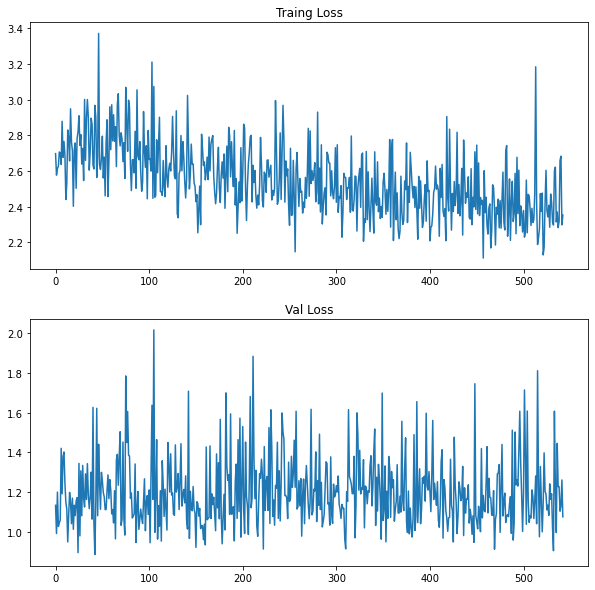

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.plot(train_losses[1000:])
plt.title('Traing Loss')

plt.subplot(212)
plt.plot(val_losses[1000:])
plt.title('Val Loss')

# Testing
The predictions of your model on testing set will be stored at `pred.csv`.

In [14]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

model = My_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device) 
save_pred(preds, 'pred1.csv')         

100%|██████████| 5/5 [00:00<00:00, 231.70it/s]


# Reference
This notebook uses code written by Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)